# PySpark

In [ ]:
# SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
# Other
import os
# PySpark functions
from pyspark.sql.functions import col, floor, concat
from functools import reduce
from operator import add
from pyspark.sql import functions as F


In [34]:
# # Stop existing session if needed
# SparkSession.builder.getOrCreate().stop()

spark=SparkSession.builder\
    .master("local[*]")\
    .appName("eda")\
    .getOrCreate()

In [35]:
current_dir = os.getcwd()
data_relative_path = os.path.join('..', 'data')

## Reading/Updating the dataset

In [86]:
app_data = spark.read.csv(os.path.join(current_dir, data_relative_path, 'application_data_cleaned.csv'), header=True, inferSchema=True)
prev_data = spark.read.csv(os.path.join(current_dir, data_relative_path, 'previous_application_cleaned.csv'), header=True, inferSchema=True)

In [87]:
# FLAG_DOCUMENT_ columns
doc_cols = [c for c in app_data.columns if c.startswith('FLAG_DOCUMENT_')]

# Sum them row-wise
app_data = app_data.withColumn(
    'Documents_count',
    reduce(add, [col(c) for c in doc_cols])
)

In [88]:
# Age column
app_data = app_data.withColumn(
    "AGE",
    floor(-col("DAYS_BIRTH") / 365)
)

In [89]:
# CREDIT_TO_INCOME
app_data = app_data.withColumn(
    "CREDIT_TO_INCOME",
    col("AMT_CREDIT") / col("AMT_INCOME_TOTAL")
)

In [90]:
# OWN_CAR_REALTY
app_data = app_data.withColumn(
    "OWN_CAR_REALTY",
    concat(col("FLAG_OWN_CAR"), col("FLAG_OWN_REALTY"))
)

In [91]:
# Count of all previous applications
prev_count = prev_data.groupBy('SK_ID_CURR').agg(
    F.count('*').alias('PREV_COUNT')
)

# Count of previous applications with status 'Approved'
prev_accepted_count = prev_data.filter(
    F.col('NAME_CONTRACT_STATUS') == 'Approved'
).groupBy('SK_ID_CURR').agg(
    F.count('*').alias('PREV_ACCEPTED_COUNT')
)

# stats of prev apps credit amount
prev_amt_credit_stats = prev_data.groupBy('SK_ID_CURR').agg(
    F.expr('percentile_approx(AMT_CREDIT, 0.25)').alias('PREV_AMT_CREDIT_Q1'),
    F.expr('percentile_approx(AMT_CREDIT, 0.75)').alias('PREV_AMT_CREDIT_Q3'),
    F.avg('AMT_CREDIT').alias('PREV_AMT_CREDIT_MEAN'),
    F.max('AMT_CREDIT').alias('PREV_AMT_CREDIT_MAX')
)


# merge the features into the main application data
prev_features = prev_count \
    .join(prev_accepted_count, on='SK_ID_CURR', how='left') \
    .join(prev_amt_credit_stats, on='SK_ID_CURR', how='left')

prev_features = prev_features.withColumn(
    'PREV_ACCEPTED_RATIO',
    F.when(
        F.col('PREV_COUNT') != 0,
        F.col('PREV_ACCEPTED_COUNT') / F.col('PREV_COUNT')
    ).otherwise(F.lit(None))
)


prev_features = prev_features.fillna(0)
merged_data = app_data.join(prev_features, on='SK_ID_CURR', how='left')


for col_name, prev_col in [
    ('CURR_AMT_Q1_RATIO', 'PREV_AMT_CREDIT_Q1'),
    ('CURR_AMT_Q3_RATIO', 'PREV_AMT_CREDIT_Q3'),
    ('CURR_AMT_MEAN_RATIO', 'PREV_AMT_CREDIT_MEAN')
]:
    merged_data = merged_data.withColumn(
        col_name,
        (F.col('AMT_CREDIT') / F.when(F.col(prev_col) != 0, F.col(prev_col)))
    )
merged_data= merged_data.withColumn(
    'CURR_AMT_GT_PREV_MAX',
    (F.col('AMT_CREDIT') > F.col('PREV_AMT_CREDIT_MAX')).cast('int')
)

# Fill null values with 0 for specific columns
cols_to_fill = [
    'PREV_COUNT', 'PREV_ACCEPTED_RATIO', 'CURR_AMT_Q1_RATIO', 
    'CURR_AMT_Q3_RATIO', 'CURR_AMT_MEAN_RATIO', 'CURR_AMT_GT_PREV_MAX', 
    'PREV_AMT_CREDIT_MEAN'
]

for col_name in cols_to_fill:
    merged_data = merged_data.withColumn(
        col_name,
        F.when(F.col(col_name).isNull(), F.lit(0)).otherwise(F.col(col_name))
    )

## Convert to pandas and start EDA

In [92]:
# toPandas faces some problems with python versoin!

In [93]:
import shutil
from pathlib import Path

output_dir = os.path.join(current_dir, data_relative_path, "tmp_output")

def save_csv(df, final_csv_path):
    # write df
    df.coalesce(1).write.option("header", "true").mode("overwrite").csv(output_dir)
    # get the result and rename it
    part_file = next(Path(output_dir).glob("part-*.csv"))
    shutil.move(str(part_file), final_csv_path)
    # remove tmp folder
    shutil.rmtree(output_dir)

    return f"File save to: {final_csv_path}"


In [94]:
final_csv_path = os.path.join(current_dir, data_relative_path, "app_data_eda.csv")
save_csv(app_data, final_csv_path)

'File save to: /home/shift/Documents/github/Loan-Default-Risk-Prediction/code_spark/../data/app_data_eda.csv'

In [95]:
final_csv_path = os.path.join(current_dir, data_relative_path, "prev_data_eda.csv")
save_csv(prev_data, final_csv_path)

'File save to: /home/shift/Documents/github/Loan-Default-Risk-Prediction/code_spark/../data/prev_data_eda.csv'

In [96]:
final_csv_path = os.path.join(current_dir, data_relative_path, "merged_data_eda.csv")
save_csv(merged_data, final_csv_path)

'File save to: /home/shift/Documents/github/Loan-Default-Risk-Prediction/code_spark/../data/merged_data_eda.csv'

# EDA

In [97]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Helper functions

In [98]:
current_dir = os.getcwd()
data_relative_path = os.path.join('..', 'data')
colors = ['#a8e8f9', '#00537a', '#013c58', '#f5a201', '#ffba42', '#ffd35b', '#fe86c8', '#ffc0db']

### Columns split

In [99]:
def split_categorical_continuous(df, min_unique_cat=5 ,max_unique_cat=15):
    categorical_cols = []
    continuous_cols = []
    categorical_cols_many = []

    for column in df.columns:
        # Object or category dtype => categorical
        if pd.api.types.is_string_dtype(df[column]) or isinstance(df[column], pd.CategoricalDtype):
            if df[column].nunique() <= min_unique_cat:
                categorical_cols.append(column)
            else:
                categorical_cols_many.append(column)
        # Numeric dtype (with few unique values) => categorical
        elif pd.api.types.is_numeric_dtype(df[column]):
            if df[column].nunique() <= min_unique_cat:
                categorical_cols.append(column)
            elif df[column].nunique() <= max_unique_cat:
                categorical_cols_many.append(column)
            else:
                continuous_cols.append(column)
        # bool => categorical
        elif pd.api.types.is_bool_dtype(df[column]):
            categorical_cols.append(column)
        else:
            print(f"unknown dtype for {column}!!")
    
    return categorical_cols, categorical_cols_many, continuous_cols

### Outliers

In [ ]:
def check_outliers(df, columns):
    # quartiles, IQR, and bounds
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_FD = Q1 - 1.5 * IQR
    upper_bound_FD = Q3 + 1.5 * IQR

    # detect outliers
    outliers = (df[columns] < lower_bound_FD) | (df[columns] > upper_bound_FD)
    # count outliers
    outliers_count = outliers.sum()
    total_rows = df[columns].count()
    outliers_percentage = outliers_count / total_rows

    print("outliers percentage:")
    print(f"{outliers_percentage*100}%")

def remove_outliers(df, columns):
    for col in columns:
        # quartiles, IQR, and bounds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound_FD = Q1 - 1.5 * IQR
        upper_bound_FD = Q3 + 1.5 * IQR

        # detect outliers
        outliers = (df[col] < lower_bound_FD) | (df[col] > upper_bound_FD)
        # Remove rows with outliers
        df = df[~outliers]
        print(f"shape after outliers removal {df.shape}")
    
    return df

### uni-variante

In [101]:
def plot_categorical_pie(df, columns, pies_per_row=3, colors=colors):
    for i in range(0, len(columns), pies_per_row):
        num_vars = min(pies_per_row, len(columns[i:]))  # for last row
        fig, axs = plt.subplots(1, num_vars, figsize=(6*pies_per_row, 6)) # 1 row, num_vars columns
        
        if num_vars == 1: # if 1 column
            axs = [axs]
        
        for j, var in enumerate(columns[i : i+num_vars]):
            uniques_freq = df[var].value_counts()
            wedges, texts, autotexts = axs[j].pie(uniques_freq, labels=None, autopct='%1.2f%%', startangle=90, colors=colors, textprops={'fontsize': 10})
            axs[j].legend(wedges, uniques_freq.index, title=var, loc="lower left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10) # slice category
            axs[j].set_title(f'{var}', color='black', fontsize=14,fontweight='bold', fontstyle='italic', fontfamily='serif')
            axs[j].axis('equal')  
        
        plt.subplots_adjust(wspace=0.3)
        plt.show()

In [ ]:
def plot_categorical_bar(df, columns, bars_per_row=3, threshold=0.02, colors=colors, normalize_freq=True):
    for i in range(0, len(columns), bars_per_row):
        num_vars = min(bars_per_row, len(columns[i:]))  # for last row
        fig, axs = plt.subplots(1, num_vars, figsize=(6*bars_per_row, 6)) # 1 row, num_vars columns

        if num_vars == 1: # if 1 column
            axs = [axs]

        for j, var in enumerate(columns[i : i + num_vars]):
            uniques_freq = df[var].value_counts(normalize=True)
            # group small categories into 'Other'
            small_categories = uniques_freq[uniques_freq < threshold]
            uniques_freq = uniques_freq[uniques_freq >= threshold]
            if not small_categories.empty:
                uniques_freq['Other'] = small_categories.sum()
            # sort bars
            uniques_freq = uniques_freq.sort_values(ascending=False).reset_index()
            uniques_freq.columns = [var, 'Proportion']

            sns.barplot(data=uniques_freq, x=var, y='Proportion', hue=var, palette='viridis', legend=False, ax=axs[j])

            axs[j].set_title(f'{var}', fontsize=14, fontweight='bold', fontstyle='italic', fontfamily='serif')
            axs[j].set_ylabel('Proportion')
            axs[j].set_xlabel('')
            axs[j].tick_params(axis='x', rotation=90)

            for idx, val in enumerate(uniques_freq['Proportion']):
                axs[j].text(idx, val + 0.01, f'{val:.1%}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

In [103]:
def plot_continous_hist(df, columns, hists_per_row=4, colors=colors):
    for i in range(0, len(columns), hists_per_row):
        num_vars = min(hists_per_row, len(columns[i:]))  # for last row
        fig, axs = plt.subplots(1, num_vars, figsize=(6*hists_per_row, 6)) # 1 row, num_vars columns

        if num_vars == 1: # if 1 column
            axs = [axs]

        for j, col in enumerate(columns[i : i + num_vars]):
            sns.histplot(df[col], bins=30, kde=True, color=colors[0], ax=axs[j])
            axs[j].set_title(f'{col}', color='black', fontsize=14, fontweight='bold', fontstyle='italic', fontfamily='serif')
            axs[j].set_xlabel(col)
            axs[j].tick_params(axis='x', rotation=90)
            axs[j].set_ylabel('Frequency')

        plt.subplots_adjust(wspace=0.3)
        plt.show()

### Bi-variate

In [ ]:
def plot_bivariate_pie(df, columns, target_column, colors=colors):
    max_cols = 6  # Max pies per row
    for var in columns:
        unique_values = [val for val in df[var].unique() if val != "XNA"]
        num_values = len(unique_values)
        
        ncols = min(num_values, max_cols)
        nrows = (num_values + max_cols - 1) // max_cols  # for 1 var, get num of rows
        
        fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
        axs = np.array(axs).reshape(-1)  # Flatten (multiple rows)

        for idx, value in enumerate(unique_values):
            ax = axs[idx]
            # filter df for the current value
            filtered_df = df[df[var] == value]

            if target_column:
                uniques_freq = filtered_df[target_column].value_counts()
            else:
                uniques_freq = filtered_df[var].value_counts()

            if uniques_freq.empty:
                continue

            wedges, texts, autotexts = ax.pie(
                uniques_freq,
                labels=None,
                autopct='%1.2f%%',
                startangle=90,
                colors=colors,
                textprops={'fontsize': 10}
            )
            ax.legend(
                wedges,
                uniques_freq.index,
                title=target_column if target_column else var,
                loc="lower left",
                bbox_to_anchor=(1, 0, 0.5, 1),
                fontsize=8
            )
            ax.set_title(
                f"{value}",
                color='black',
                fontsize=12,
                fontweight='bold',
                fontstyle='italic',
                fontfamily='serif'
            )
            ax.axis('equal')

        # Turn off any unused subplots
        for j in range(idx + 1, len(axs)):
            axs[j].axis('off')

        plt.suptitle(f"{var}", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

In [ ]:
def analyze_target_ratio_by_bins(df, column, target_column='TARGET', bins=10, figsize=(12, 6), float_point = 0):
    # copy df
    data = df[[column, target_column]].copy()
    
    # create bins (same number of samples)
    data['bin'] = pd.qcut(data[column], q=bins, duplicates='drop')

    
    # Calculate statistics by bin
    bin_stats = data.groupby('bin').agg({
        target_column: ['count', 'sum', 'mean'],
        column: ['min', 'max', 'mean']
    })
    
    # flatten stats
    bin_stats.columns = ['_'.join(col).strip() for col in bin_stats.columns.values]
    
    # rename stats
    bin_stats = bin_stats.rename(columns={
        f'{target_column}_count': 'total_count',
        f'{target_column}_sum': 'target_1_count',
        f'{target_column}_mean': 'target_ratio',
        f'{column}_min': 'min_value',
        f'{column}_max': 'max_value',
        f'{column}_mean': 'mean_value'
    })
    
    # calc target=0 count
    bin_stats['target_0_count'] = bin_stats['total_count'] - bin_stats['target_1_count']
    
    # calc ratio of target=1 to target=0 (avoiding division by zero)
    bin_stats['ratio_1_to_0'] = np.where(
        bin_stats['target_0_count'] > 0,
        bin_stats['target_1_count'] / bin_stats['target_0_count'],
        np.inf
    )
    
    # Create visualization
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Plot the bar chart for counts
    x = range(len(bin_stats))
    width = 0.35
    
    ax1.bar(x, bin_stats['target_0_count'], width, label='Target 0', color='#ff5db6', alpha=0.7)
    ax1.bar(x, bin_stats['target_1_count'], width, bottom=bin_stats['target_0_count'], 
            label='Target 1', color='#5a77d8', alpha=0.7)
    
    ax1.set_ylabel('Count')
    ax1.set_title(f'Target Distribution by {column} Bins')
    ax1.set_xticks(x)
    format_string = f"{{:.{float_point}f}}-{{:.{float_point}f}}"
    ax1.set_xticklabels([format_string.format(r.left, r.right) for r in bin_stats.index], 
                        rotation=45, ha='right')

    ax1.legend(loc='upper left')
    
    # Create a second y-axis for the ratio
    ax2 = ax1.twinx()
    ax2.plot(x, bin_stats['target_ratio'], 'ro-', linewidth=2, markersize=6, label='Target Ratio')
    ax2.set_ylabel('Target Ratio (Target 1 / Total)')
    ax2.set_ylim([0, min(1, bin_stats['target_ratio'].max() * 1.2)])  # Set y limit with some margin
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return bin_stats

### Multi-variate

In [107]:
def plot_correlation_matrix(df):
    # Drop non-numeric columns & non-categorical columns
    numeric_data = df.select_dtypes(include='number')

    # Compute the correlation matrix
    corr = numeric_data.corr()

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(50, 50))
    heatmap = sns.heatmap(corr, annot=True, cmap='Blues',fmt=".2f")
    # Set font size for y-axis tick labels
    heatmap.yaxis.set_tick_params(labelsize=10)
    plt.title('Correlation Matrix')
    plt.show()

## Load data

In [108]:
# Load data
app_data_clean = pd.read_csv(os.path.join(current_dir, data_relative_path, "app_data_eda.csv"))
prev_data_clean = pd.read_csv(os.path.join(current_dir, data_relative_path, "prev_data_eda.csv"))
merged_data_clean = pd.read_csv(os.path.join(current_dir, data_relative_path, "merged_data_eda.csv"))

In [109]:
app_data_clean

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100004       0    Revolving loans           M            Y   
2           100008       0         Cash loans           M            N   
3           100009       0         Cash loans           F            Y   
4           100010       0         Cash loans           M            Y   
...            ...     ...                ...         ...          ...   
244275      456247       0         Cash loans           F            N   
244276      456249       0         Cash loans           F            N   
244277      456253       0         Cash loans           F            N   
244278      456254       1         Cash loans           F            N   
244279      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    Y             0           67500.0    135000.0   
2                    Y             0           99000.0    490495.5   
3                    Y             1          171000.0   1560726.0   
4                    Y             0          360000.0   1530000.0   
...                ...           ...               ...         ...   
244275               Y             0          112500.0    345510.0   
244276               Y             0          112500.0    225000.0   
244277               Y             0          153000.0    677664.0   
244278               Y             0          171000.0    370107.0   
244279               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  AMT_REQ_CREDIT_BUREAU_HOUR  \
0           24700.5  ...                         0.0   
1            6750.0  ...                         0.0   
2           27517.5  ...                         0.0   
3           41301.0  ...                         0.0   
4           42075.0  ...                         0.0   
...             ...  ...                         ...   
244275      17770.5  ...                         0.0   
244276      22050.0  ...                         0.0   
244277      29979.0  ...                         1.0   
244278      20205.0  ...                         0.0   
244279      49117.5  ...                         0.0   

       AMT_REQ_CREDIT_BUREAU_DAY AMT_REQ_CREDIT_BUREAU_WEEK  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   
...                          ...                        ...   
244275                       0.0                        0.0   
244276                       0.0                        0.0   
244277                       0.0                        0.0   
244278                       0.0                        0.0   
244279                       0.0                        0.0   

       AMT_REQ_CREDIT_BUREAU_MON AMT_REQ_CREDIT_BUREAU_QRT  \
0                            0.0                       0.0   
1                            0.0                       0.0   
2                            0.0                       1.0   
3                            1.0                       1.0   
4                            0.0                       0.0   
...                          ...                       ...   
244275                       1.0                       0.0   
244276                       2.0                       0.0   
244277                       1.0                       0.0   
244278                       0.0                       0.0   
244279                       2.0                       0.0   

       AMT_REQ_CREDIT_BUREAU_YEAR  Documents_count  AGE  CREDIT_TO_INCOME  \
0                         

In [110]:
app_data_clean.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  244280.000000  244280.000000  244280.000000      2.442800e+05   
mean   278174.746766       0.077911       0.424464      1.718673e+05   
std    102821.082923       0.268031       0.726920      2.574318e+05   
min    100002.000000       0.000000       0.000000      2.610000e+04   
25%    189005.750000       0.000000       0.000000      1.125000e+05   
50%    278108.500000       0.000000       0.000000      1.575000e+05   
75%    367218.250000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  2.442800e+05  244280.000000     2.442800e+05   
mean   6.084706e+05   27205.476691     5.466409e+05   
std    4.044097e+05   14323.175117     3.710316e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.750400e+05   16713.000000     2.385000e+05   
50%    5.212800e+05   25060.500000     4.500000e+05   
75%    8.140410e+05   34780.500000     6.885000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               244280.000000  244280.000000  244280.000000  ...   
mean                     0.020747  -16134.851019   63618.486442  ...   
std                      0.013676    4297.248021  141214.110420  ...   
min                      0.000290  -25201.000000  -17912.000000  ...   
25%                      0.010006  -19724.000000   -2884.000000  ...   
50%                      0.018850  -15832.000000   -1281.000000  ...   
75%                      0.028663  -12602.000000    -307.000000  ...   
max                      0.072508   -7676.000000  365243.000000  ...   

       FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_HOUR  \
count     244280.000000               244280.000000   
mean           0.000319                    0.006382   
std            0.017866                    0.083839   
min            0.000000                    0.000000   
25%            0.000000                    0.000000   
50%            0.000000                    0.000000   
75%            0.000000                    0.000000   
max            1.000000                    4.000000   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
count              244280.000000               244280.000000   
mean                    0.006890                    0.034477   
std                     0.110142                    0.204138   
min                     0.000000                    0.000000   
25%                     0.000000                    0.000000   
50%                     0.000000                    0.000000   
75%                     0.000000                    0.000000   
max                     9.000000                    8.000000   

       AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
count              244280.000000              244280.000000   
mean                    0.276146                   0.264070   
std                     0.939164                   0.609478   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.000000                   0.000000   
max                    27.000000                   8.000000   

       AMT_REQ_CREDIT_BUREAU_YEAR  Documents_count            AGE  \
count               244280.000000    244280.000000  244280.000000   
mean                     1.901490         0.935725      43.703447   
std                      1.859797         0.339079      11.772721   
min                      0.000000         0.000000      21.000000   
25%                      0.000000         1.000000      34.000000   
50%                      1.000000         1.000000      43.000000   
75%                      3.000000         1.000000      54.000000   
max                    

In [111]:
prev_data_clean

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
4           1784265      202054         Cash loans    31924.395   
...             ...         ...                ...          ...   
1246315     2300464      352015     Consumer loans    14704.290   
1246316     2357031      334635     Consumer loans     6622.020   
1246317     2659632      249544     Consumer loans    11520.855   
1246318     2785582      400317         Cash loans    18821.520   
1246319     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_GOODS_PRICE  \
0                17145.0     17145.0          17145.0   
1               607500.0    679671.0         607500.0   
2               112500.0    136444.5         112500.0   
3               450000.0    470790.0         450000.0   
4               337500.0    404055.0         337500.0   
...                  ...         ...              ...   
1246315         267295.5    311400.0         267295.5   
1246316          87750.0     64291.5          87750.0   
1246317         105237.0    102523.5         105237.0   
1246318         180000.0    191880.0         180000.0   
1246319         360000.0    360000.0         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                         SATURDAY                       15   
1                         THURSDAY                       11   
2                          TUESDAY                       11   
3                           MONDAY                        7   
4                         THURSDAY                        9   
...                            ...                      ...   
1246315                  WEDNESDAY                       12   
1246316                    TUESDAY                       15   
1246317                     MONDAY                       12   
1246318                  WEDNESDAY                        9   
1246319                     SUNDAY                       10   

        FLAG_LAST_APPL_PER_CONTRACT  ...  NAME_CLIENT_TYPE  \
0                                 Y  ...          Repeater   
1                                 Y  ...          Repeater   
2                                 Y  ...          Repeater   
3                                 Y  ...          Repeater   
4                                 Y  ...          Repeater   
...                             ...  ...               ...   
1246315                           Y  ...         Refreshed   
1246316                           Y  ...               New   
1246317                           Y  ...          Repeater   
1246318                           Y  ...          Repeater   
1246319                           Y  ...          Repeater   

          NAME_GOODS_CATEGORY NAME_PORTFOLIO  NAME_PRODUCT_TYPE  \
0                      Mobile            POS                XNA   
1                         XNA           Cash             x-sell   
2                         XNA           Cash             x-sell   
3                         XNA           Cash             x-sell   
4                         XNA           Cash            walk-in   
...                       ...            ...                ...   
1246315             Furniture            POS                XNA   
1246316             Furniture            POS                XNA   
1246317  Consumer Electronics            POS                XNA   
1246318                   XNA           Cash             x-sell   
1246319                   XNA           Cash             x-sell   

                    CHANNEL_TYPE SELLERPLACE_AREA  NAME_SELLER_INDUSTRY  \
0                   Country-wide               35          Connectivity   
1                 Contact center               -1             

In [112]:
prev_data_clean.describe()

SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.246320e+06  1.246320e+06  1.246320e+06     1.246320e+06   
mean   1.913834e+06  2.783561e+05  1.605938e+04     2.325942e+05   
std    5.340824e+05  1.027801e+05  1.492967e+04     3.186545e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.446936e+06  1.893740e+05  6.327990e+03     5.220000e+04   
50%    1.910148e+06  2.787420e+05  1.125000e+04     1.125000e+05   
75%    2.377944e+06  3.673812e+05  2.061227e+04     2.475000e+05   
max    2.845379e+06  4.562550e+05  4.180581e+05     5.850000e+06   

         AMT_CREDIT  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  \
count  1.246320e+06     1.246320e+06             1.246320e+06   
mean   2.492727e+05     2.326240e+05             1.258250e+01   
std    3.465843e+05     3.186729e+05             3.326113e+00   
min    0.000000e+00     0.000000e+00             0.000000e+00   
25%    5.157450e+04     5.220000e+04             1.000000e+01   
50%    1.161675e+05     1.125000e+05             1.200000e+01   
75%    2.700000e+05     2.475000e+05             1.500000e+01   
max    4.509688e+06     5.850000e+06             2.300000e+01   

       NFLAG_LAST_APPL_IN_DAY  DAYS_DECISION  SELLERPLACE_AREA   CNT_PAYMENT  
count            1.246320e+06   1.246320e+06      1.246320e+06  1.246320e+06  
mean             9.978914e-01  -1.021855e+03      4.056201e+02  1.671954e+01  
std              4.587116e-02   7.864511e+02      8.246103e+03  1.448712e+01  
min              0.000000e+00  -2.922000e+03     -1.000000e+00  0.000000e+00  
25%              1.000000e+00  -1.534000e+03     -1.000000e+00  6.000000e+00  
50%              1.000000e+00  -7.660000e+02      2.700000e+01  1.200000e+01  
75%              1.000000e+00  -3.850000e+02      1.460000e+02  2.400000e+01  
max              1.000000e+00  -1.000000e+00      4.000000e+06  8.400000e+01

In [113]:
merged_data_clean

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100008       0         Cash loans           M            N   
1           100016       0         Cash loans           F            N   
2           100020       0         Cash loans           M            N   
3           100025       0         Cash loans           F            Y   
4           100035       0         Cash loans           F            N   
...            ...     ...                ...         ...          ...   
244275      456229       0    Revolving loans           F            N   
244276      456233       1         Cash loans           F            N   
244277      456234       0         Cash loans           M            N   
244278      456240       0    Revolving loans           F            N   
244279      456254       1         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0           99000.0    490495.5   
1                    Y             0           67500.0     80865.0   
2                    N             0          108000.0    509602.5   
3                    Y             1          202500.0   1132573.5   
4                    Y             0          292500.0    665892.0   
...                ...           ...               ...         ...   
244275               Y             1          270000.0    180000.0   
244276               Y             0          225000.0    521280.0   
244277               Y             0           81000.0    135000.0   
244278               N             0          360000.0    337500.0   
244279               Y             0          171000.0    370107.0   

        AMT_ANNUITY  ...  PREV_ACCEPTED_COUNT PREV_AMT_CREDIT_Q1  \
0           27517.5  ...                  4.0            39955.5   
1            5881.5  ...                  4.0            42403.5   
2           26149.5  ...                  2.0            35086.5   
3           37561.5  ...                  7.0            95625.0   
4           24592.5  ...                  8.0           107640.0   
...             ...  ...                  ...                ...   
244275       9000.0  ...                  NaN                NaN   
244276      23089.5  ...                  2.0            45000.0   
244277       9148.5  ...                  2.0            24489.0   
244278      16875.0  ...                  4.0            67846.5   
244279      20205.0  ...                  2.0            21456.0   

       PREV_AMT_CREDIT_Q3 PREV_AMT_CREDIT_MEAN PREV_AMT_CREDIT_MAX  \
0              162598.500           203459.625            501975.0   
1               98500.500           106221.375            232200.0   
2               48325.500            41706.000             48325.5   
3              479679.255           337629.465           1042560.0   
4              582768.000           355934.250           1260000.0   
...                   ...                  ...                 ...   
244275                NaN                0.000                 NaN   
244276          90450.000            67725.000             90450.0   
244277          87682.500            47673.000             87682.5   
244278         528633.000           388613.250            769419.0   
244279         247423.500           134439.750            247423.5   

       PREV_ACCEPTED_RATIO  CURR_AMT_Q1_RATIO  CURR_AMT_Q3_RATIO  \
0                 1.000000          12.276045           3.016605   
1                 1.000000           1.907036           0.820960   
2                 1.000000          14.524176          10.545209   
3                 1.000000          11.843906           2.361106   
4                 0.800000           6.186288           1.142637   
...                    ...                ...                ...   
244275            0.000000           0.000000           0.000000   
244276            1.000000          11.584000           5.763184   
244277  

In [114]:
merged_data_clean.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  244280.000000  244280.000000  244280.000000      2.442800e+05   
mean   278174.746766       0.077911       0.424464      1.718673e+05   
std    102821.082923       0.268031       0.726920      2.574318e+05   
min    100002.000000       0.000000       0.000000      2.610000e+04   
25%    189005.750000       0.000000       0.000000      1.125000e+05   
50%    278108.500000       0.000000       0.000000      1.575000e+05   
75%    367218.250000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  2.442800e+05  244280.000000     2.442800e+05   
mean   6.084706e+05   27205.476691     5.466409e+05   
std    4.044097e+05   14323.175117     3.710316e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.750400e+05   16713.000000     2.385000e+05   
50%    5.212800e+05   25060.500000     4.500000e+05   
75%    8.140410e+05   34780.500000     6.885000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               244280.000000  244280.000000  244280.000000  ...   
mean                     0.020747  -16134.851019   63618.486442  ...   
std                      0.013676    4297.248021  141214.110420  ...   
min                      0.000290  -25201.000000  -17912.000000  ...   
25%                      0.010006  -19724.000000   -2884.000000  ...   
50%                      0.018850  -15832.000000   -1281.000000  ...   
75%                      0.028663  -12602.000000    -307.000000  ...   
max                      0.072508   -7676.000000  365243.000000  ...   

       PREV_ACCEPTED_COUNT  PREV_AMT_CREDIT_Q1  PREV_AMT_CREDIT_Q3  \
count        231231.000000        2.312310e+05        2.312310e+05   
mean              2.998058        9.408890e+04        2.955919e+05   
std               2.083354        1.269947e+05        3.491092e+05   
min               0.000000        0.000000e+00        6.183000e+03   
25%               1.000000        3.382875e+04        8.622000e+04   
50%               2.000000        5.643000e+04        1.591020e+05   
75%               4.000000        1.079100e+05        3.600000e+05   
max              27.000000        4.050000e+06        4.095000e+06   

       PREV_AMT_CREDIT_MEAN  PREV_AMT_CREDIT_MAX  PREV_ACCEPTED_RATIO  \
count          2.442800e+05         2.312310e+05        244280.000000   
mean           1.994408e+05         4.191561e+05             0.822956   
std            2.122947e+05         4.705534e+05             0.283803   
min            0.000000e+00         6.183000e+03             0.000000   
25%            6.571575e+04         1.014818e+05             0.666667   
50%            1.279710e+05         2.250000e+05             1.000000   
75%            2.604811e+05         5.588550e+05             1.000000   
max            4.050000e+06         4.509688e+06             1.000000   

       CURR_AMT_Q1_RATIO  CURR_AMT_Q3_RATIO  CURR_AMT_MEAN_RATIO  \
count      244280.000000      244280.000000        244280.000000   
mean           11.670620           4.885490             5.526662   
std            13.044909           6.946690             7.276958   
min             0.000000           0.000000             0.000000   
25%             3.239997           1.034300             1.429621   
50%             7.325532           2.472488             3.026816   
75%            15.249911           5.917877             6.717136   
max           187.921569         167.820000           167.820000   

       CURR_AMT_GT_PREV_MAX  
count         244280.000000  
mean               0.659248  
std                0.473963  
min                0.000000  
25%                0.000000  
50%                1.000000  
75%                1.000000  
max                1.000000  

[8 rows x 75 columns]

## Univariate Analysis

In [115]:
# Seperate columns
app_categorical_columns, app_categorical_columns_extra, app_continuous_columns = split_categorical_continuous(app_data_clean)
prev_categorical_columns, prev_categorical_columns_extra, prev_continuous_columns = split_categorical_continuous(prev_data_clean)

print(app_categorical_columns)
print(app_categorical_columns_extra)
print(app_continuous_columns)
print(prev_categorical_columns)
print(prev_categorical_columns_extra)
print(prev_continuous_columns)

['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'Documents_count', 'OWN_CAR_REALTY']
['CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'WEEKDAY_APP

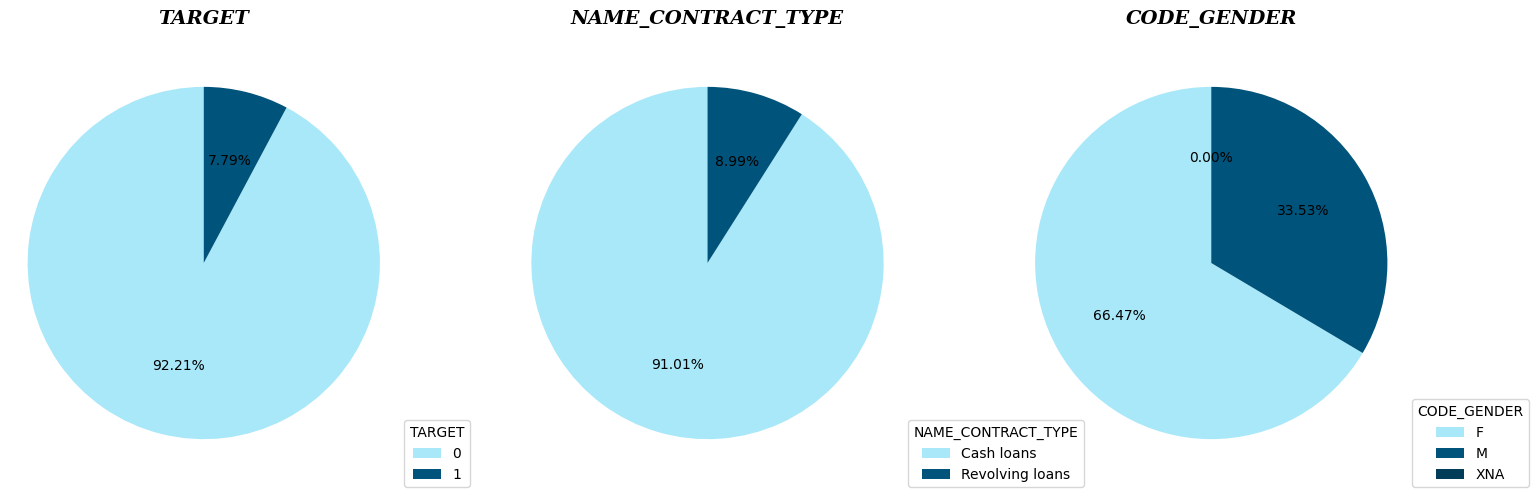

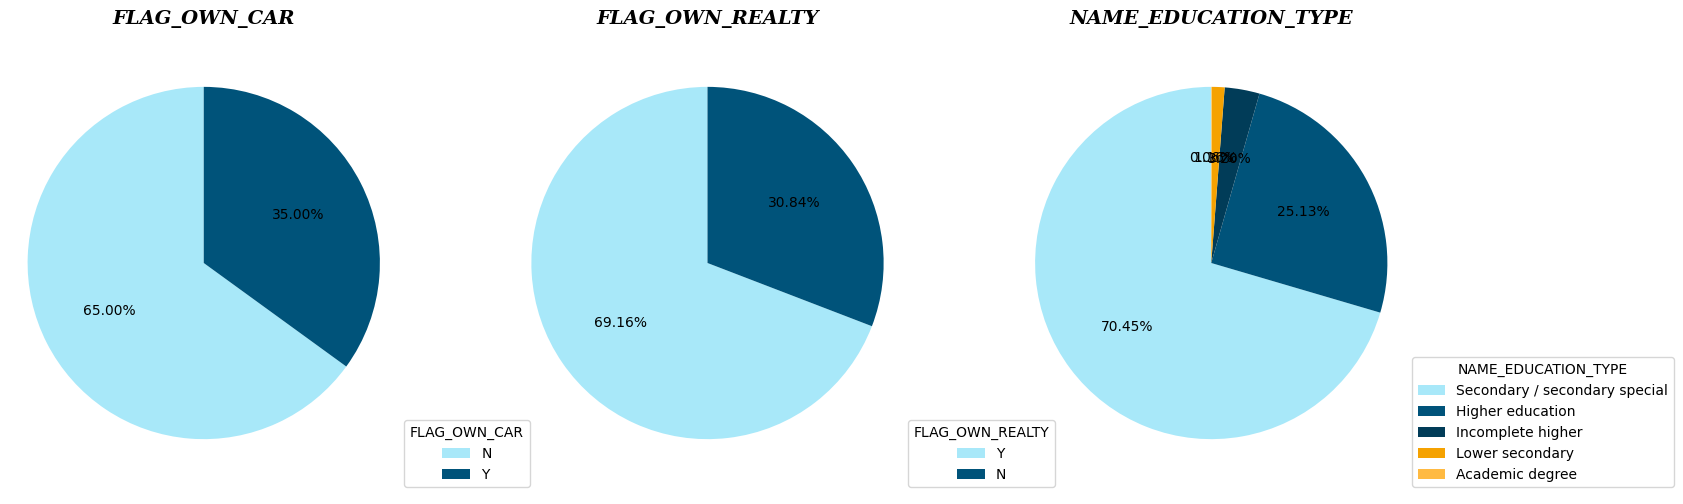

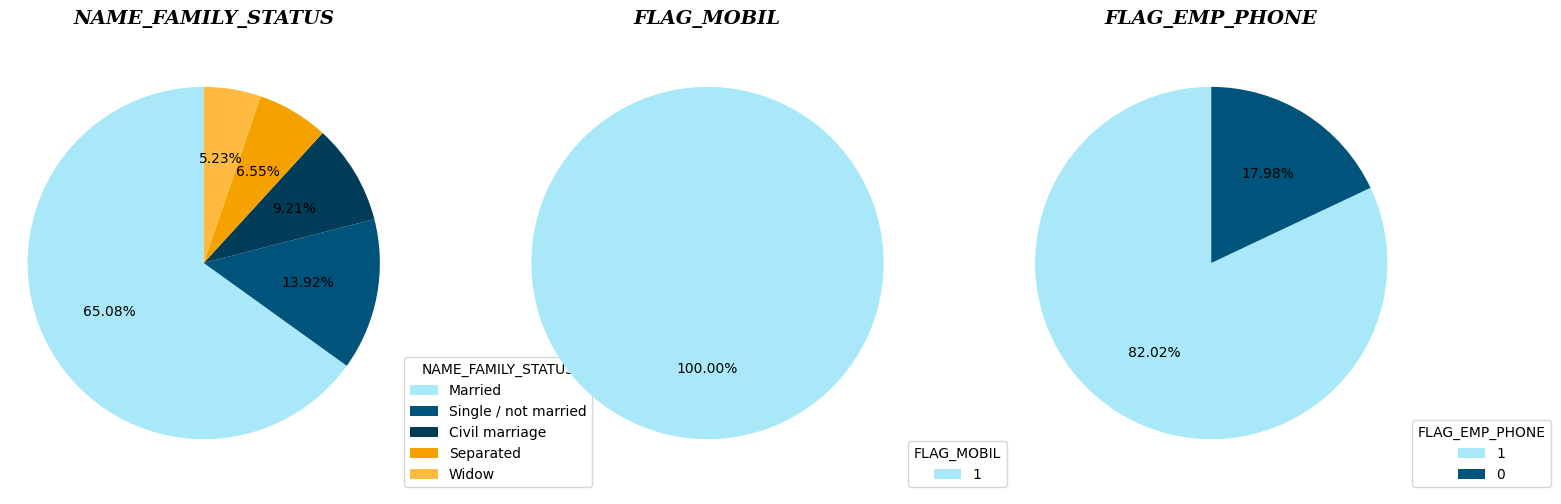

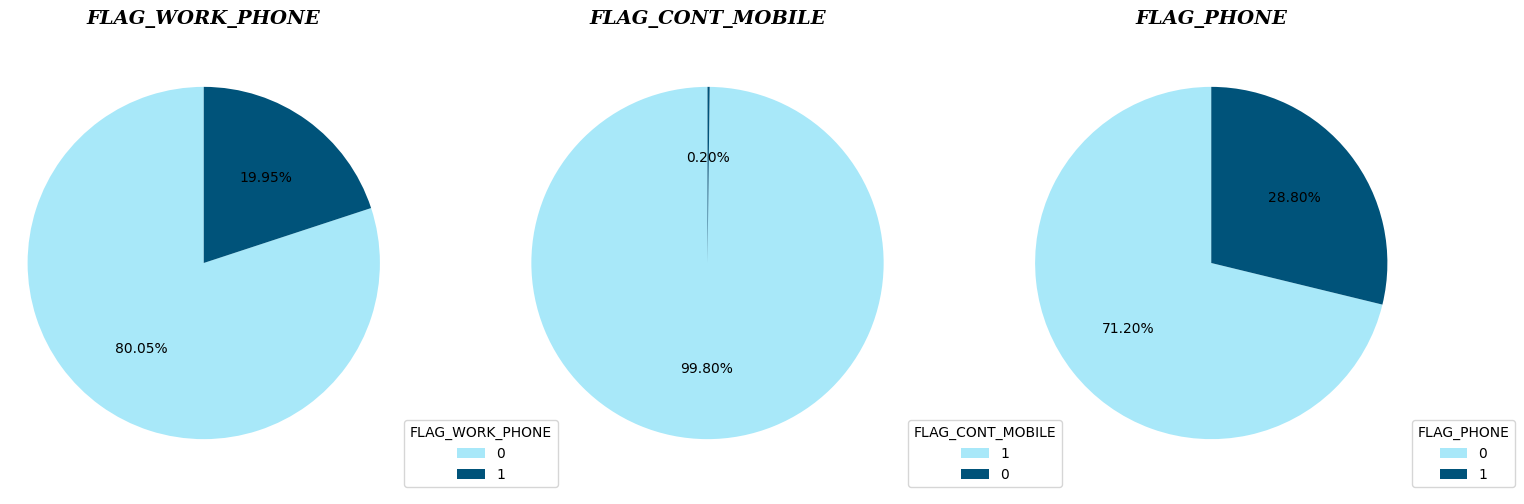

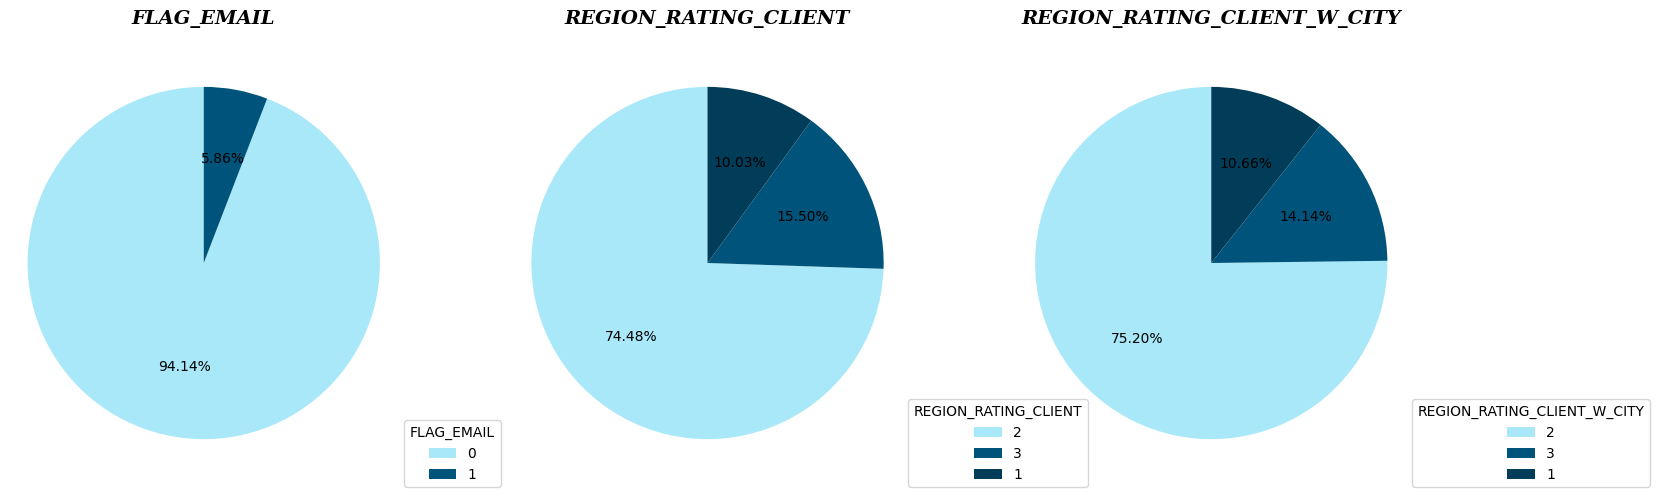

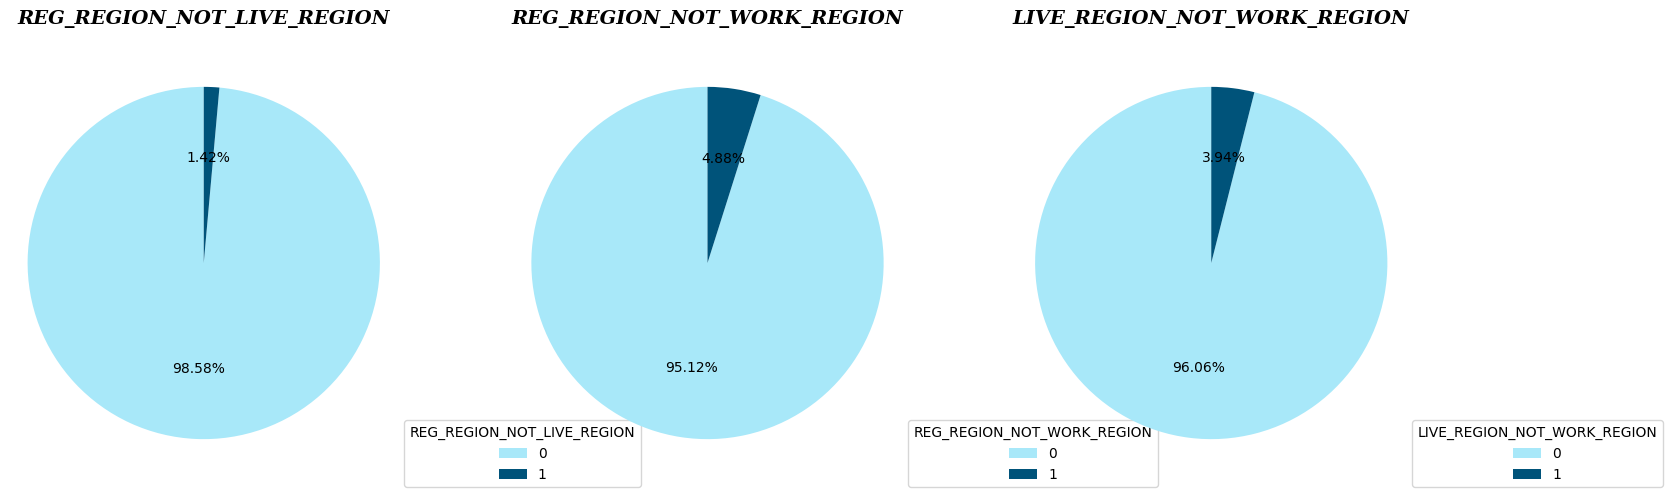

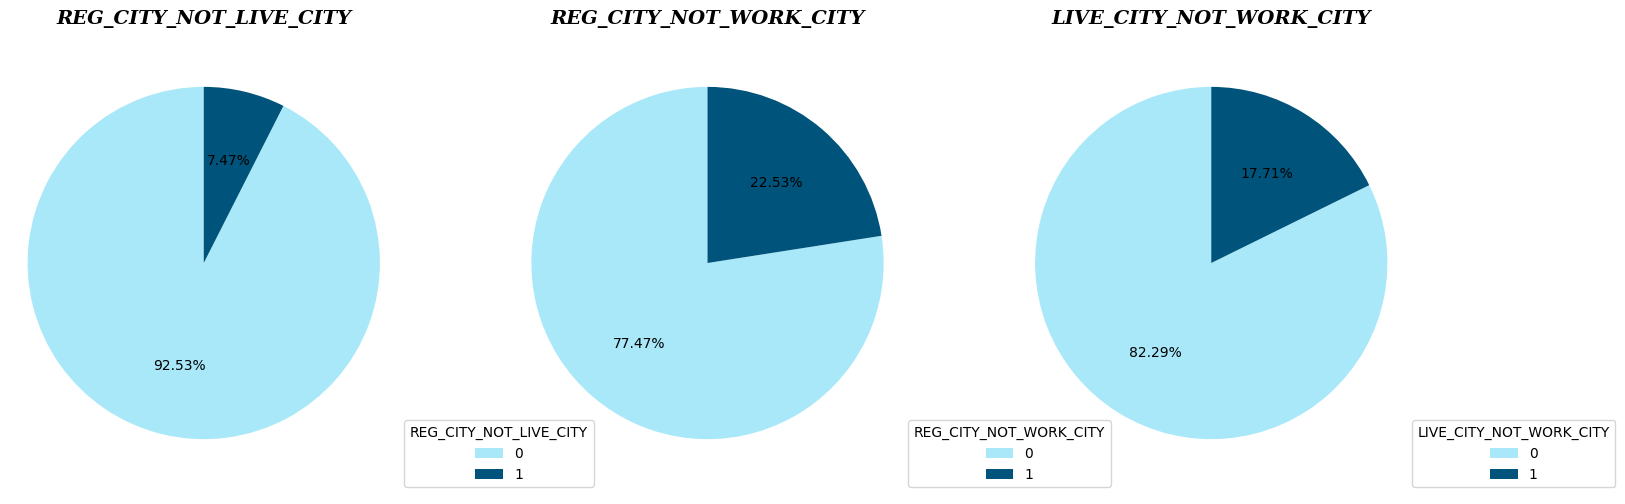

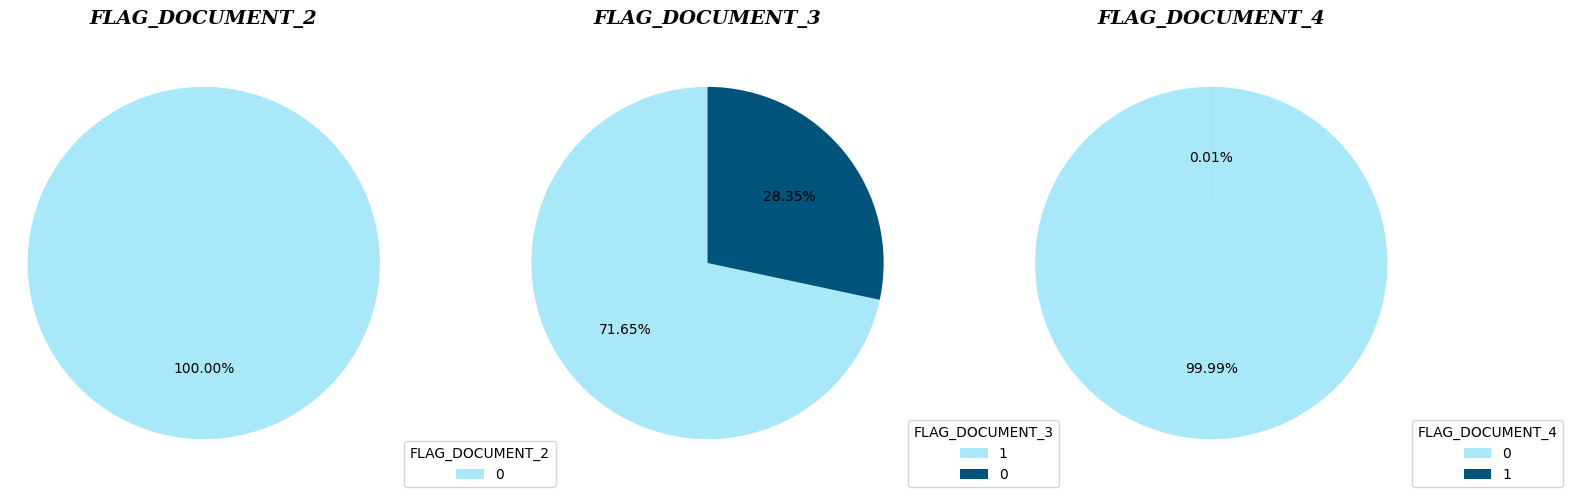

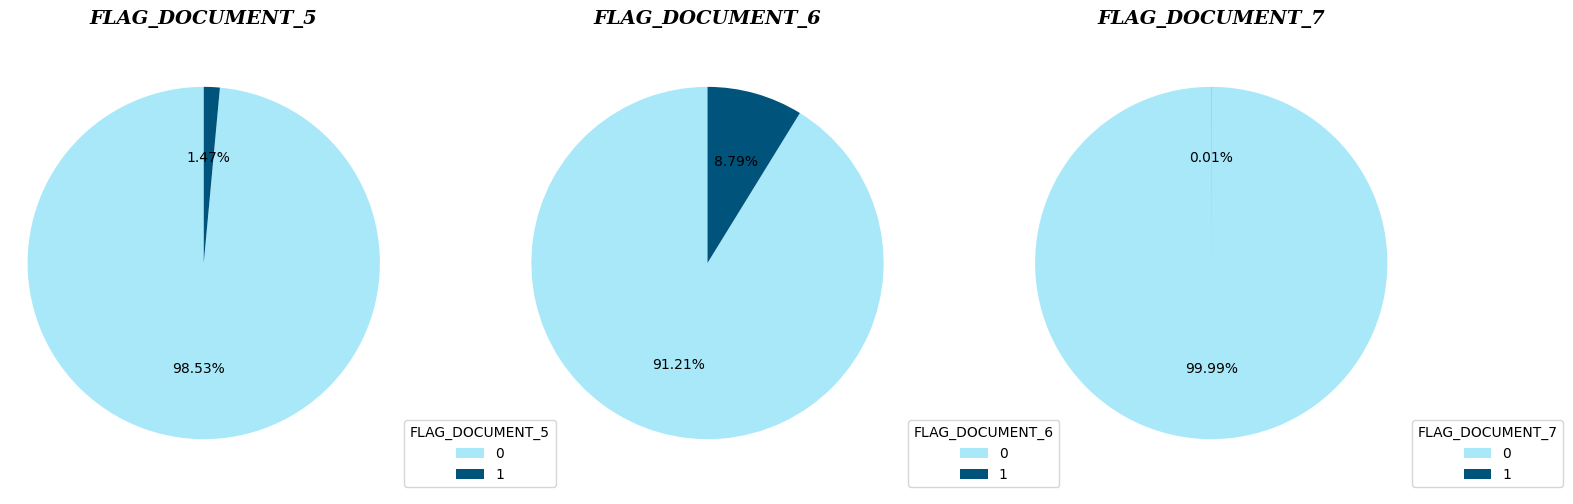

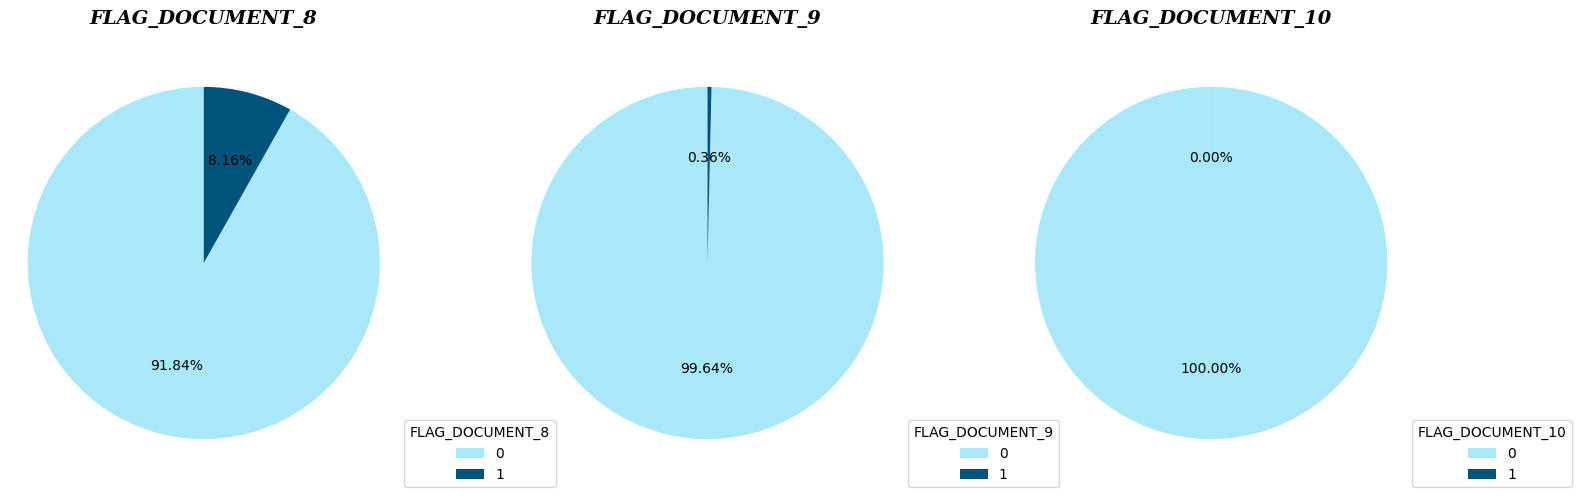

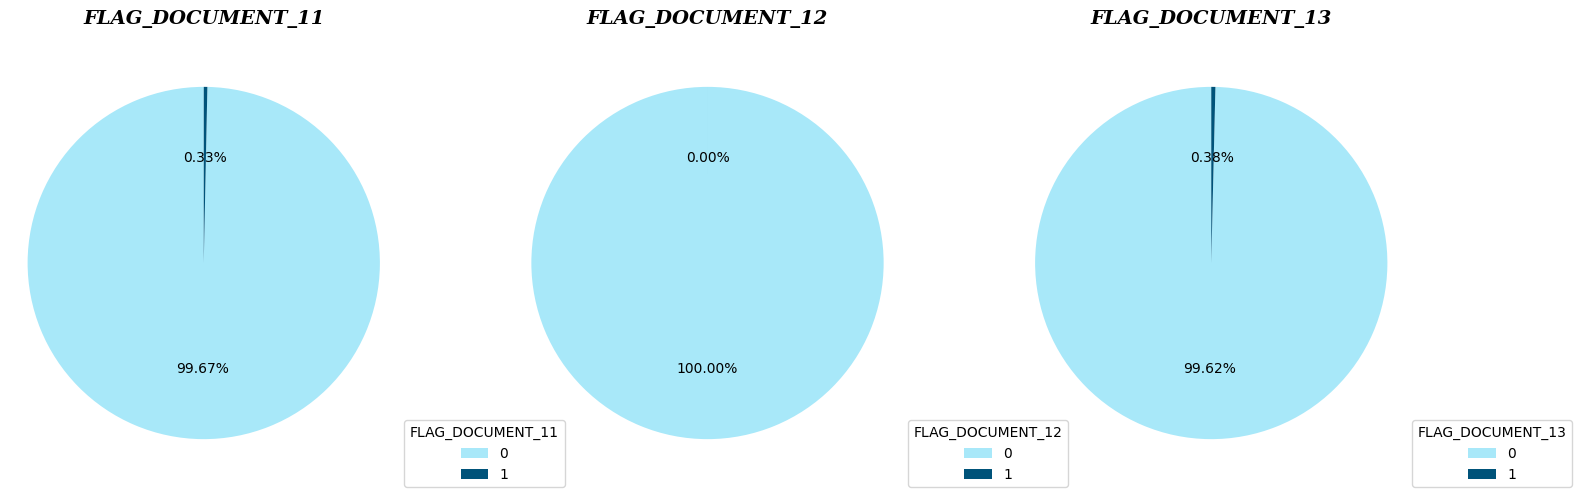

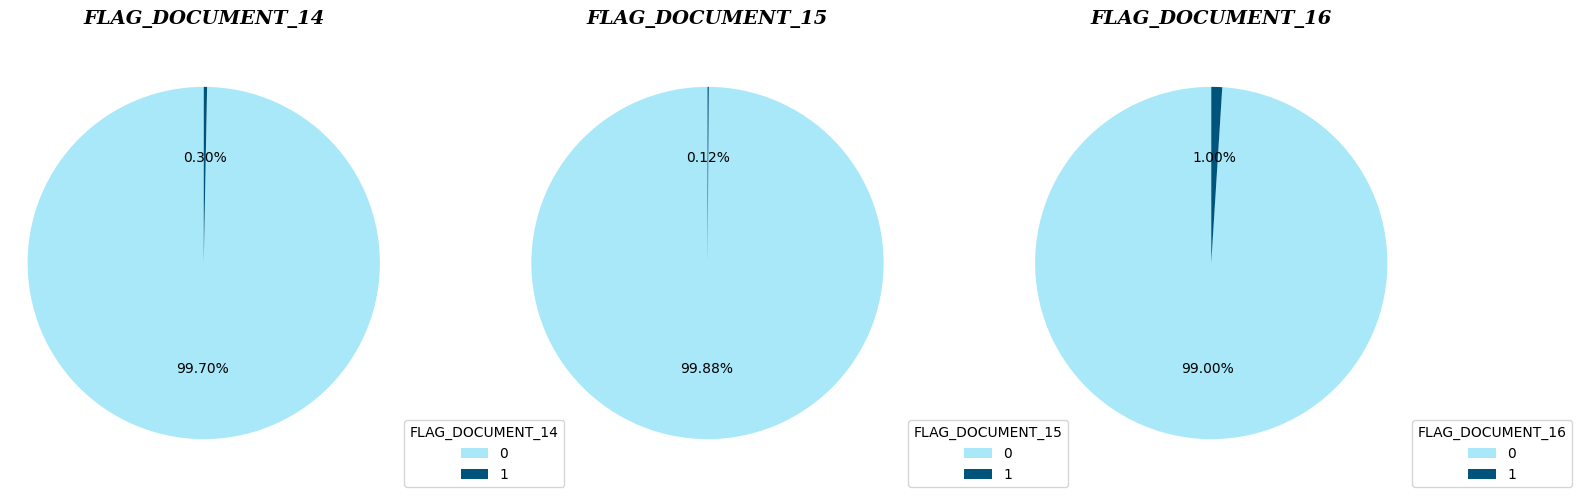

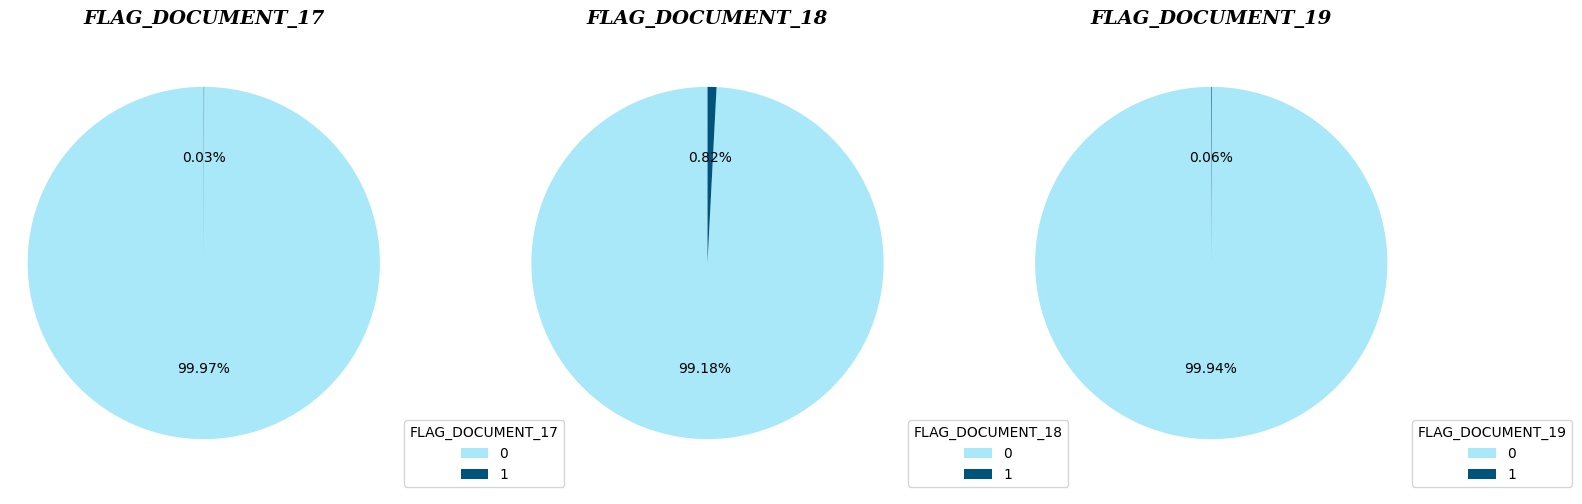

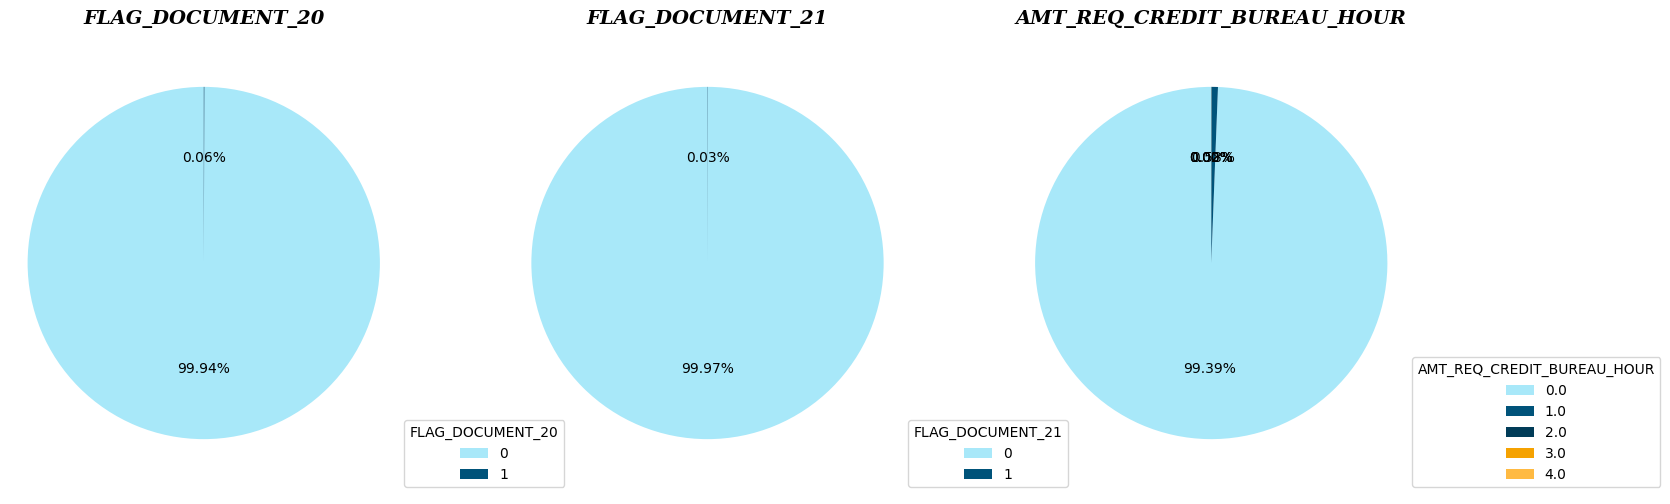

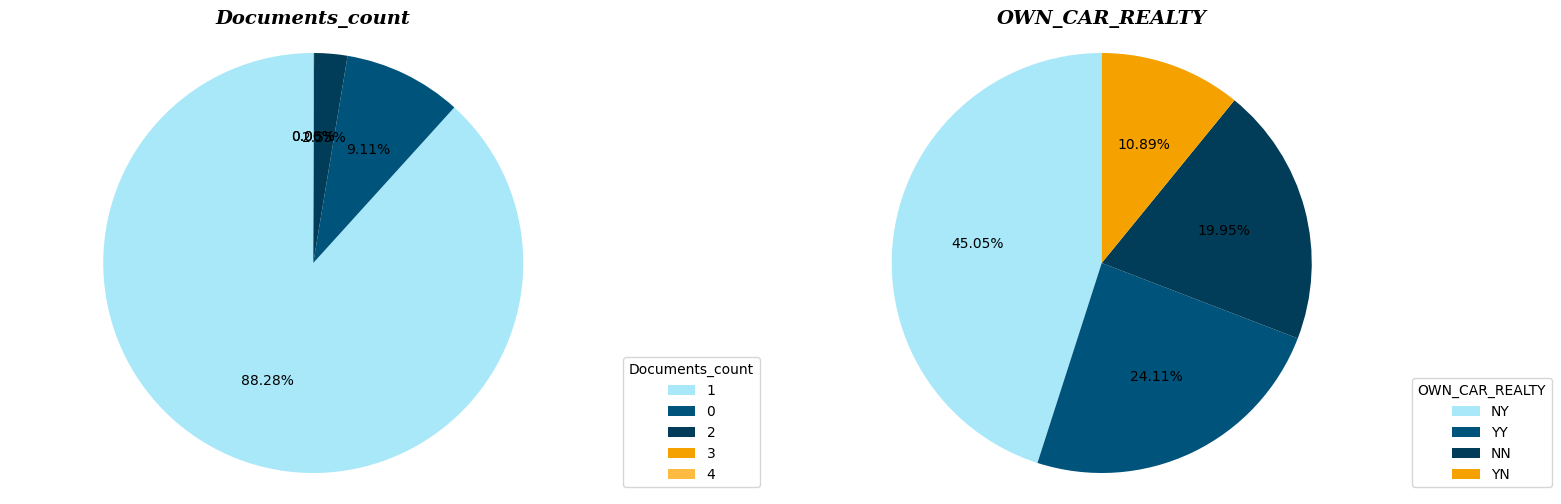

In [116]:
plot_categorical_pie(app_data_clean, app_categorical_columns)

**Insights**

---

- There is more females in the dataset
- Most of clients (are married/own cars/own realty)
- Most of clients lives in regions of middle rating
- Most of clients have education till ("Secondary / secondary special", "Higher education") level
- Most clients doesn't deliver docuemnts less document_3
- Most of the loans are cash
- Most of client live in the city they work in.

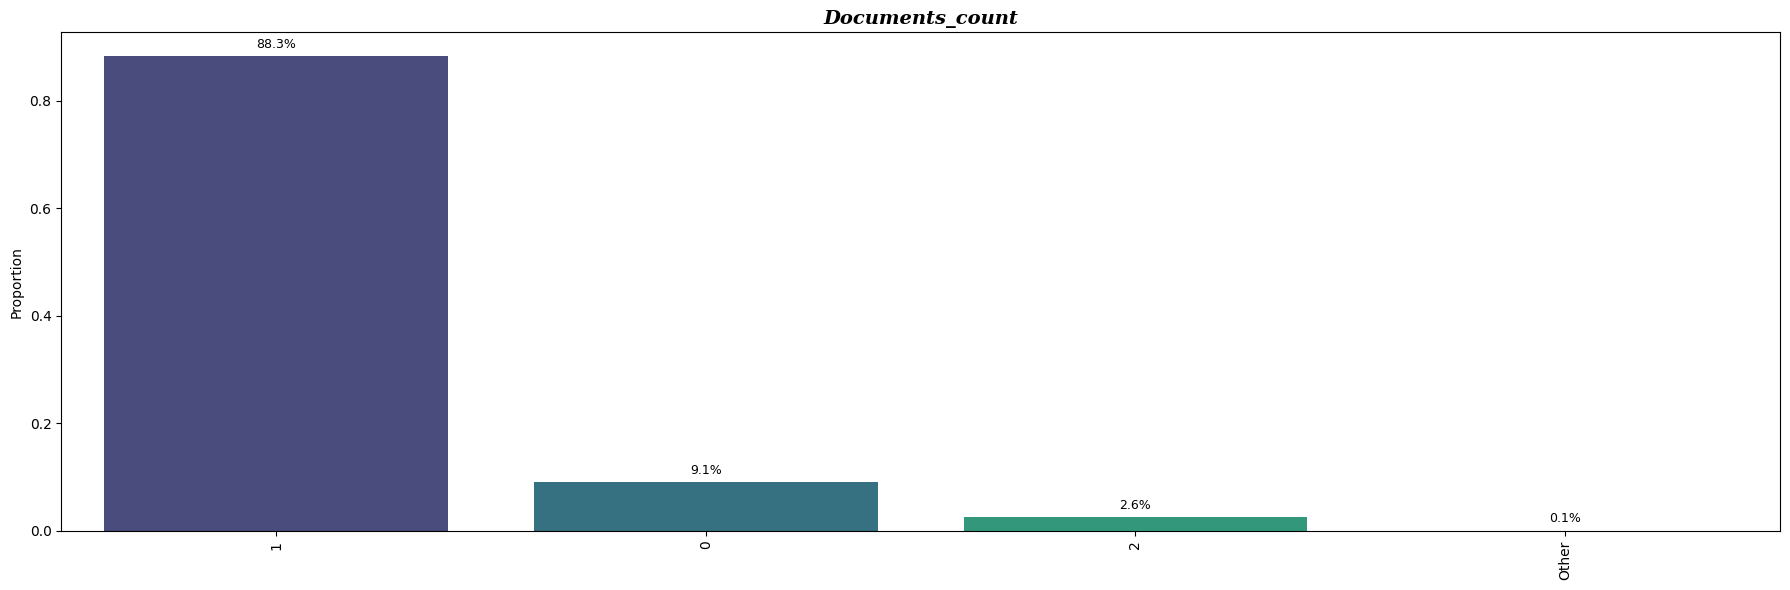

In [117]:
plot_categorical_bar(app_data_clean, ["Documents_count"])

**Insights**

---

- from all the documents 88% of clients deliver only 1.

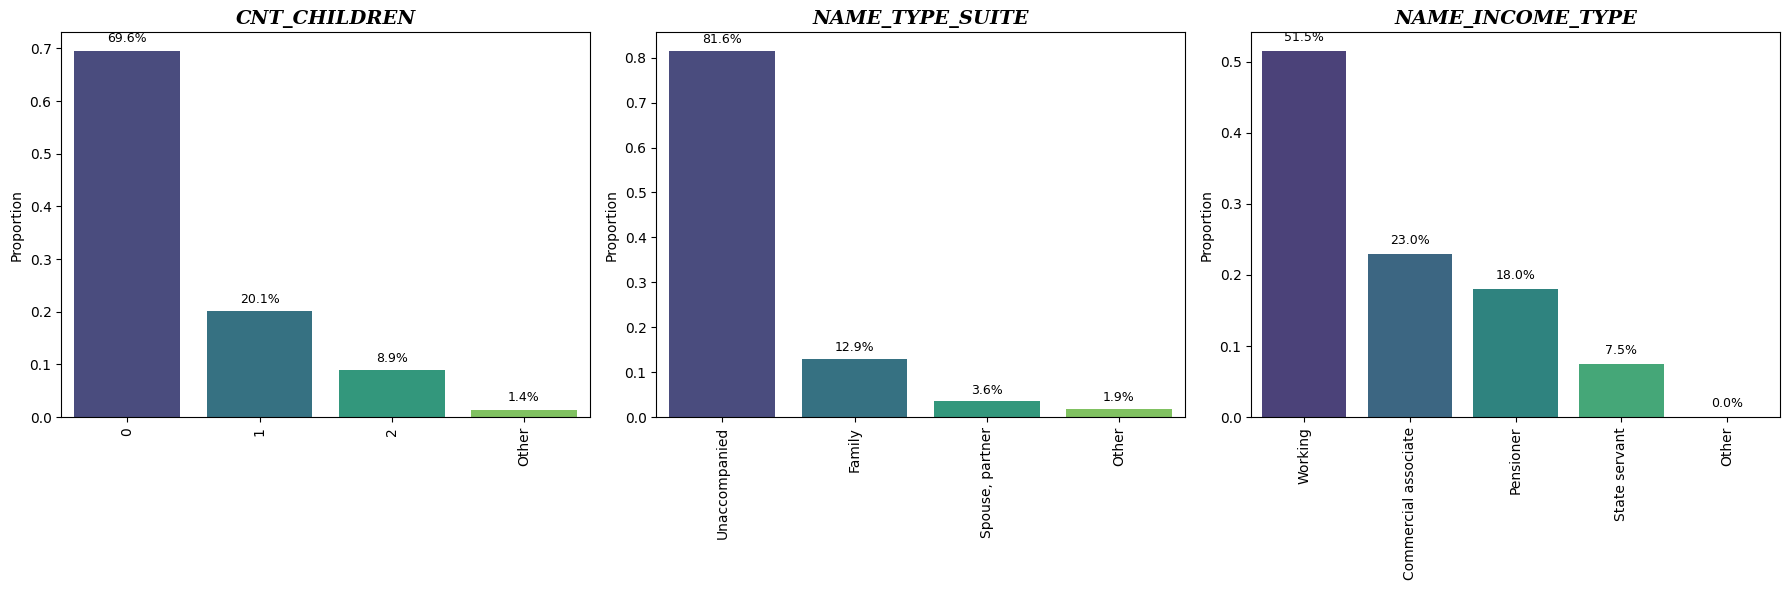

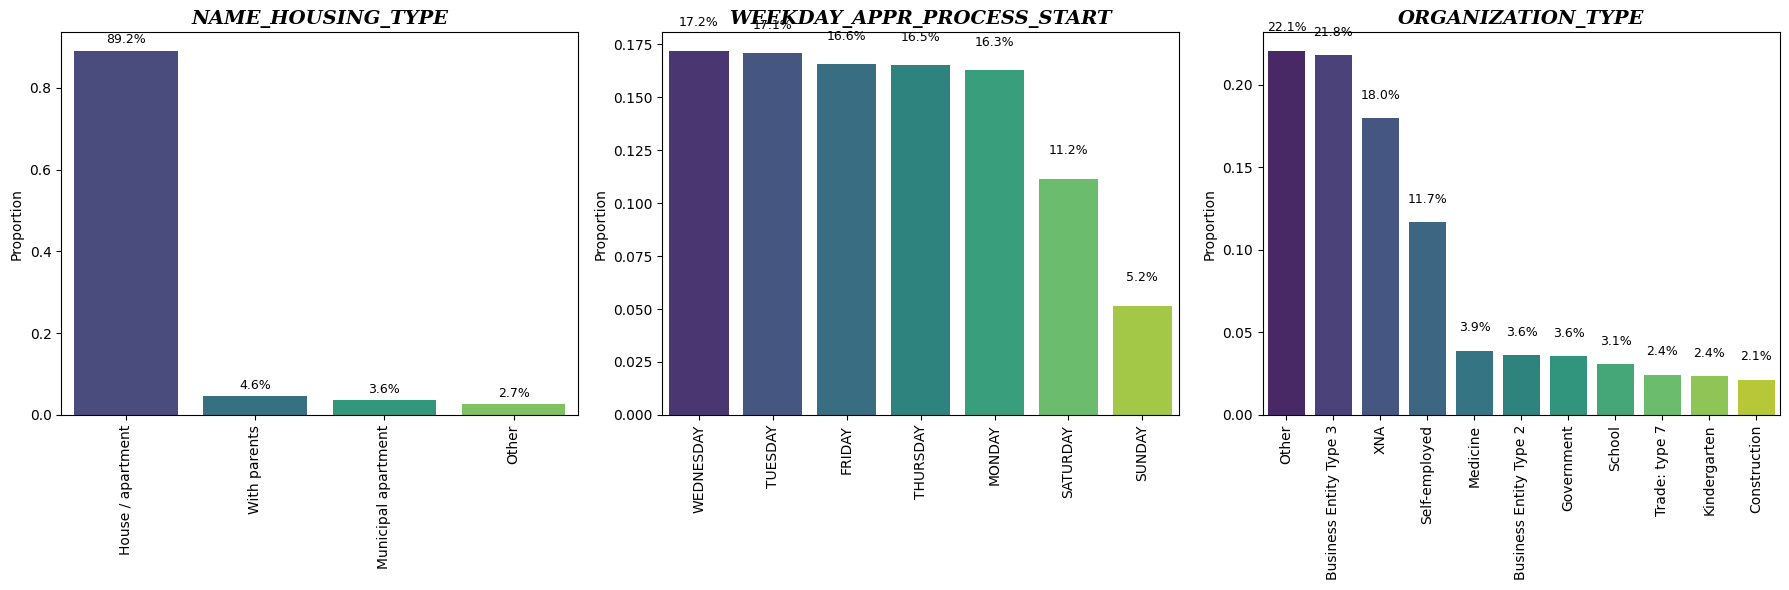

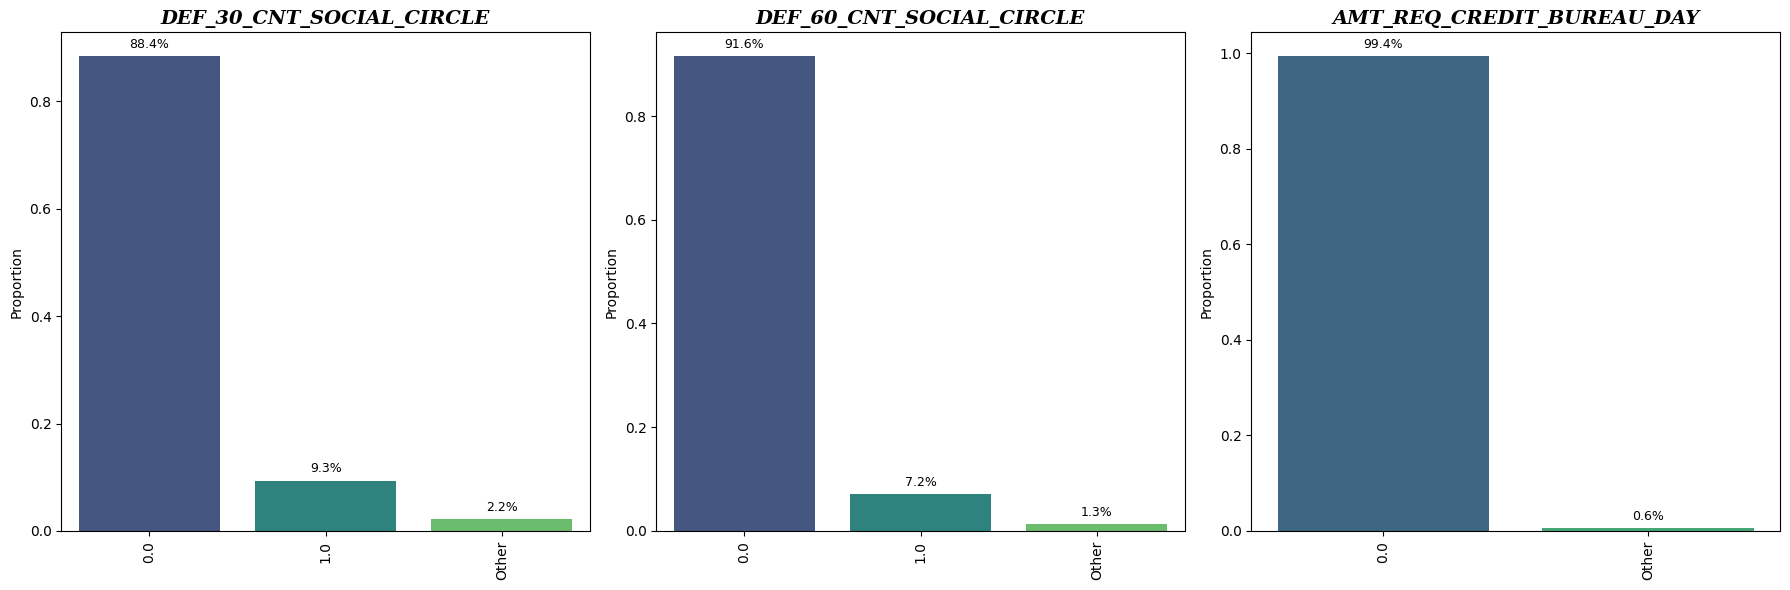

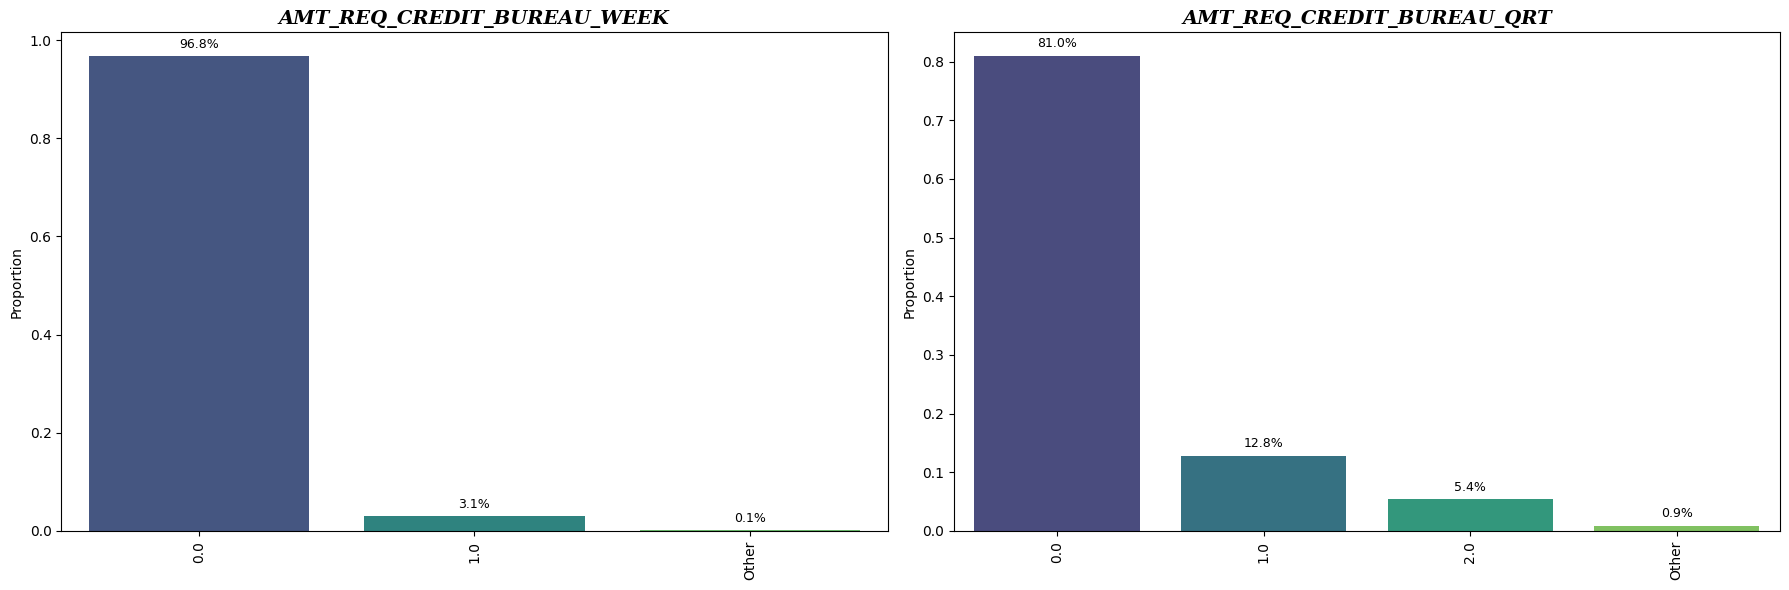

In [118]:
plot_categorical_bar(app_data_clean, app_categorical_columns_extra)

**Insights**

---

- Most of clients don't have children
- Most of clients apply for the loan alone then with family in 2nd propotion.
- nearly half of the clients are working in a standard job with fixed income.
- Most of clients have privately owned apartment or flat (~90%)
- (~90%) of clients don't have any defaults in thrier social netwrok in the last 60 days

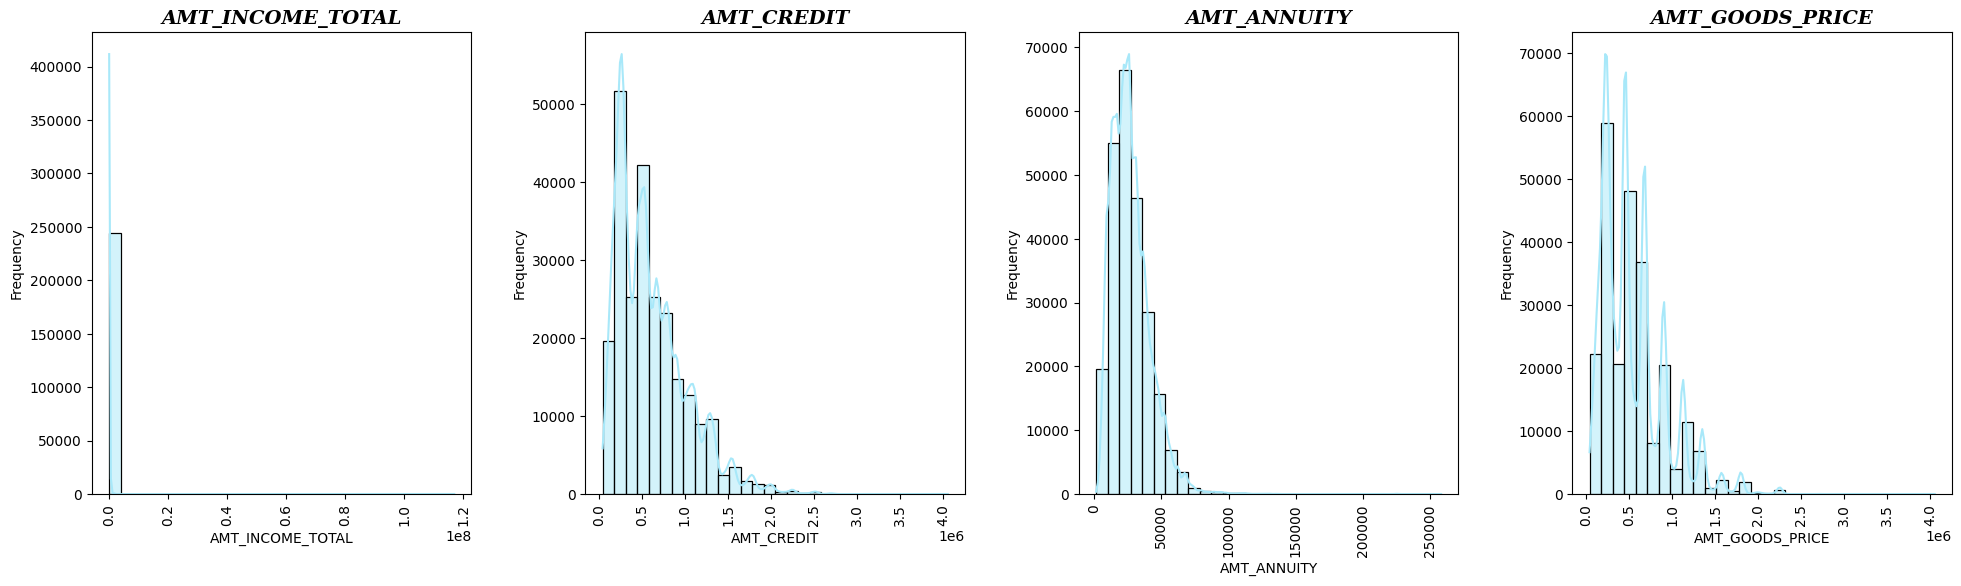

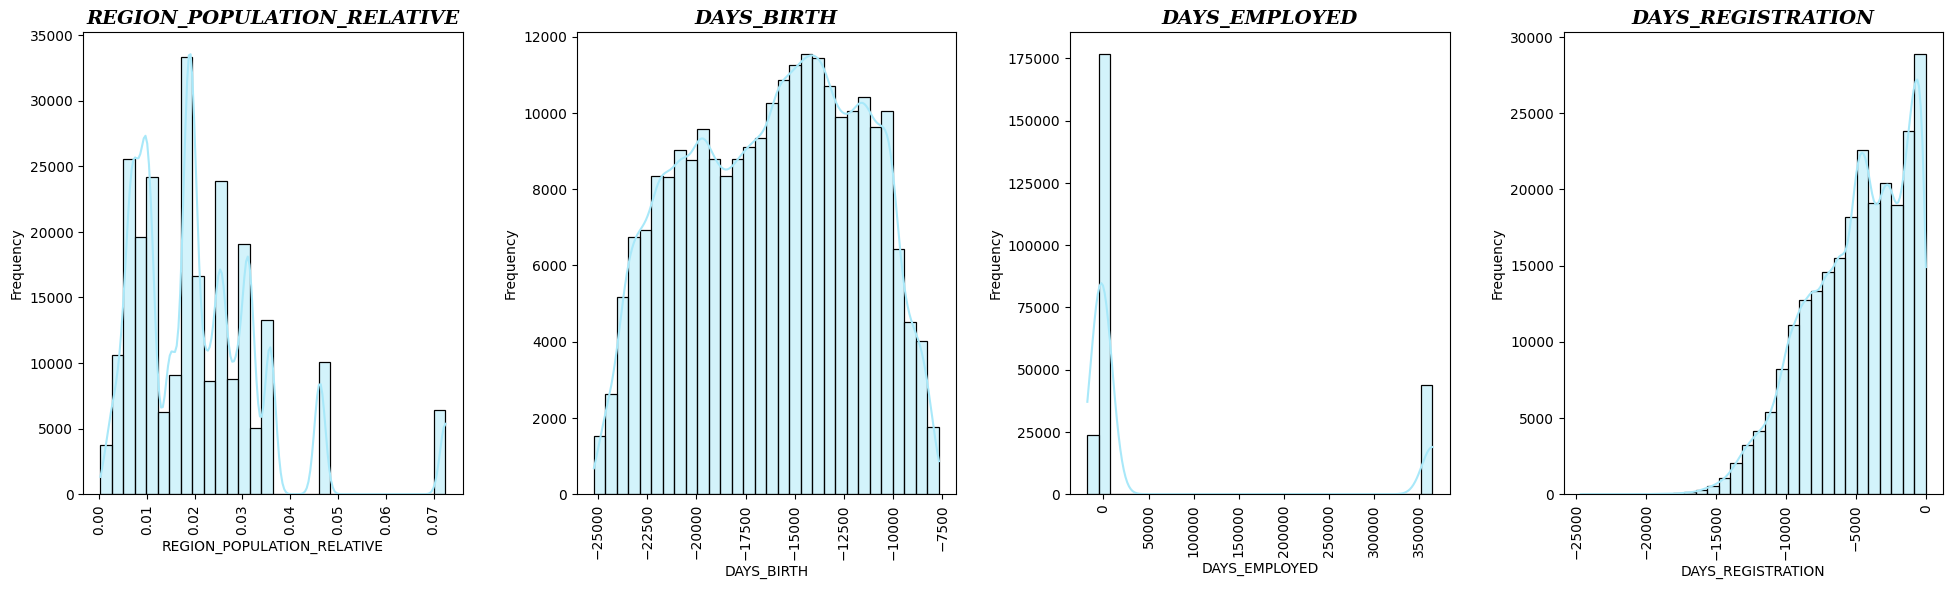

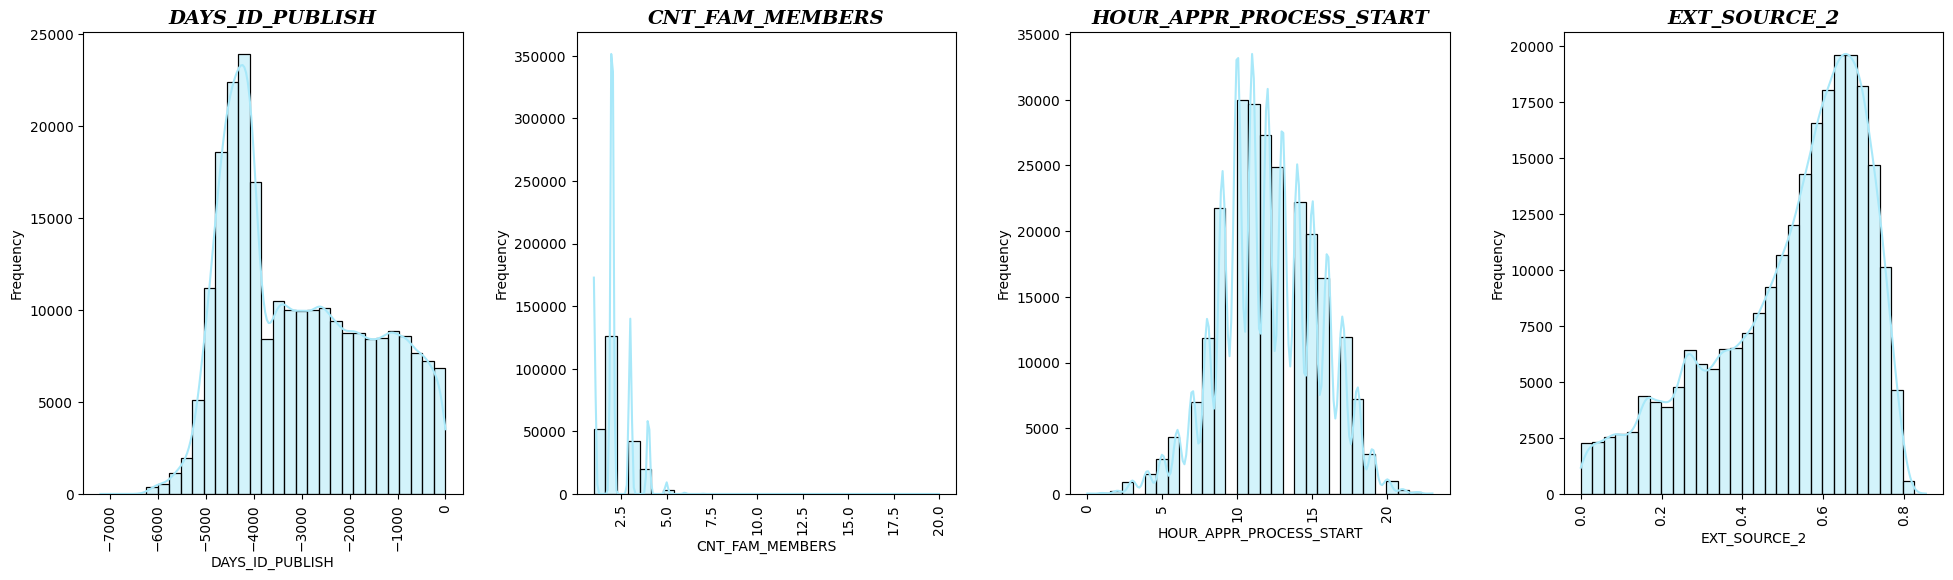

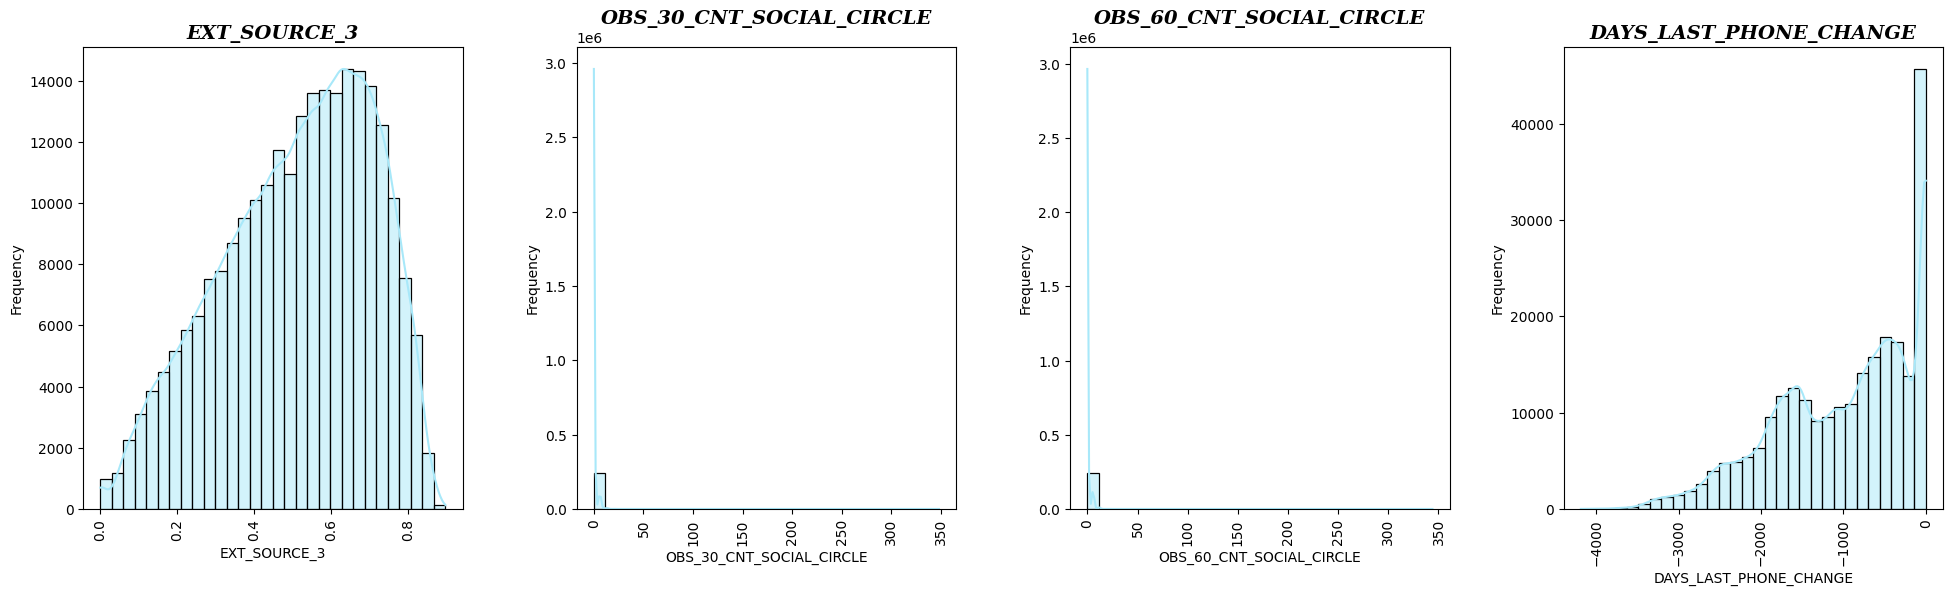

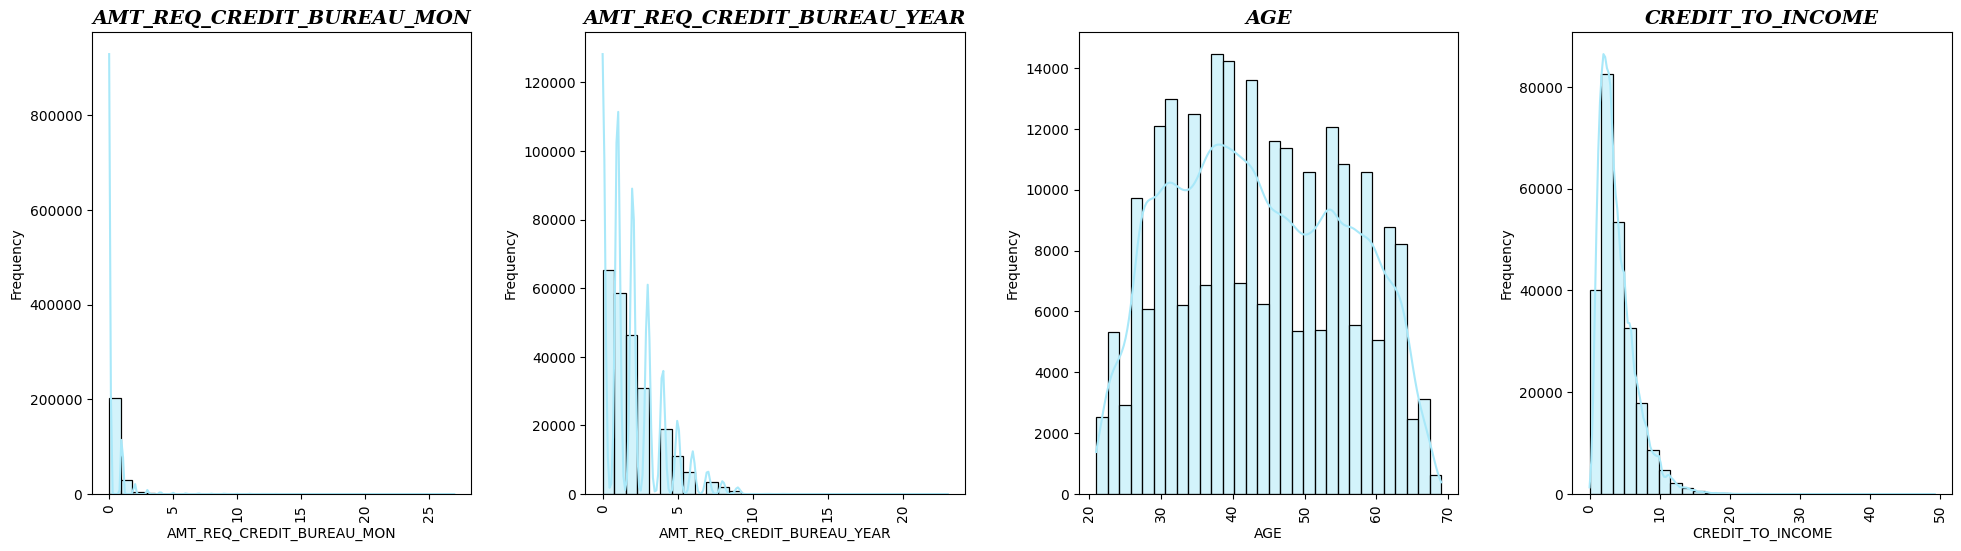

In [119]:
app_continuous_columns = [col for col in app_continuous_columns if col != "SK_ID_CURR"]
plot_continous_hist(app_data_clean, columns=app_continuous_columns)

Outliers percentage:
AMT_INCOME_TOTAL    4.806779
dtype: float64%
shape after outliers removal (232538, 76)
Outliers percentage:
AMT_CREDIT    1.663814
dtype: float64%
shape after outliers removal (228669, 76)
Outliers percentage:
AMT_ANNUITY    1.55115
dtype: float64%
shape after outliers removal (225122, 76)
Outliers percentage:
CNT_FAM_MEMBERS    1.305514
dtype: float64%
shape after outliers removal (222183, 76)
Outliers percentage:
OBS_30_CNT_SOCIAL_CIRCLE    6.657575
dtype: float64%
shape after outliers removal (207391, 76)
Outliers percentage:
OBS_60_CNT_SOCIAL_CIRCLE    0.0
dtype: float64%
shape after outliers removal (207391, 76)
Outliers percentage:
AMT_REQ_CREDIT_BUREAU_MON    16.308326
dtype: float64%
shape after outliers removal (173569, 76)
Outliers percentage:
AMT_REQ_CREDIT_BUREAU_YEAR    1.242157
dtype: float64%
shape after outliers removal (171413, 76)


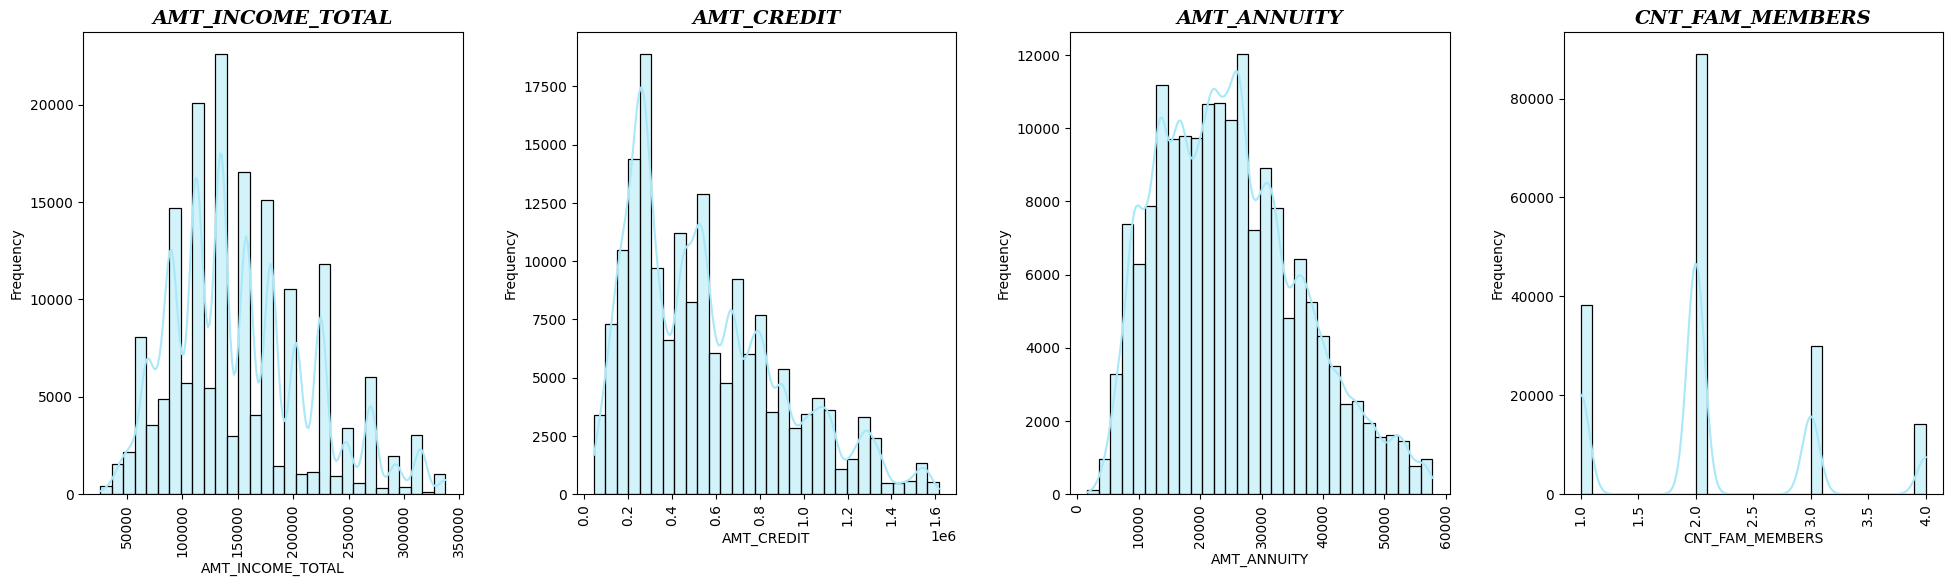

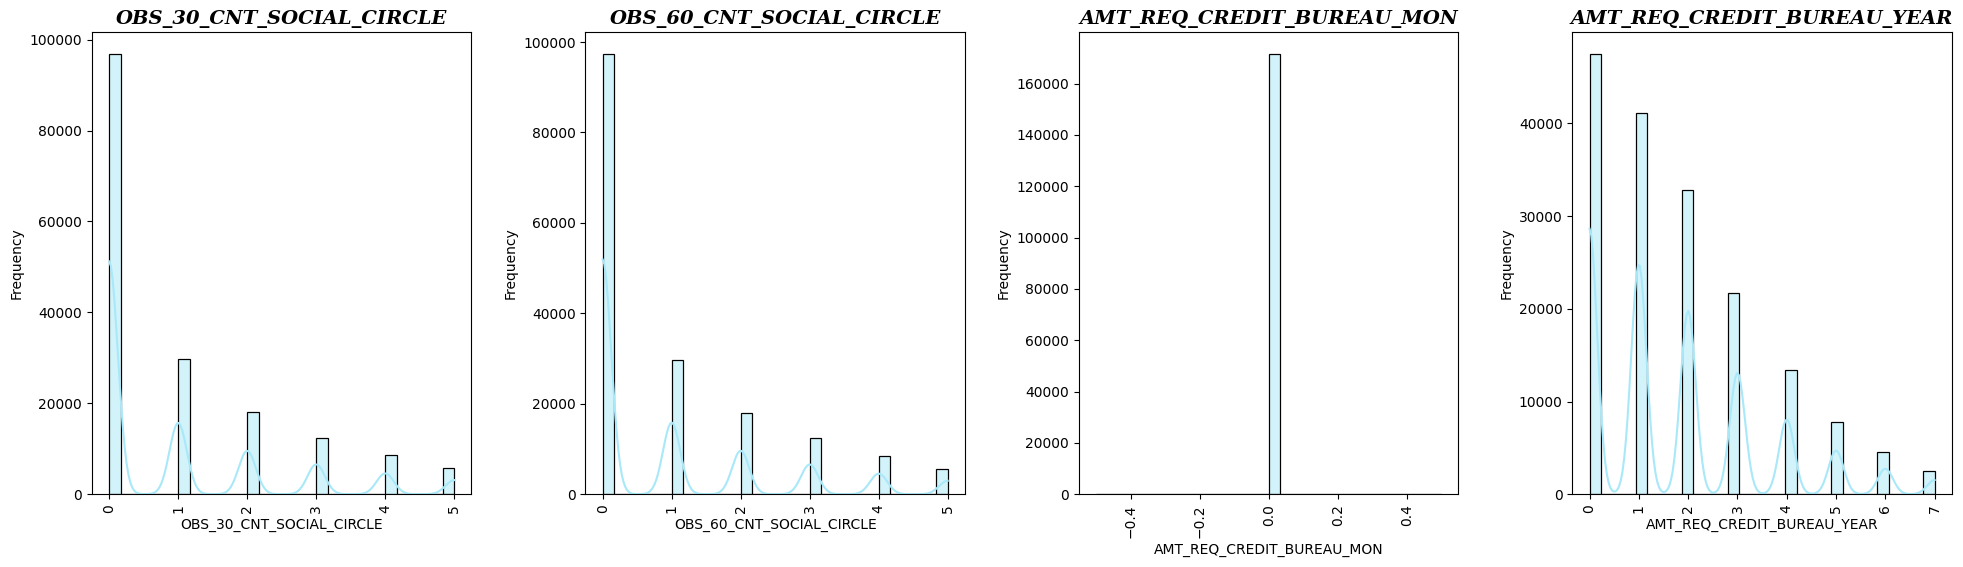

In [120]:
columns_with_outliers = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "CNT_FAM_MEMBERS", "OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_YEAR"]
app_data_clean_copy = app_data_clean.copy()
for col in columns_with_outliers:
    check_outliers(app_data_clean_copy, [col])
    app_data_clean_copy = remove_outliers(app_data_clean_copy, [col])
plot_continous_hist(app_data_clean_copy, columns=columns_with_outliers)

**Insights**

---

- Most of clients changed their phone before the application by 125 days.

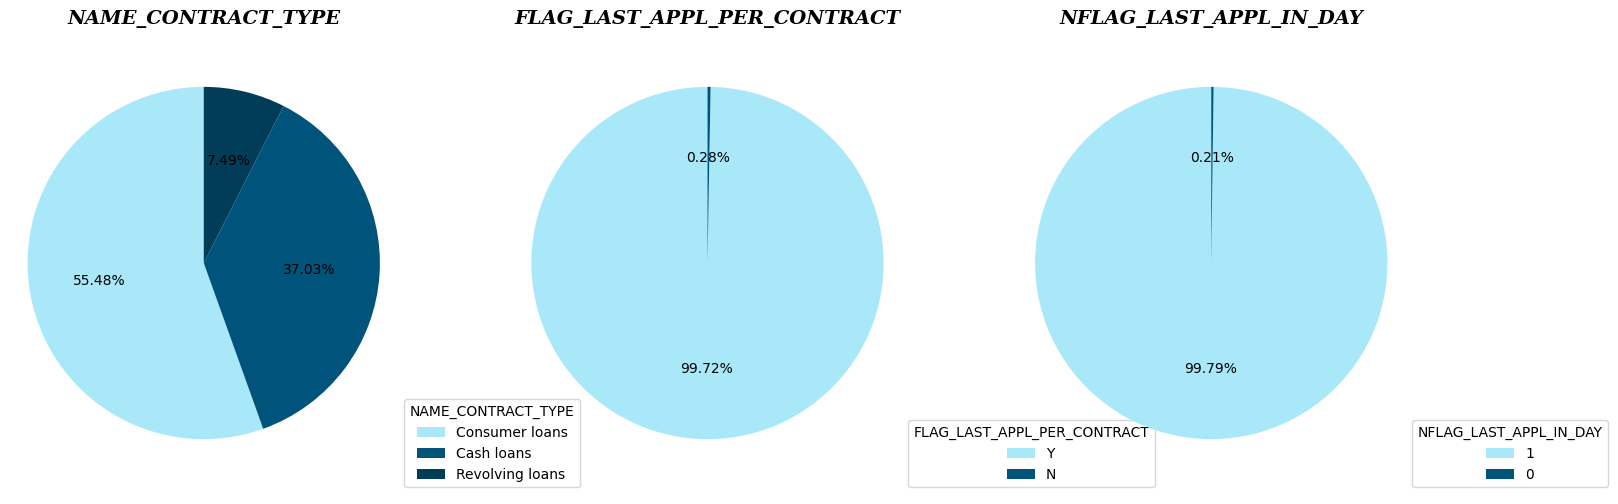

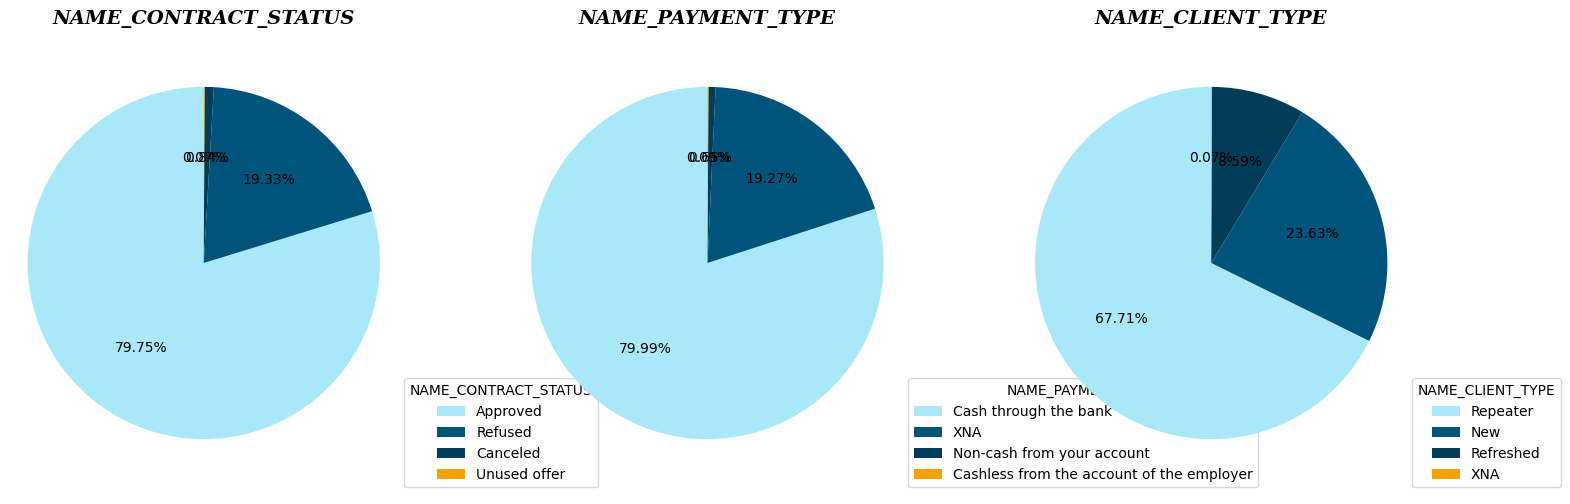

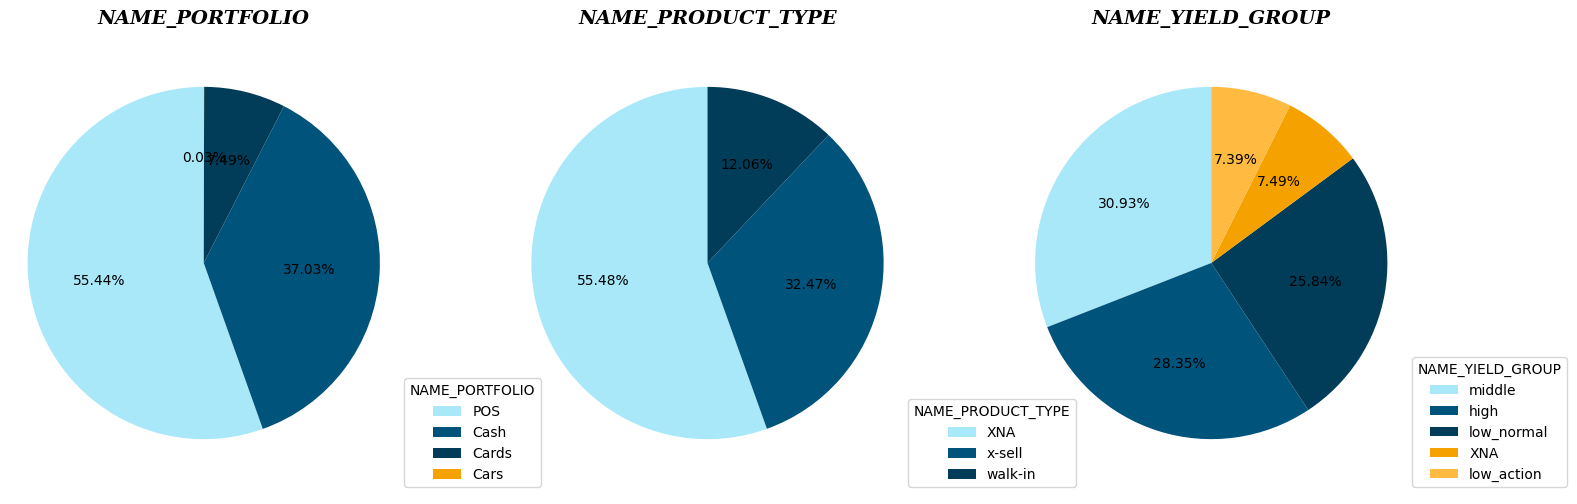

In [121]:
plot_categorical_pie(prev_data_clean, prev_categorical_columns)

**Insights**

---

- Most of contracts are (consumer/cash) loans
- 80% of payments are cash throught the bank.
- ~70% of clients are repeaters

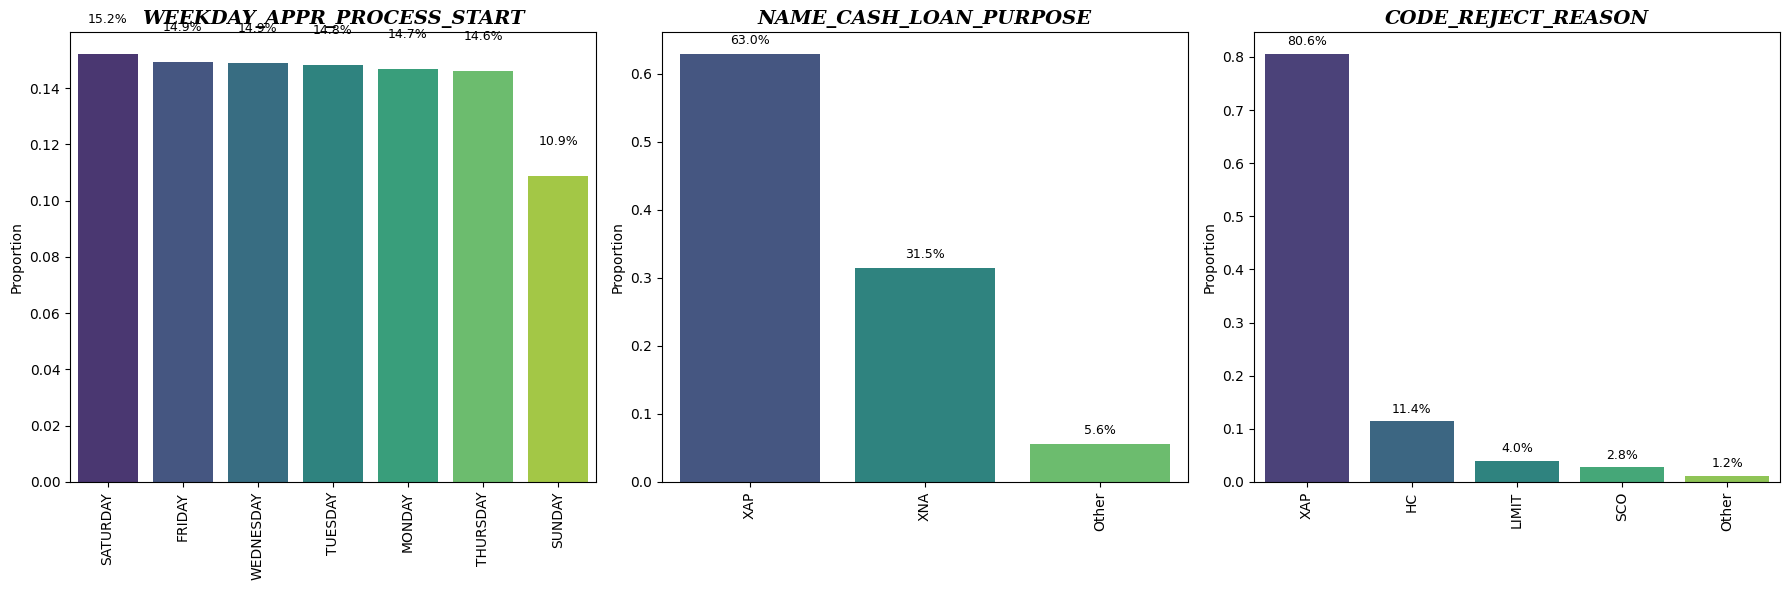

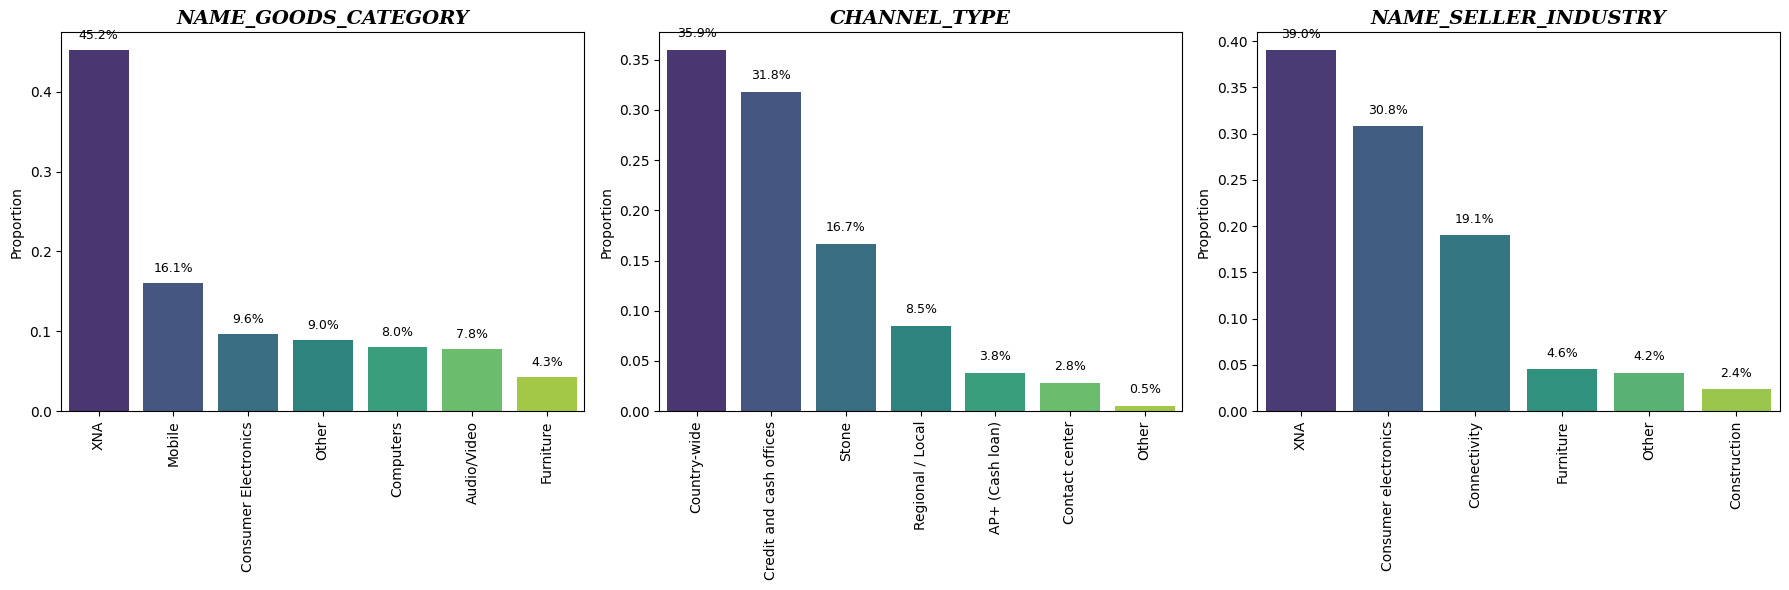

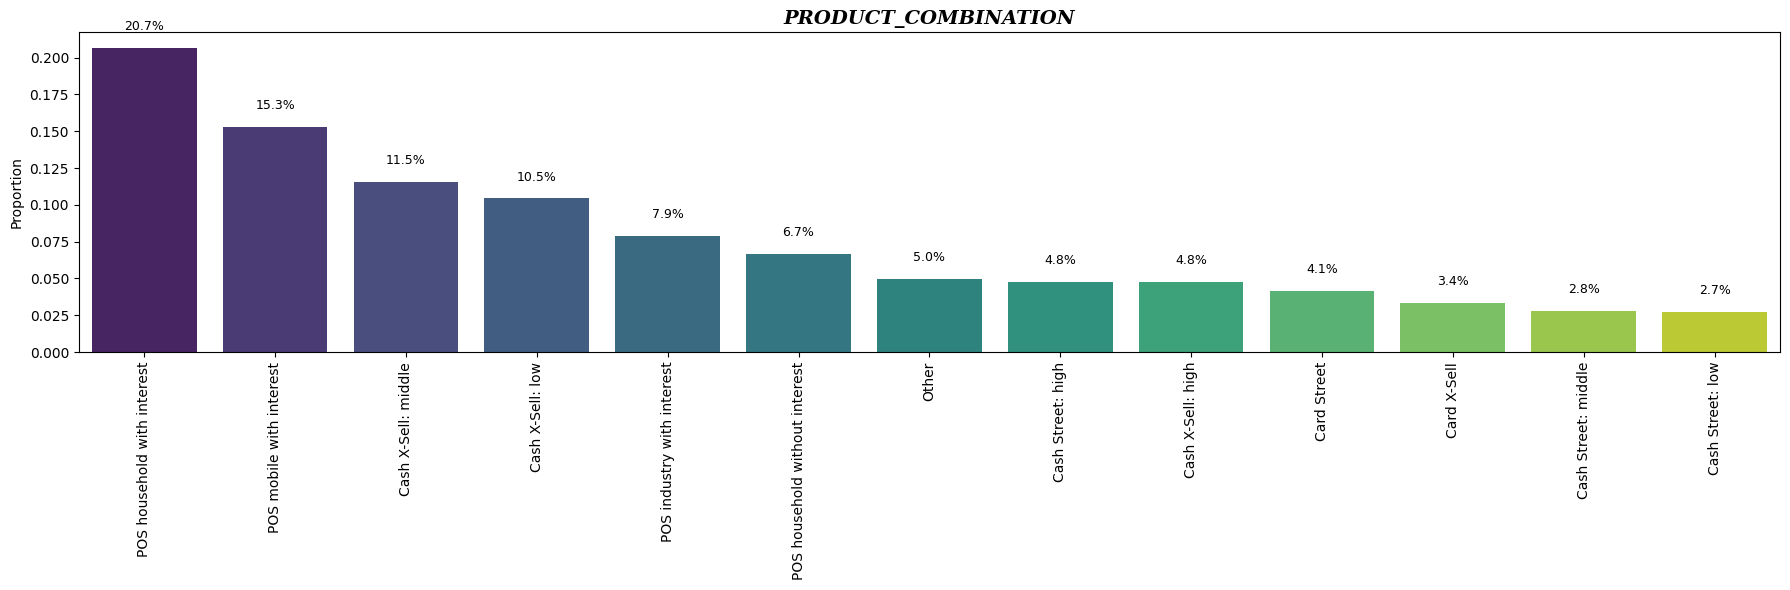

In [122]:
plot_categorical_bar(prev_data_clean, prev_categorical_columns_extra)

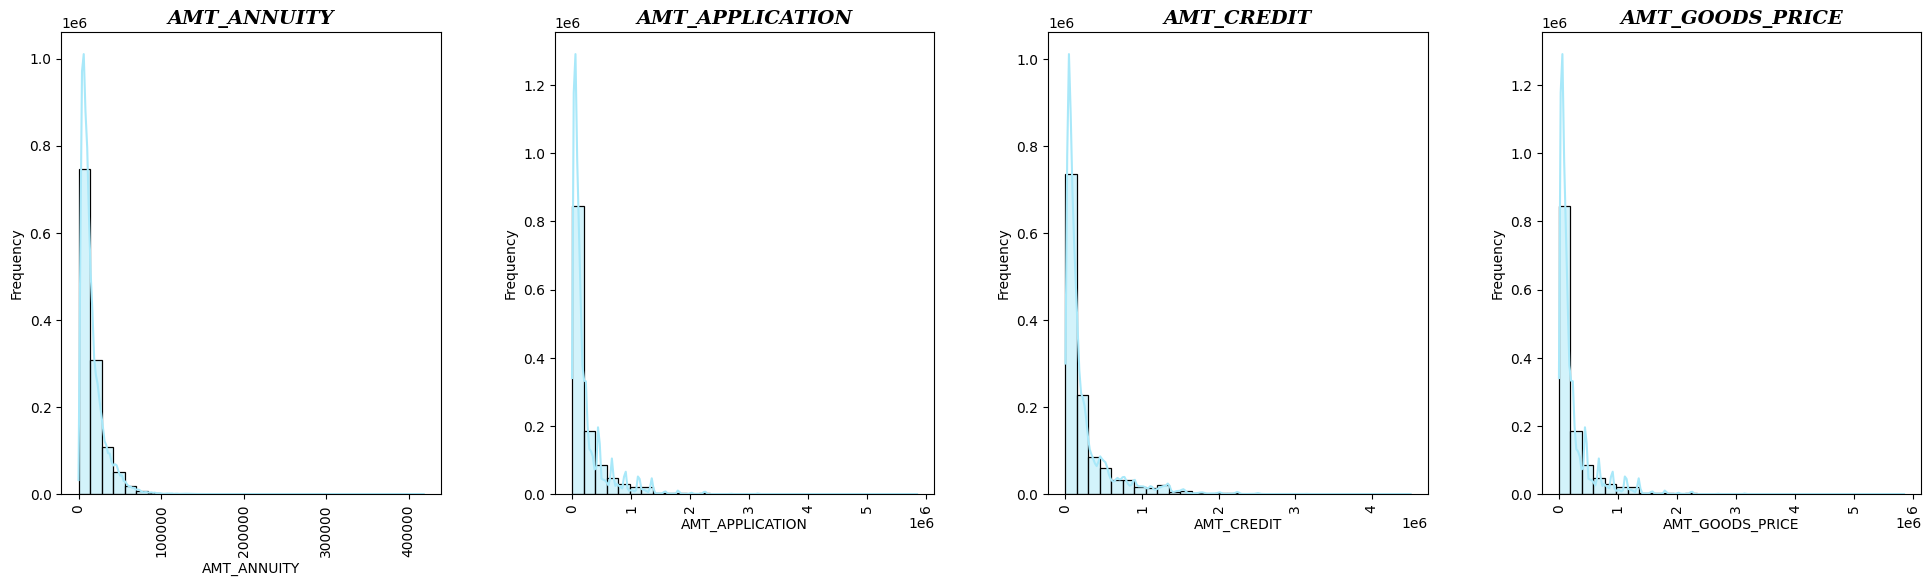

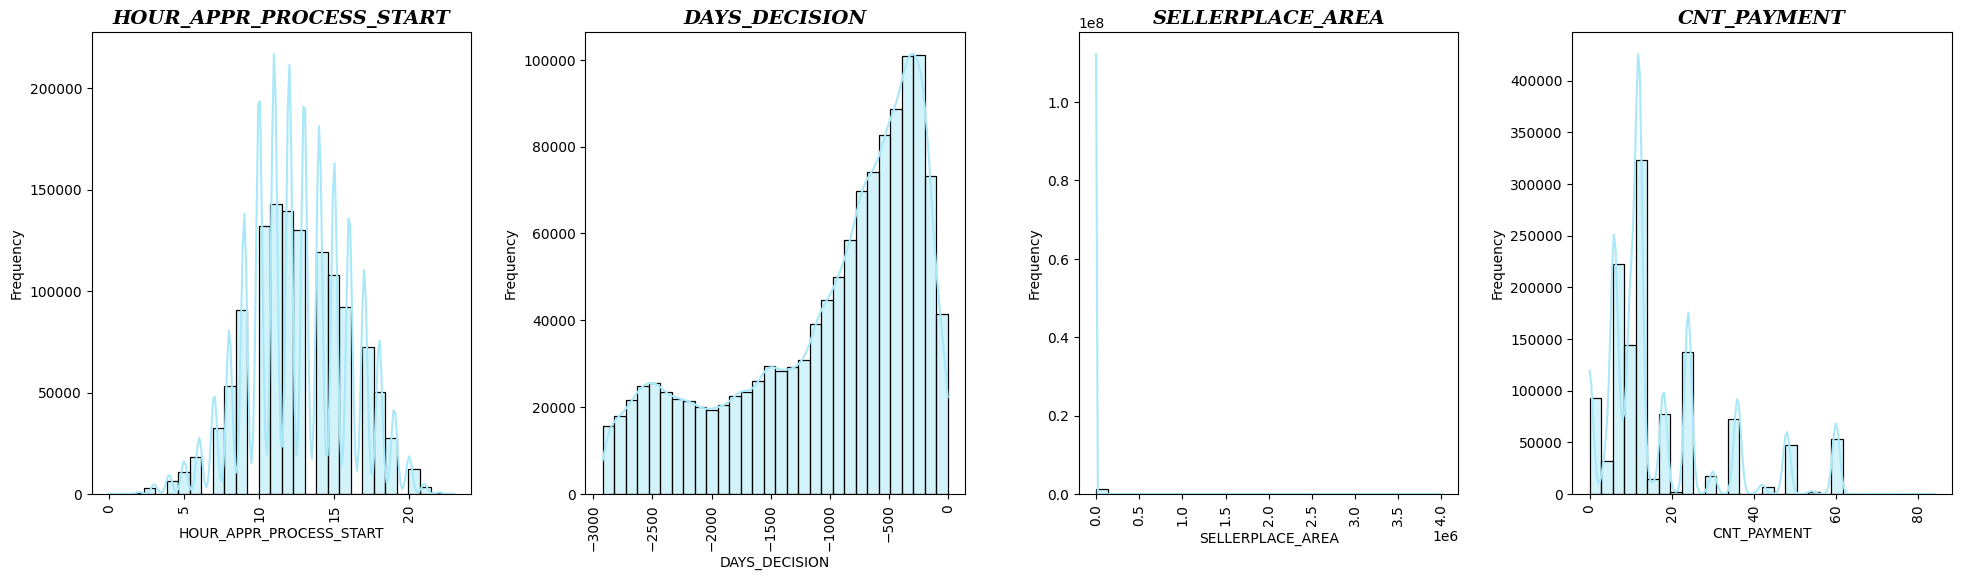

In [123]:
prev_continuous_columns = [col for col in prev_continuous_columns if col != "SK_ID_PREV" and col != "SK_ID_CURR"]
plot_continous_hist(prev_data_clean, prev_continuous_columns)

Outliers percentage:
AMT_ANNUITY    6.572309
dtype: float64%
shape after outliers removal (1164408, 26)
Outliers percentage:
AMT_APPLICATION    7.225904
dtype: float64%
shape after outliers removal (1080269, 26)
Outliers percentage:
AMT_CREDIT    6.735267
dtype: float64%
shape after outliers removal (1007510, 26)
Outliers percentage:
AMT_GOODS_PRICE    3.209199
dtype: float64%
shape after outliers removal (975177, 26)
Outliers percentage:
HOUR_APPR_PROCESS_START    0.054657
dtype: float64%
shape after outliers removal (974644, 26)
Outliers percentage:
DAYS_DECISION    0.0
dtype: float64%
shape after outliers removal (974644, 26)
Outliers percentage:
SELLERPLACE_AREA    18.511887
dtype: float64%
shape after outliers removal (794219, 26)
Outliers percentage:
CNT_PAYMENT    13.142471
dtype: float64%
shape after outliers removal (689839, 26)


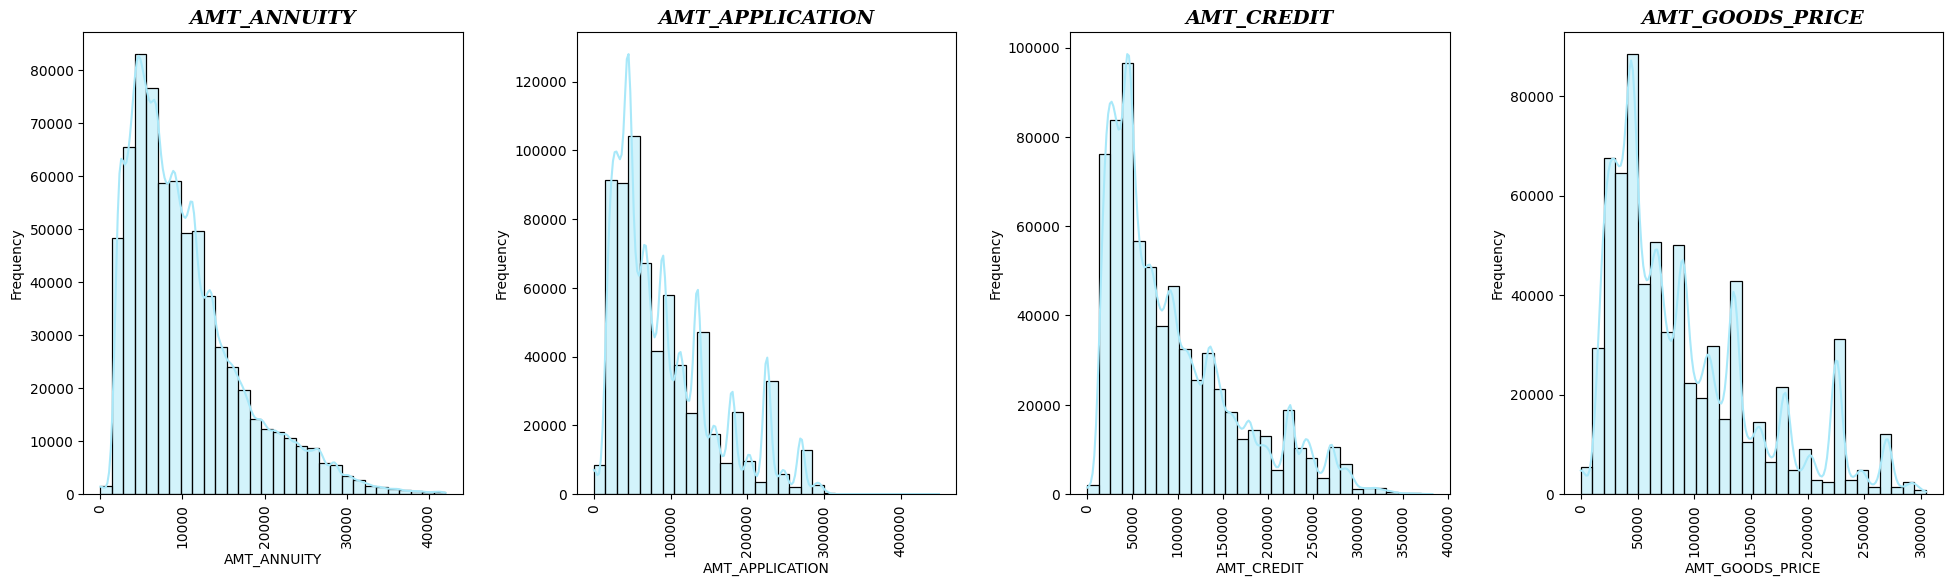

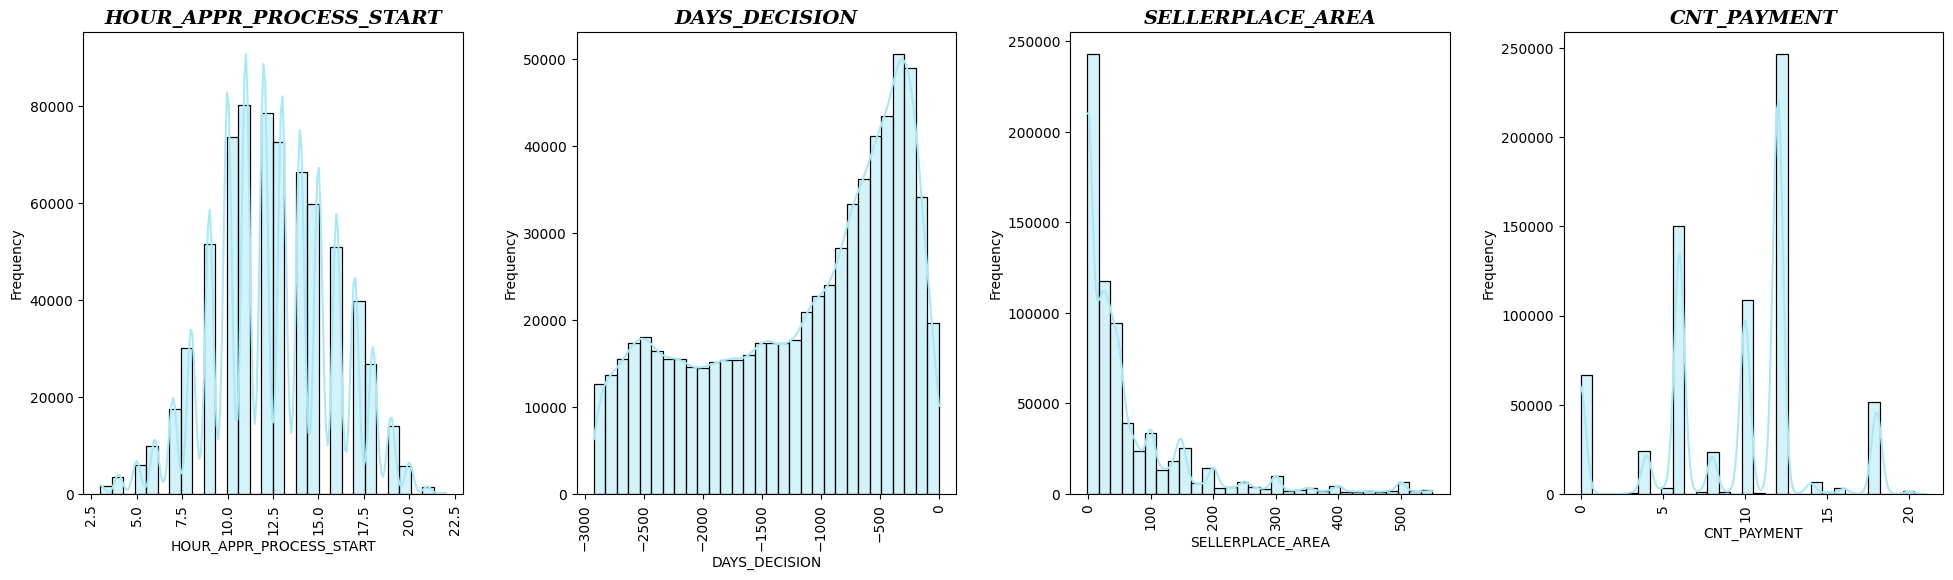

In [124]:
prev_data_clean_copy = prev_data_clean.copy()
for col in prev_continuous_columns:
    check_outliers(prev_data_clean_copy, [col])
    prev_data_clean_copy = remove_outliers(prev_data_clean_copy, [col])
plot_continous_hist(prev_data_clean_copy, prev_continuous_columns)

**Insights**

---

- Most of clients schedule loan repayment under 20 terms(ex. months).

### Other

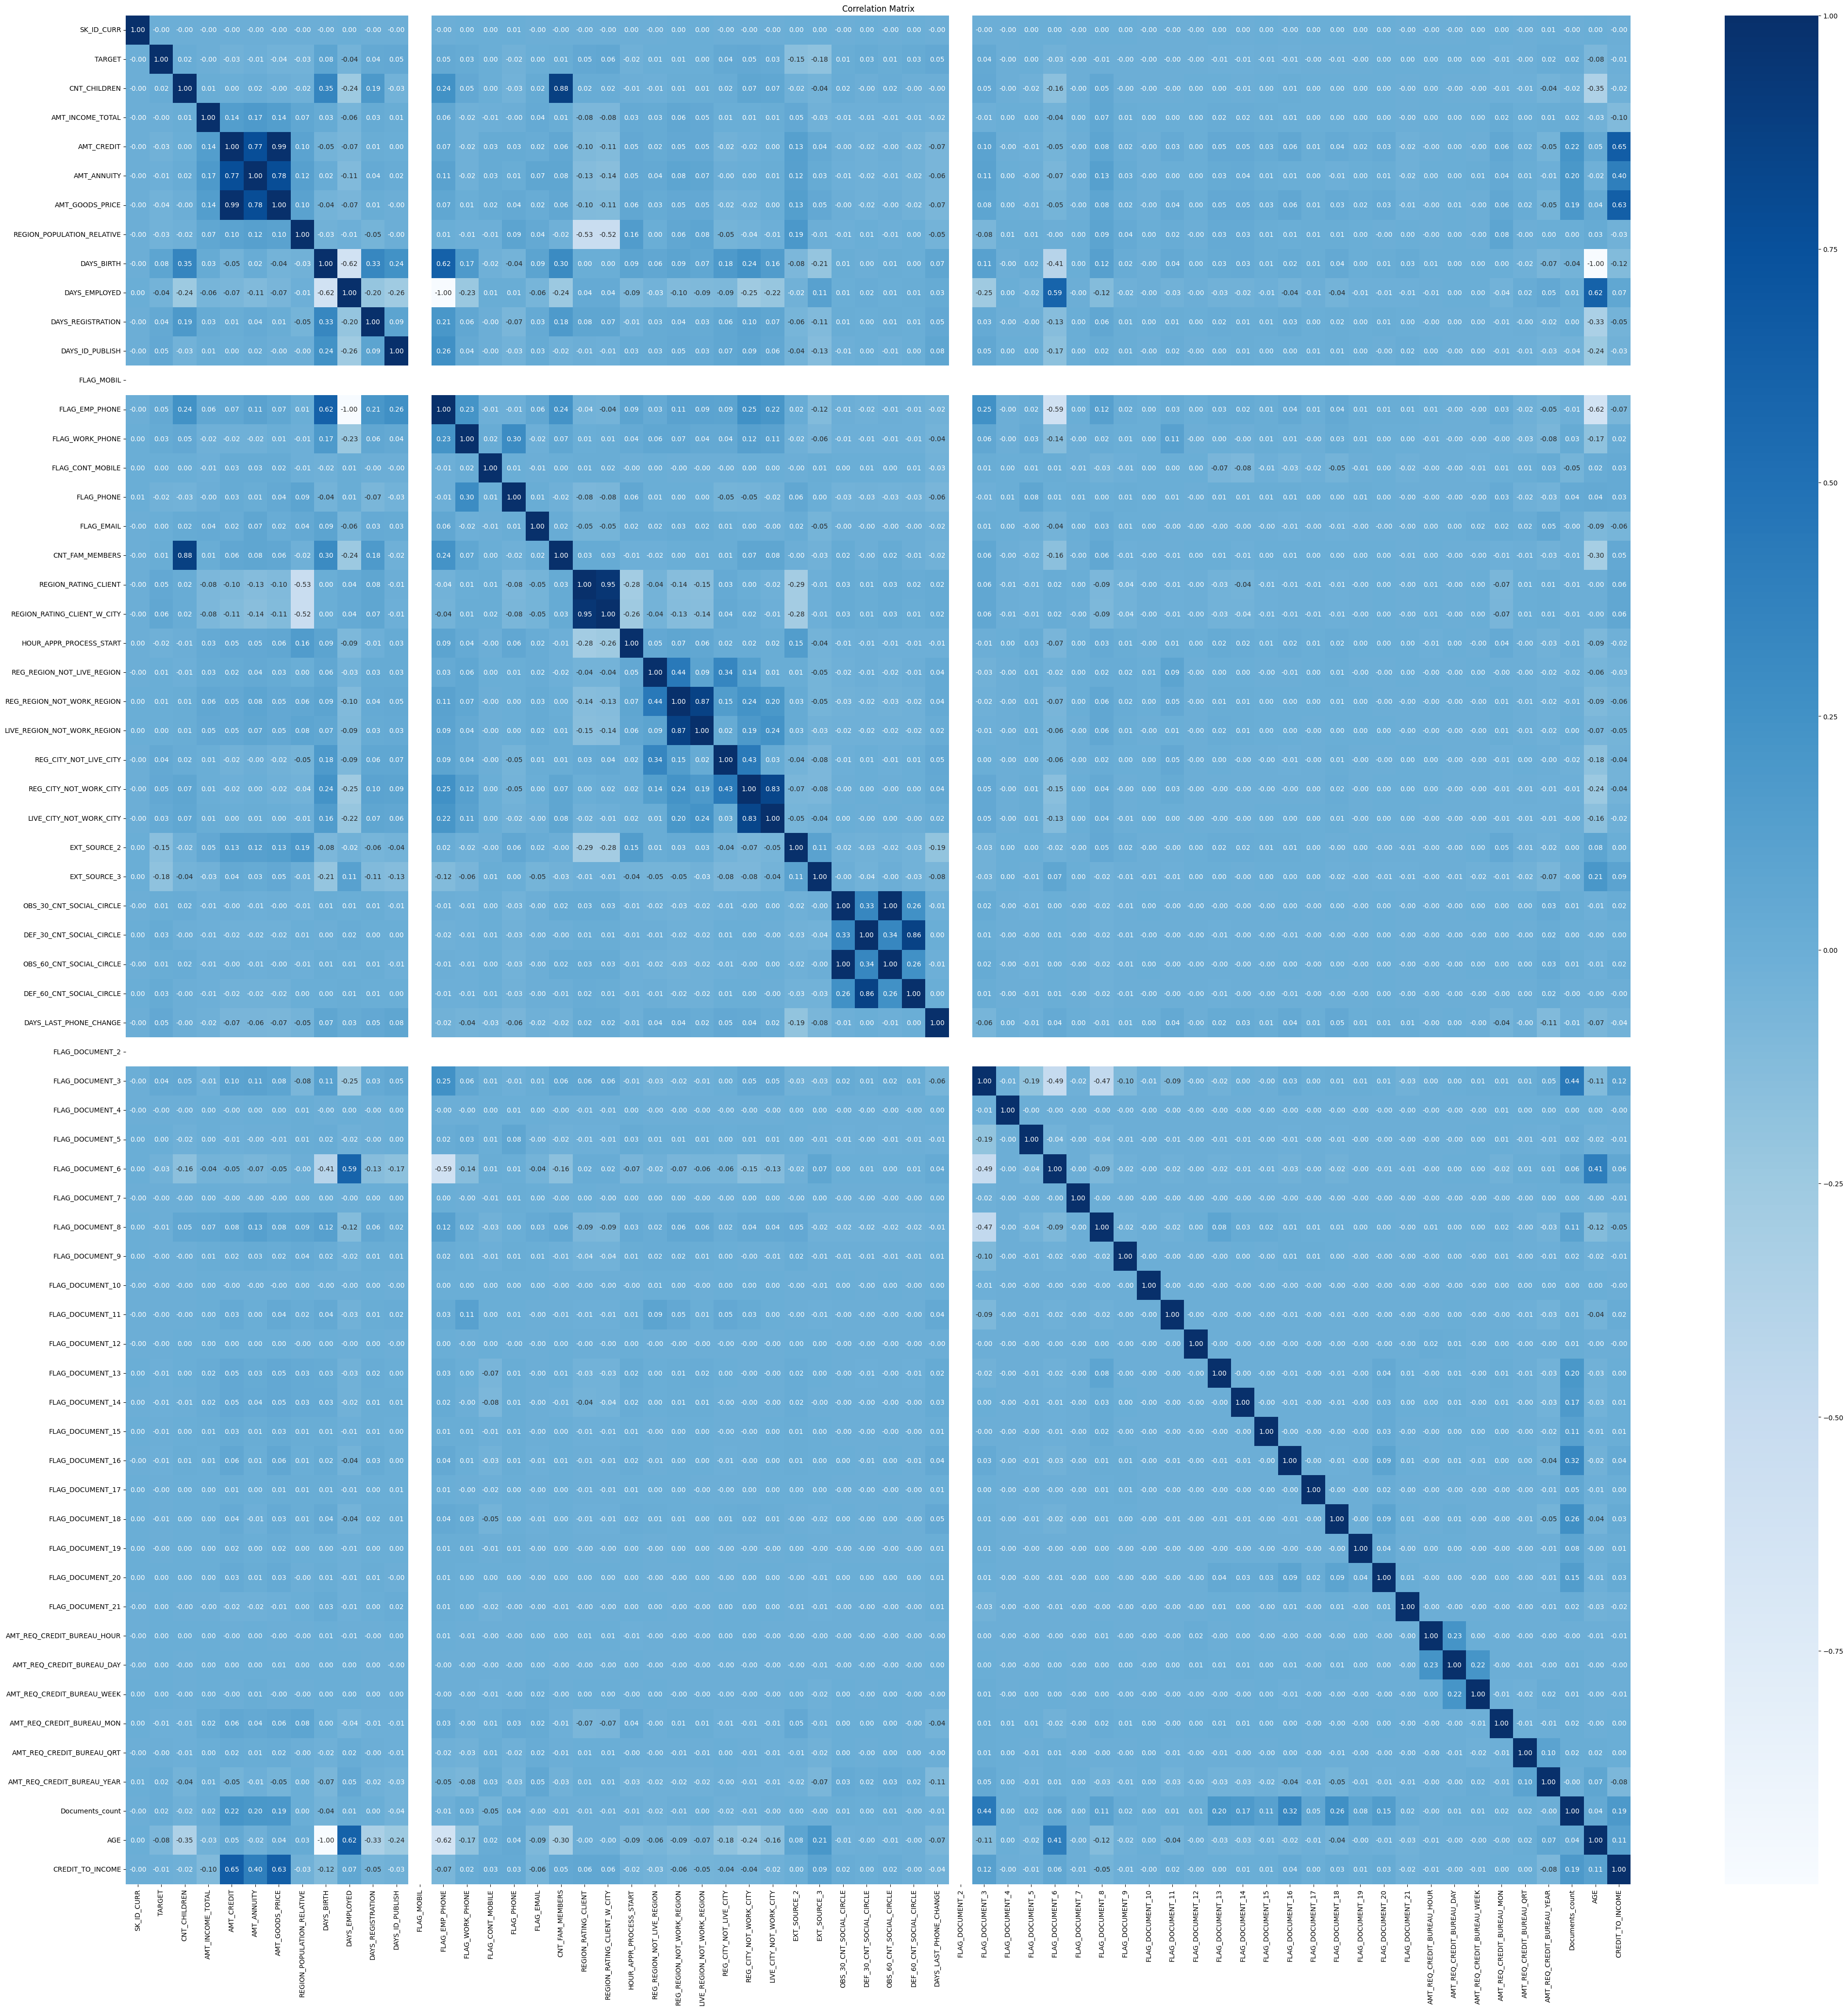

In [125]:
plot_correlation_matrix(app_data_clean)

## Insights

### (1) Total income

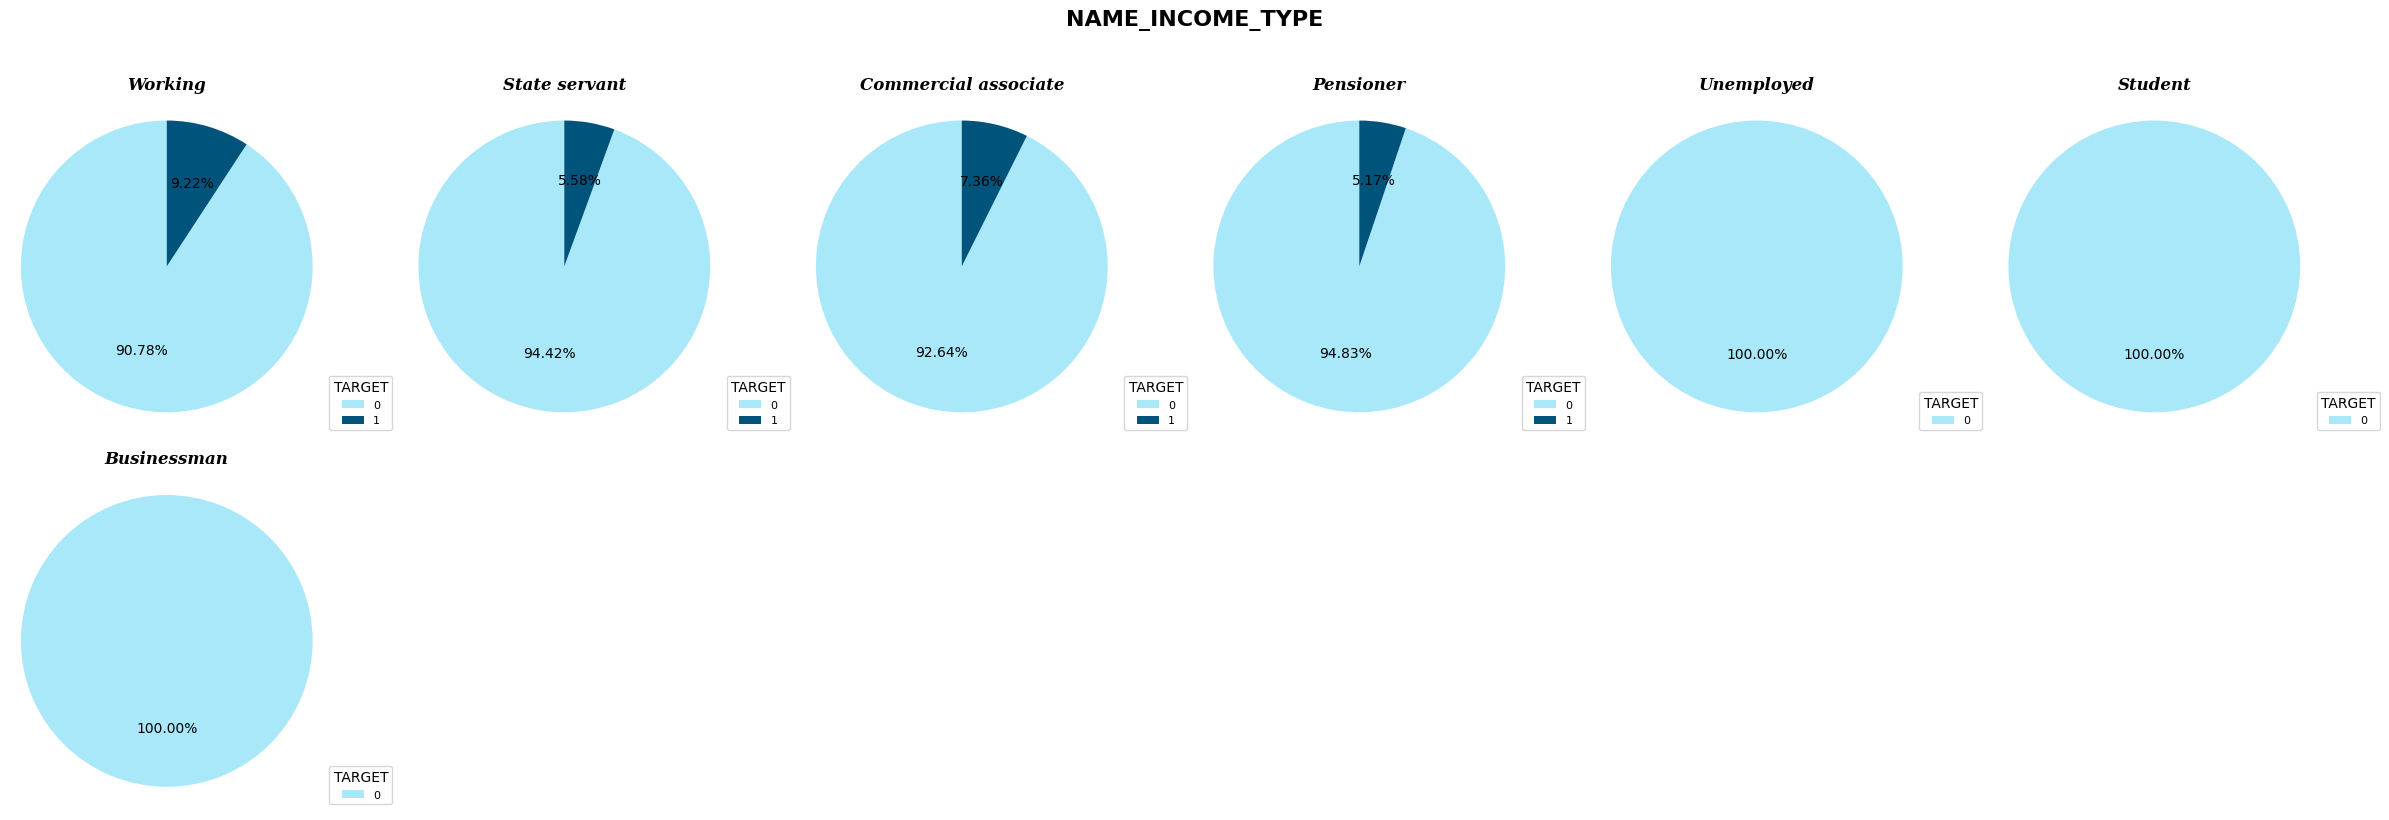

In [126]:
# income type - target
plot_bivariate_pie(app_data_clean, ["NAME_INCOME_TYPE"], "TARGET")

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


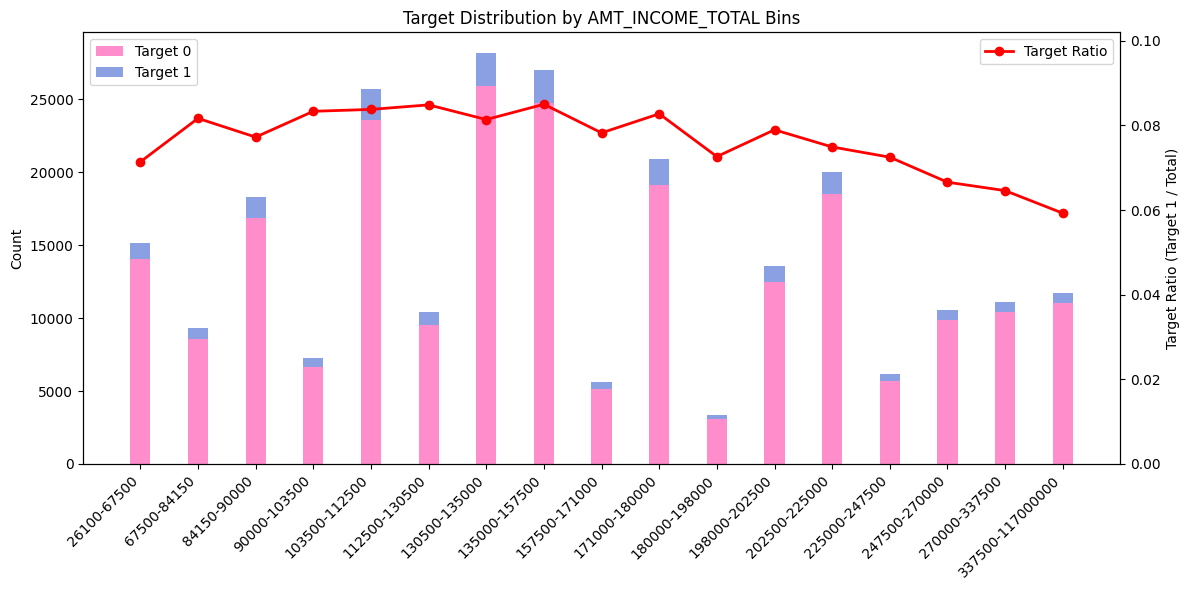

In [127]:
# total income - target
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'AMT_INCOME_TOTAL', target_column='TARGET', bins=20)

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


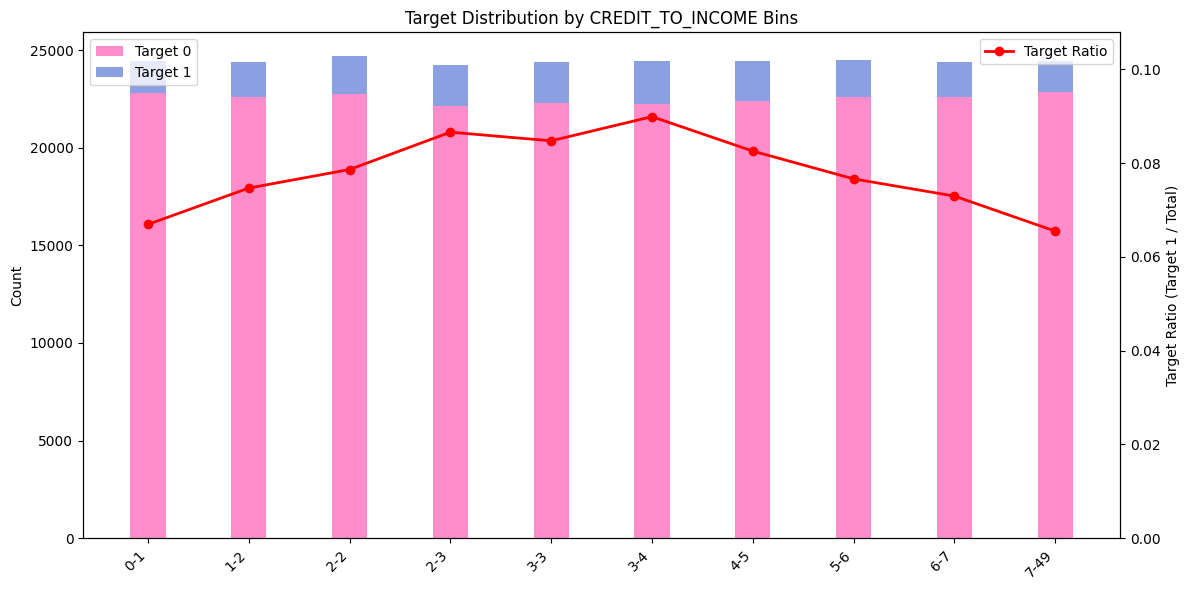

In [128]:
# credit-to-income ration - target
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'CREDIT_TO_INCOME', target_column='TARGET', bins=10)

Insights:

---

- clients that have a fixed income, or 

### (2) Credit Amount Risk

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


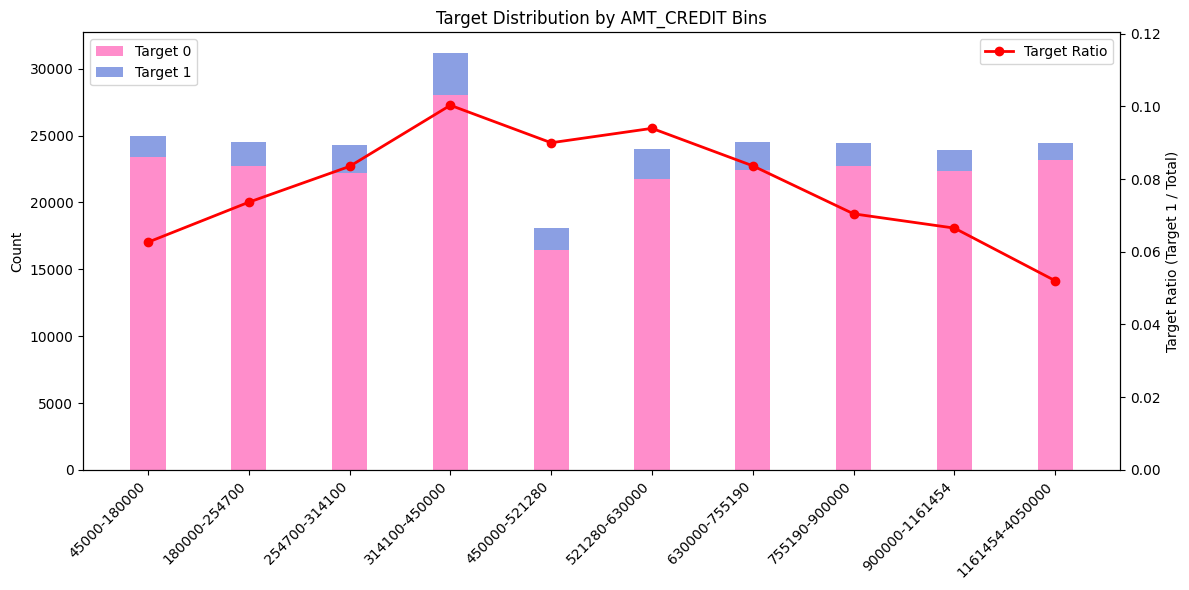

In [129]:
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'AMT_CREDIT', target_column='TARGET', bins=10)

### (3) Employment Stability

In [130]:
min_days_employed = app_data_clean["DAYS_EMPLOYED"].min()
max_days_employed = app_data_clean["DAYS_EMPLOYED"].max()

print("Minimum DAYS_EMPLOYED:", min_days_employed)
print("Maximum DAYS_EMPLOYED:", max_days_employed)

# Count how many have absurdly high values (e.g., > 100 years)
print((app_data_clean["DAYS_EMPLOYED"] > 365 * 100).sum())

# Get the top 2 largest values
top_2 = app_data_clean["DAYS_EMPLOYED"].nlargest(2)
print("Top 2 values:\n", top_2)

Minimum DAYS_EMPLOYED: -17912
Maximum DAYS_EMPLOYED: 365243
43909
Top 2 values:
 5    365243
7    365243
Name: DAYS_EMPLOYED, dtype: int64


/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


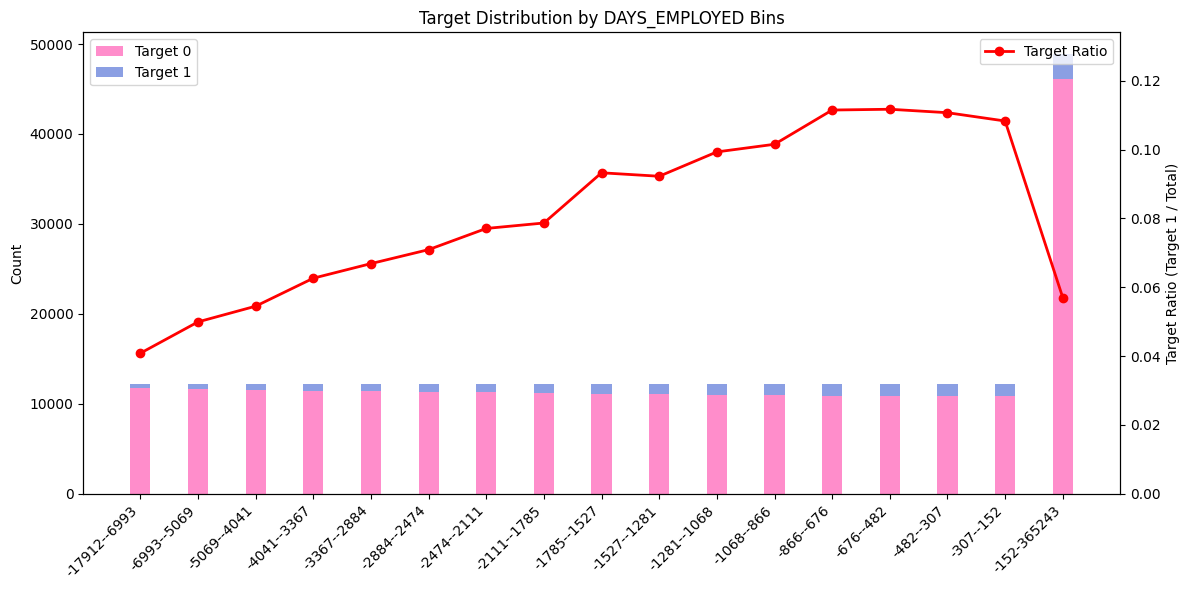

In [131]:
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'DAYS_EMPLOYED', target_column='TARGET', bins=20)

- The eariler the client has a job, the more defautls they may face

### (4) Job

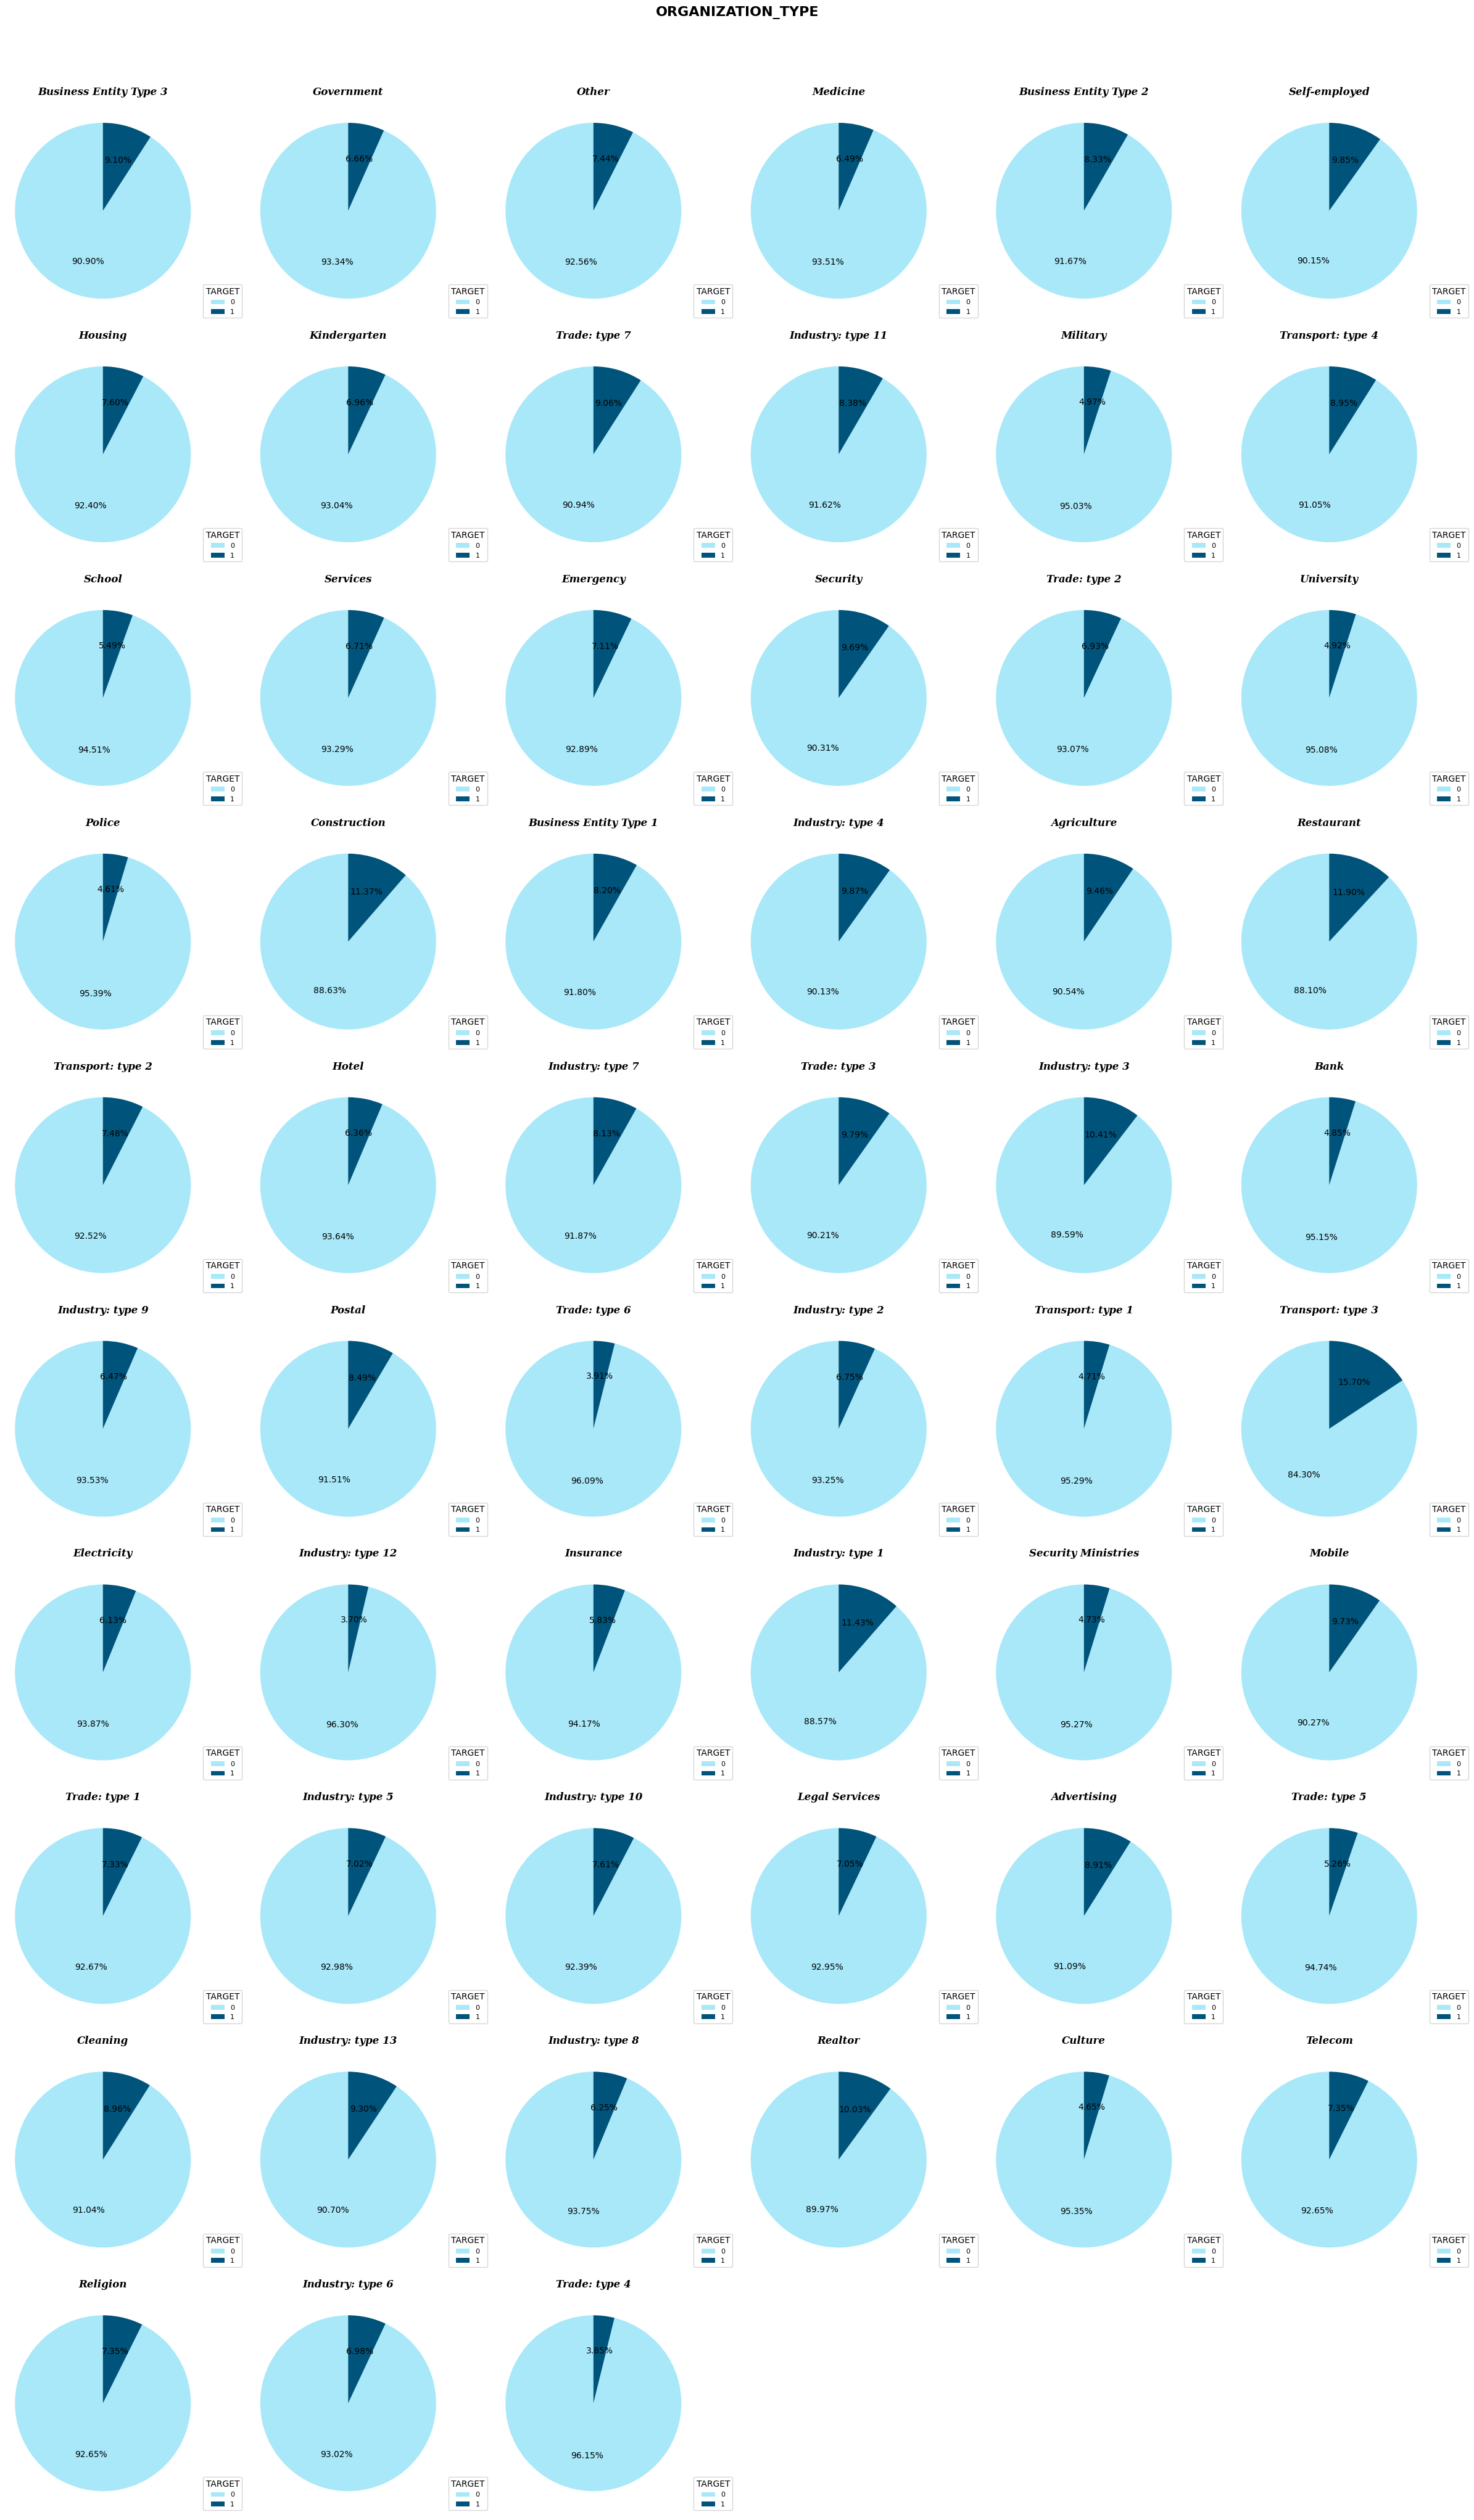

In [132]:
plot_bivariate_pie(app_data_clean, ["ORGANIZATION_TYPE"], "TARGET")

### (5) Client Demographics and Default

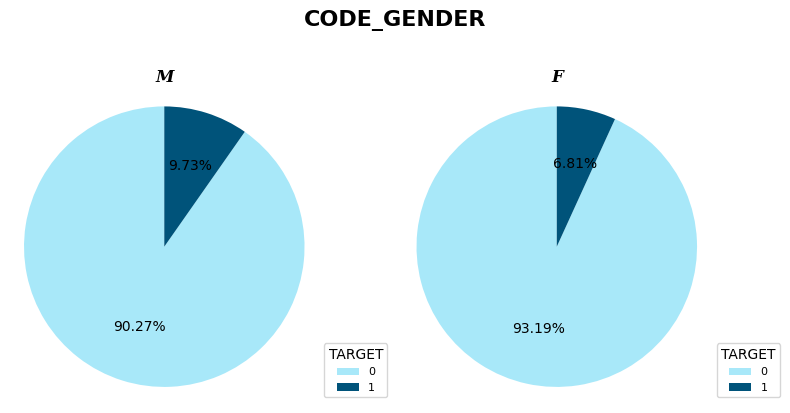

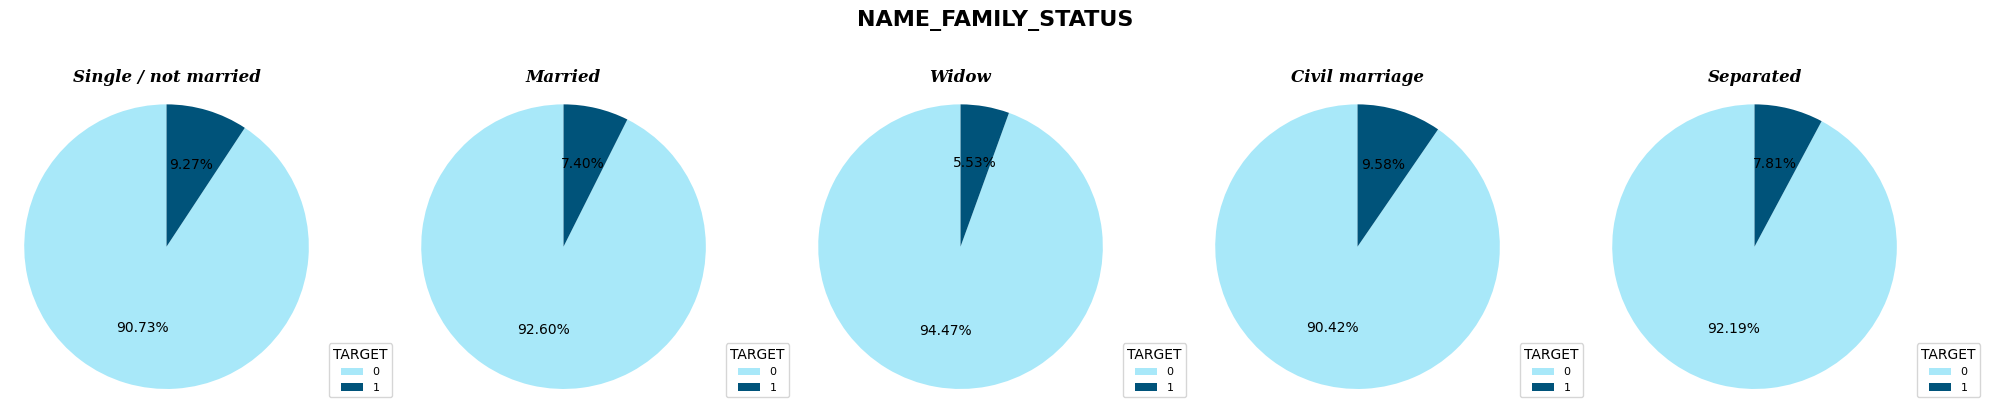

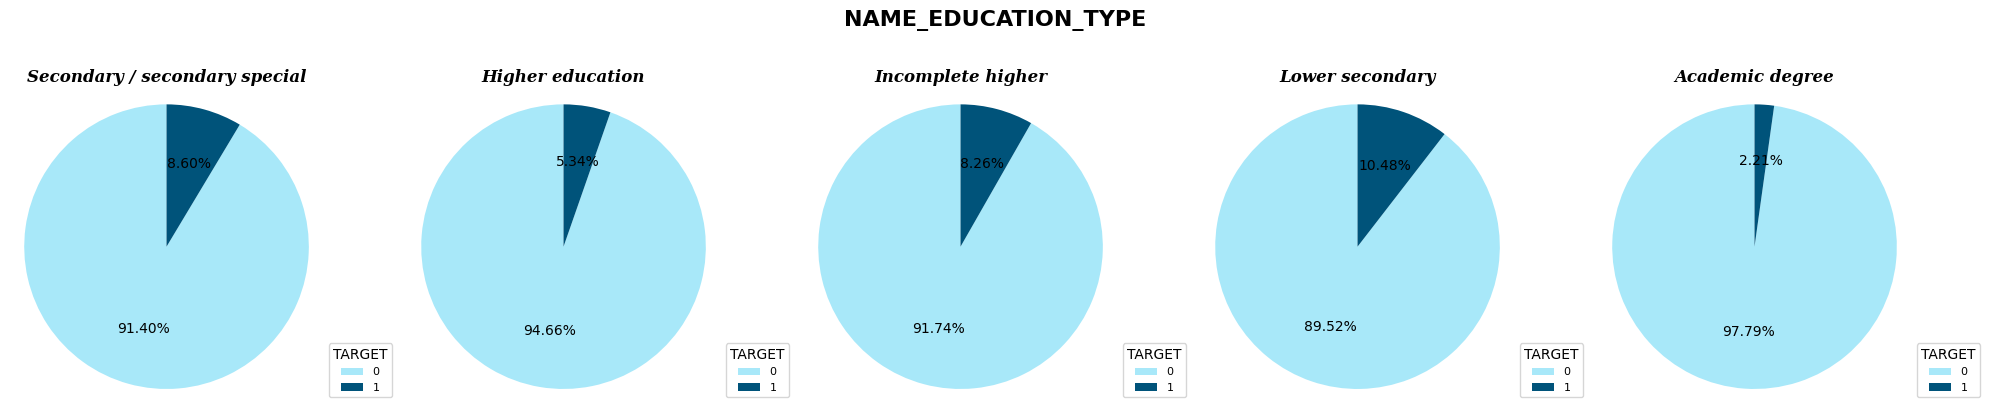

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


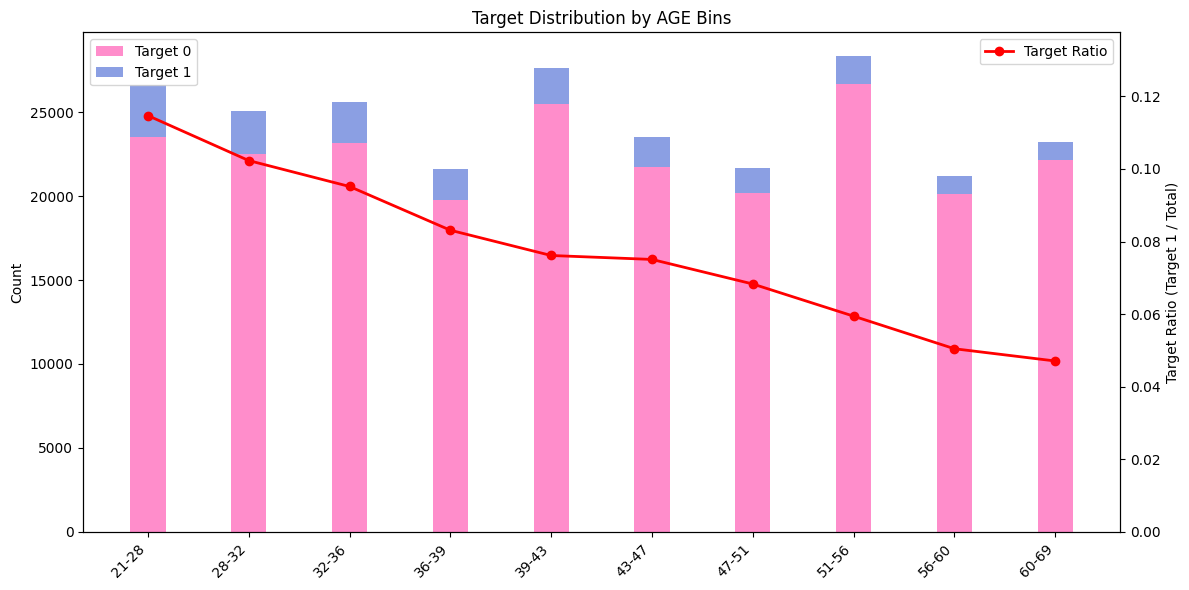

In [133]:
plot_bivariate_pie(app_data_clean, ["CODE_GENDER", "NAME_FAMILY_STATUS", "NAME_EDUCATION_TYPE"], "TARGET")
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'AGE', target_column='TARGET', bins=10)

**Insights**

---

- It seems that men faces more difficulties than women
- Clients with "lower secondary" education faces more difficulties, and clients with "academic degree" faces less. 

### (6) Social Network Influence

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


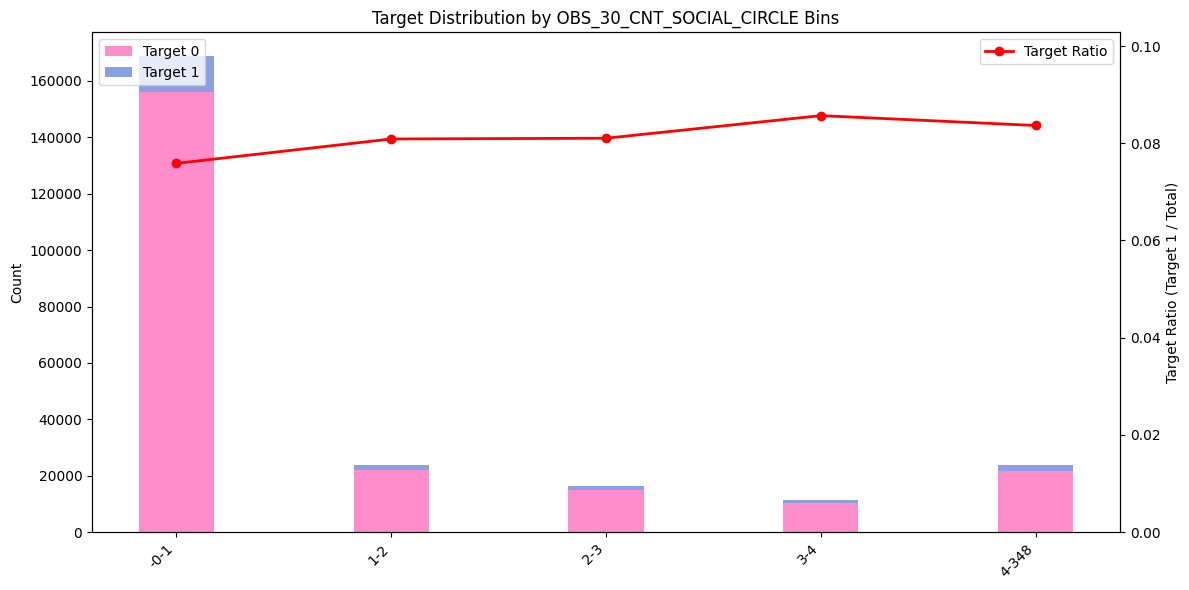

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


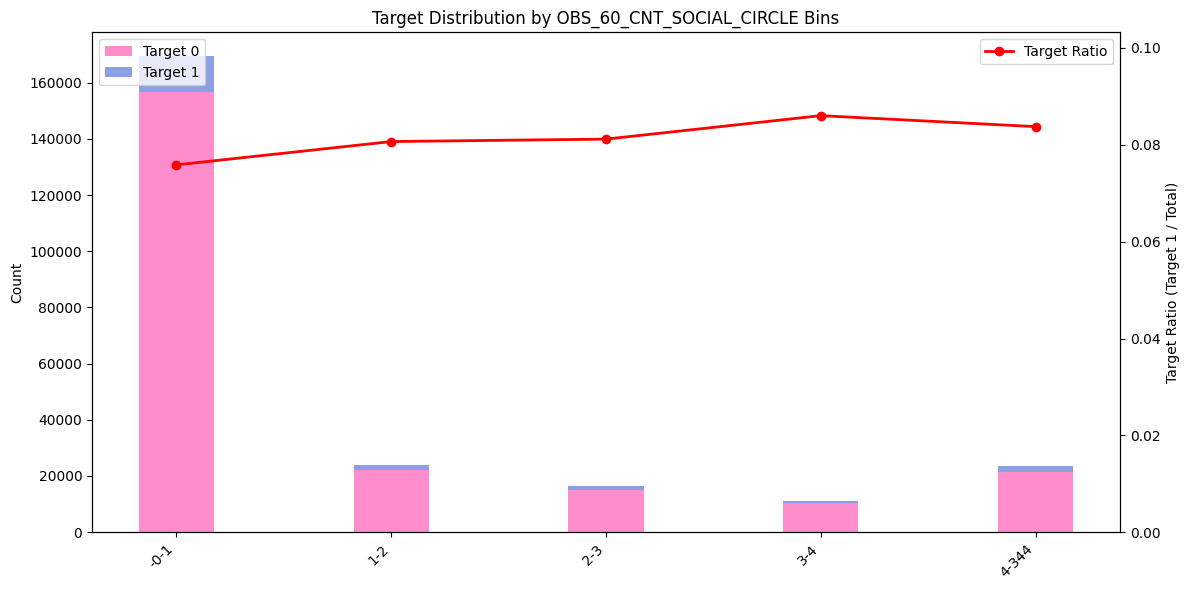

In [134]:
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'OBS_30_CNT_SOCIAL_CIRCLE', target_column='TARGET', bins=10)
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'OBS_60_CNT_SOCIAL_CIRCLE', target_column='TARGET', bins=10)

### (7) Housing Type

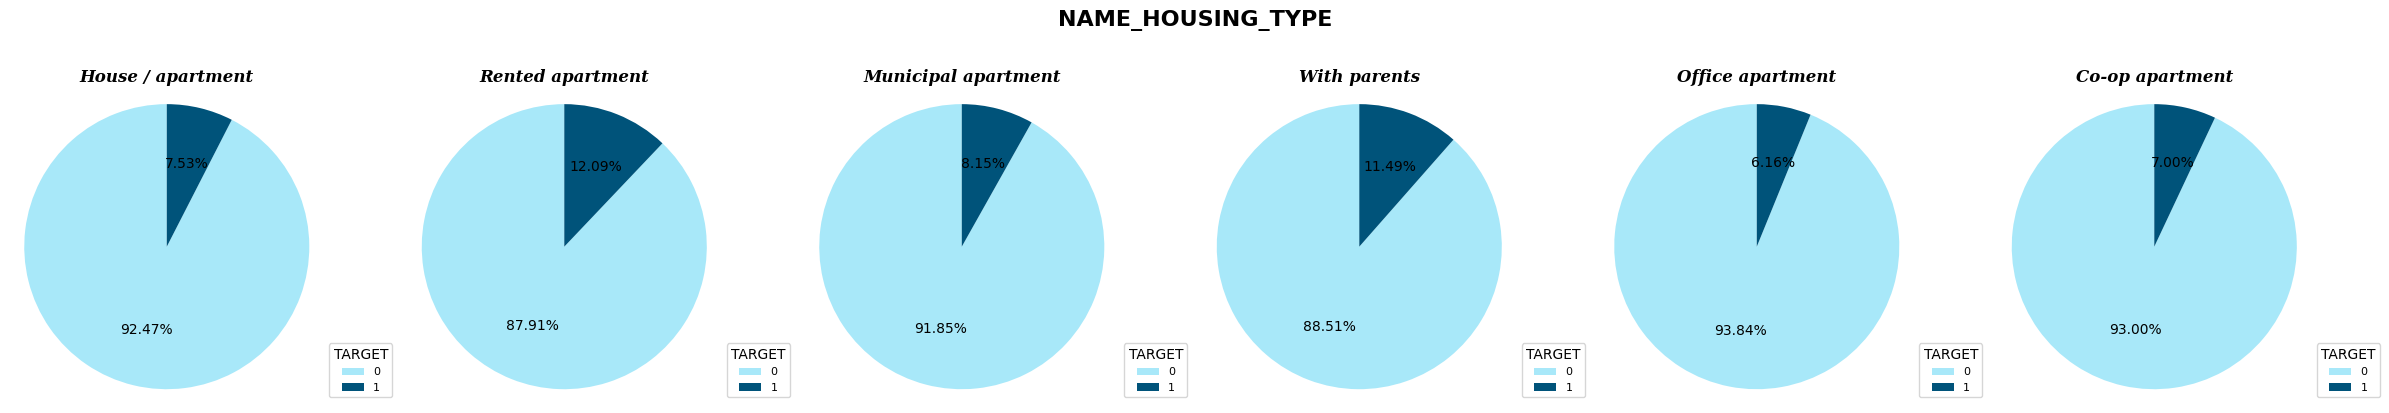

In [135]:
plot_bivariate_pie(app_data_clean, ["NAME_HOUSING_TYPE"], "TARGET")

### (8) Assets Ownership

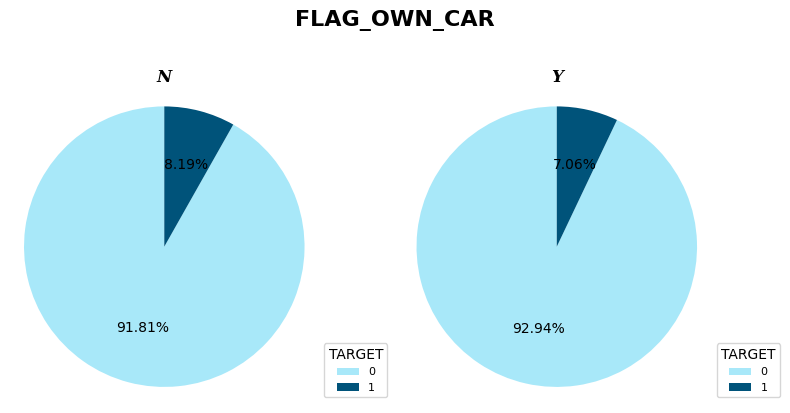

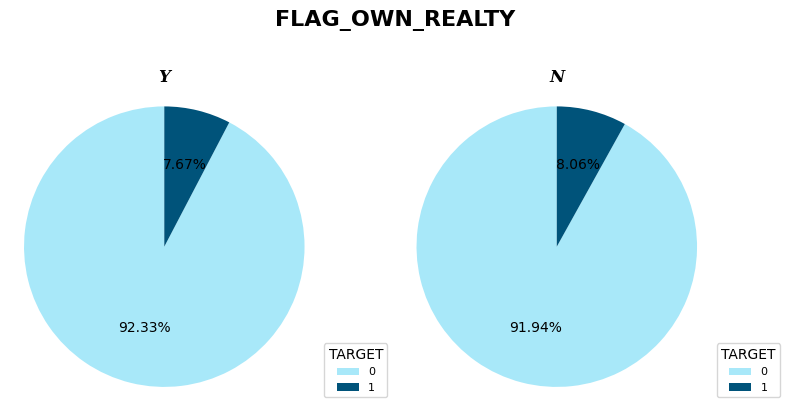

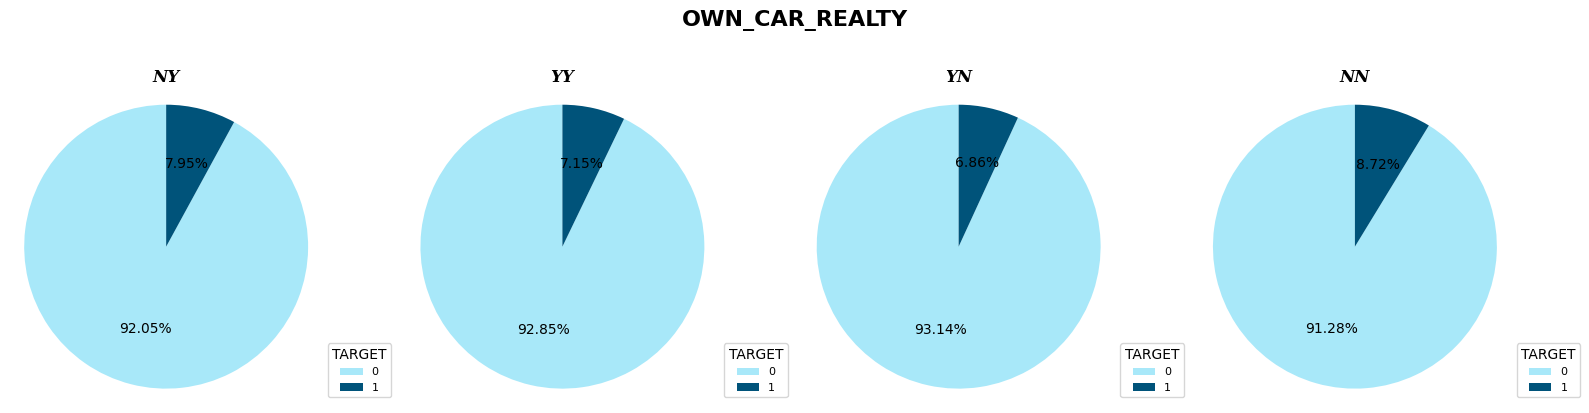

In [136]:
plot_bivariate_pie(app_data_clean, ["FLAG_OWN_CAR", "FLAG_OWN_REALTY"], "TARGET")
plot_bivariate_pie(app_data_clean, ["OWN_CAR_REALTY"], "TARGET")

### (9) Family Size

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


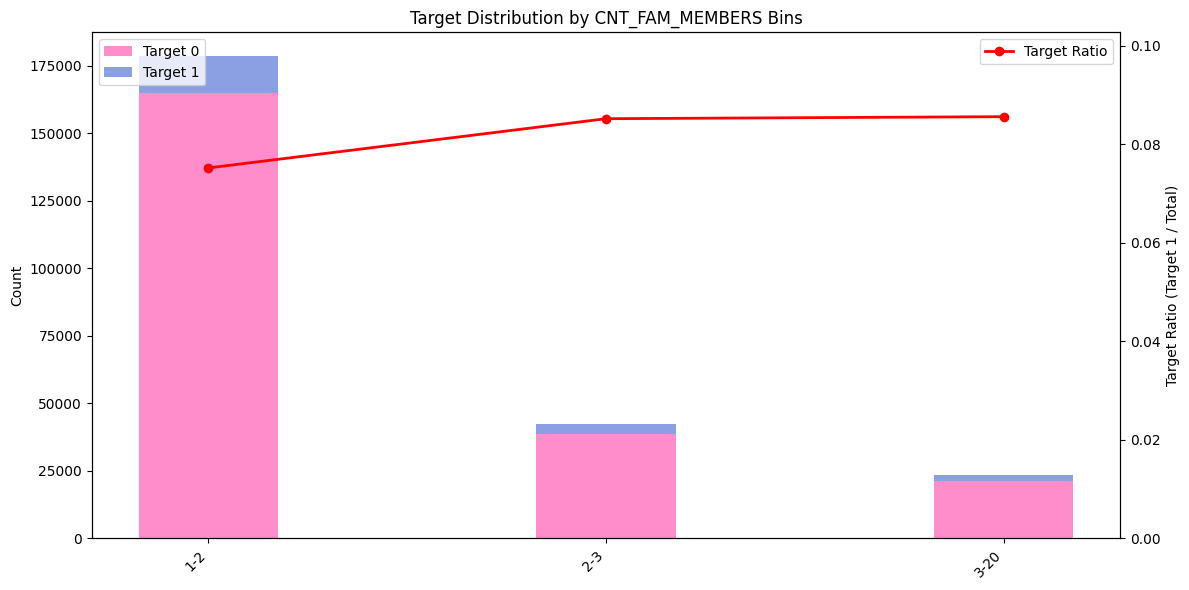

In [137]:
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'CNT_FAM_MEMBERS', target_column='TARGET', bins=10)

### (10) Documentation Completeness

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


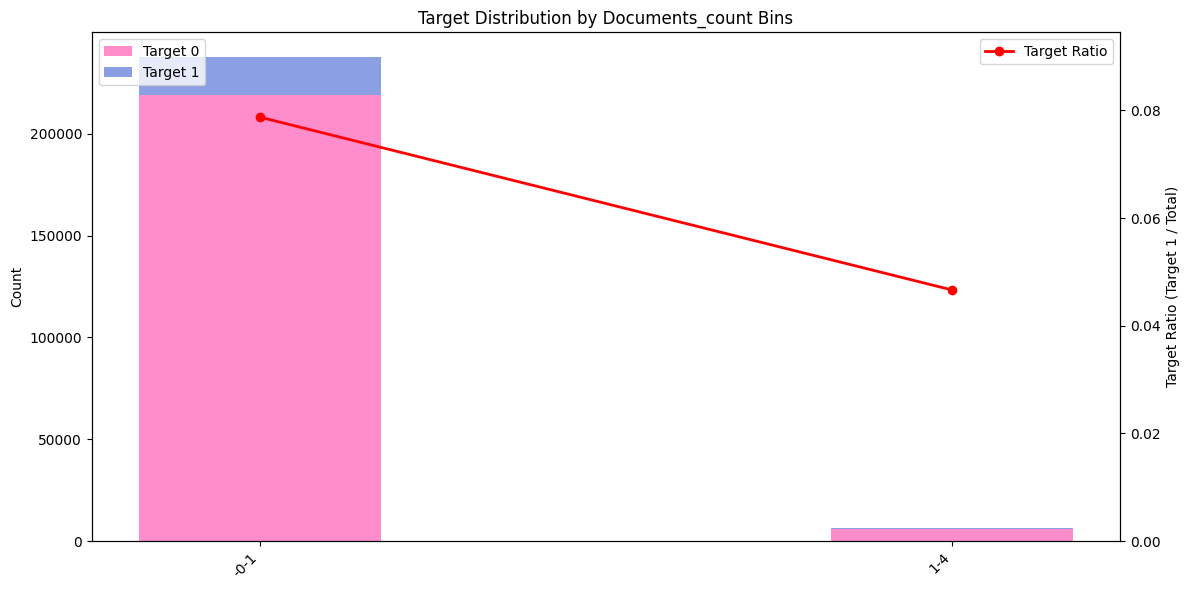

In [138]:
# count how much documents each user deliver
doc_cols = [col for col in app_data_clean.columns if col.startswith('FLAG_DOCUMENT_')]
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'Documents_count', target_column='TARGET', bins=10)

In [139]:
# for col in ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']:
#     plot_bivariate_pie(app_data_clean, ["TARGET"], col)


### (11) Addresses Consistency

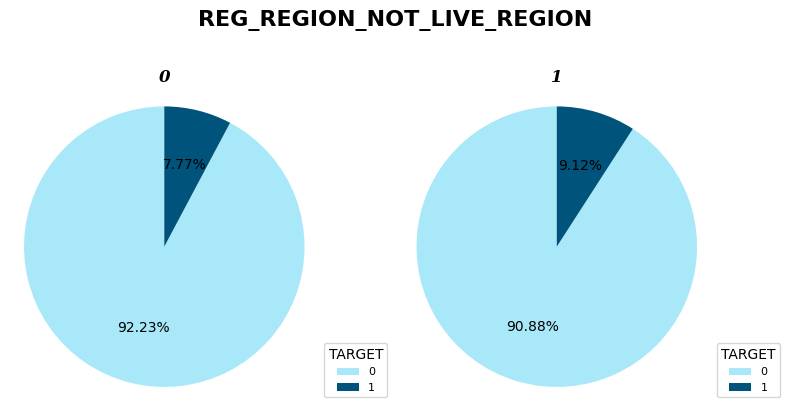

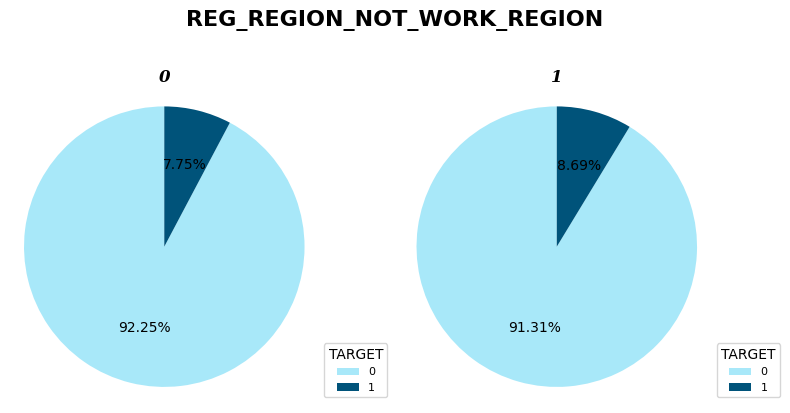

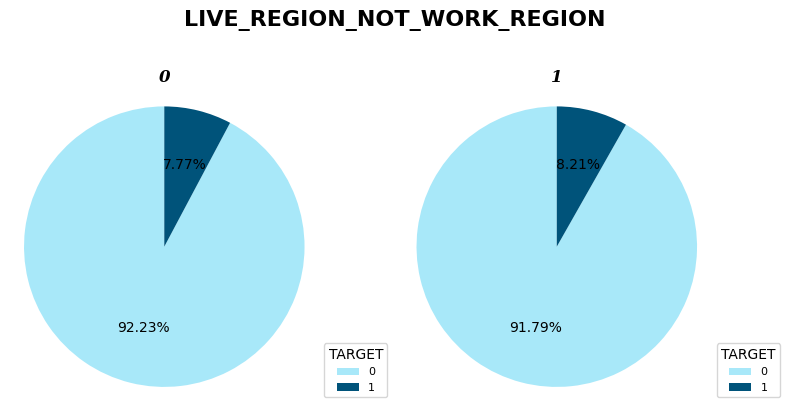

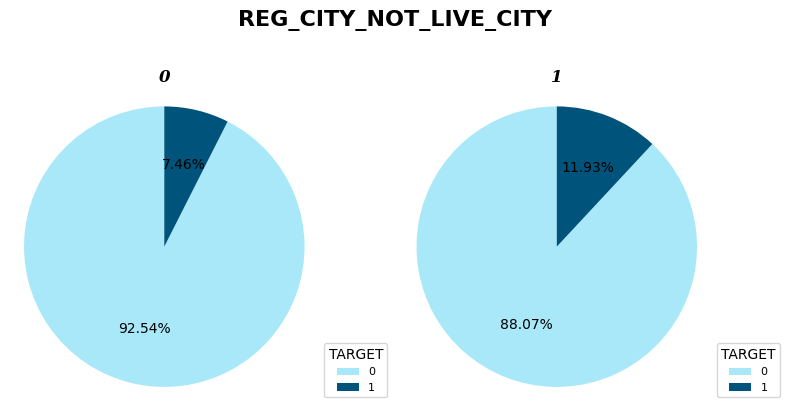

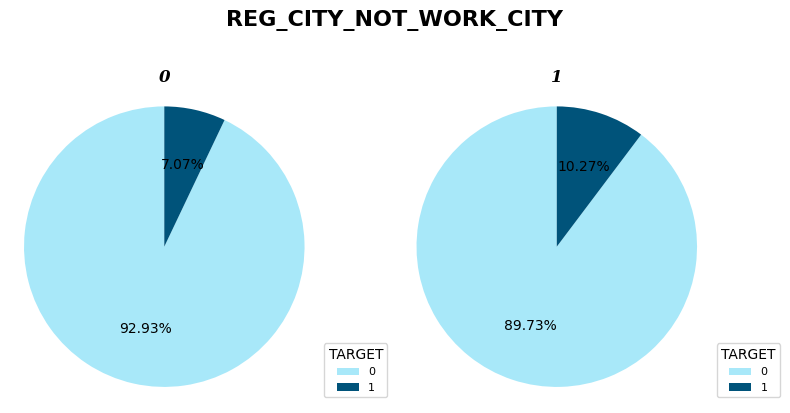

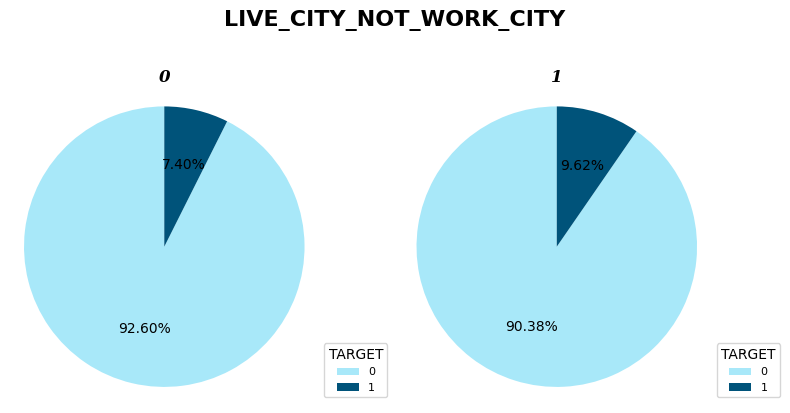

In [140]:
plot_bivariate_pie(app_data_clean, ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
,"TARGET")


### (12) Region Population

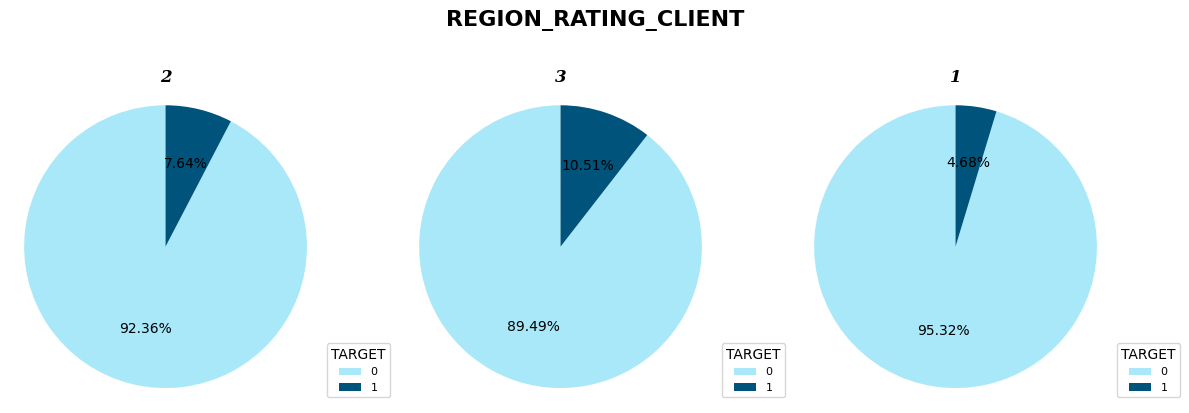

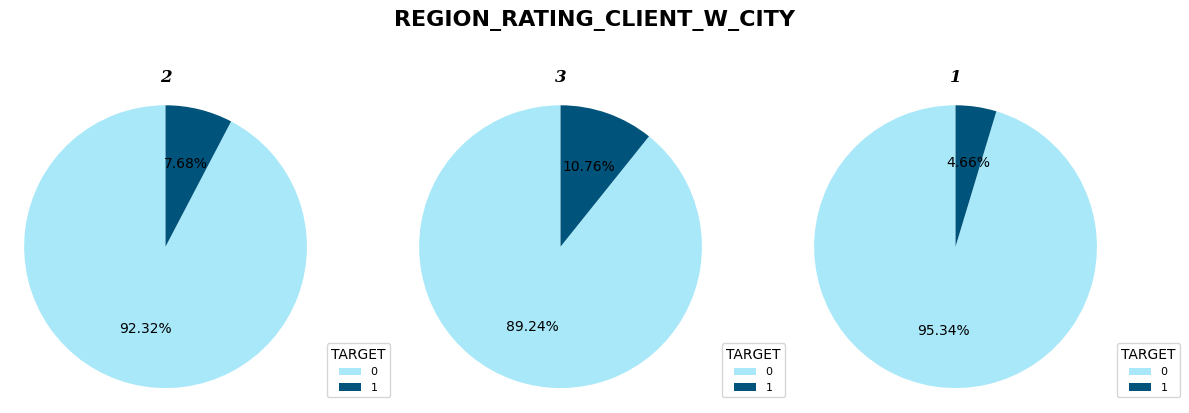

In [141]:
plot_bivariate_pie(app_data_clean, ["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"], "TARGET")

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


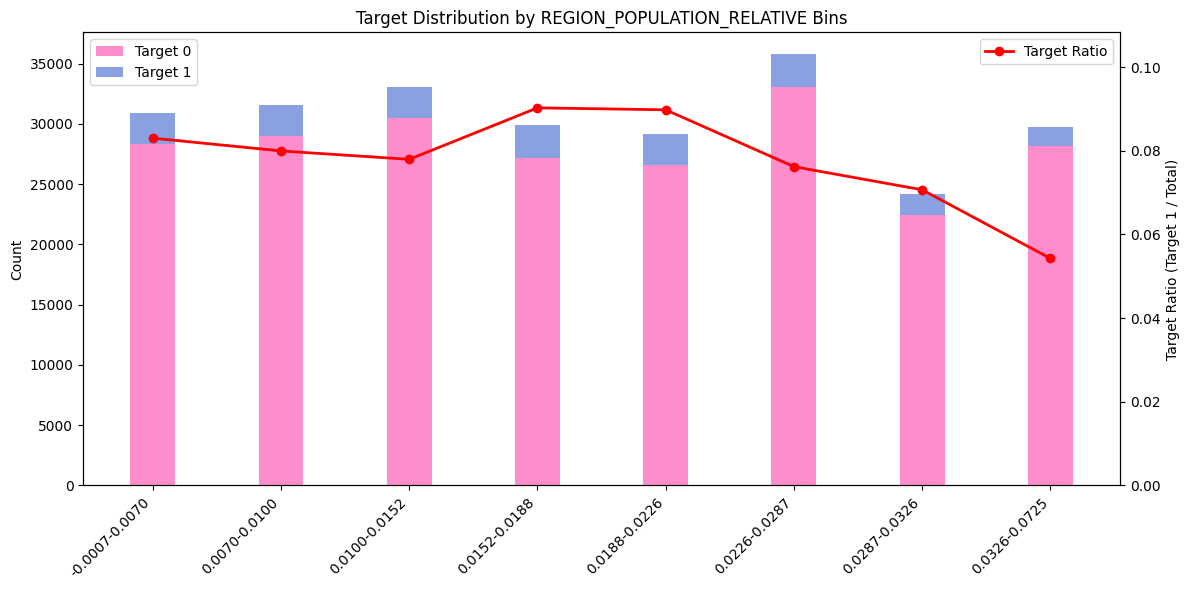

In [142]:
bin_stats = analyze_target_ratio_by_bins(app_data_clean, 'REGION_POPULATION_RELATIVE', target_column='TARGET', bins=8, float_point=4)

- Clients that lives in regions with higher ratings may face more difficulties

### (13) history

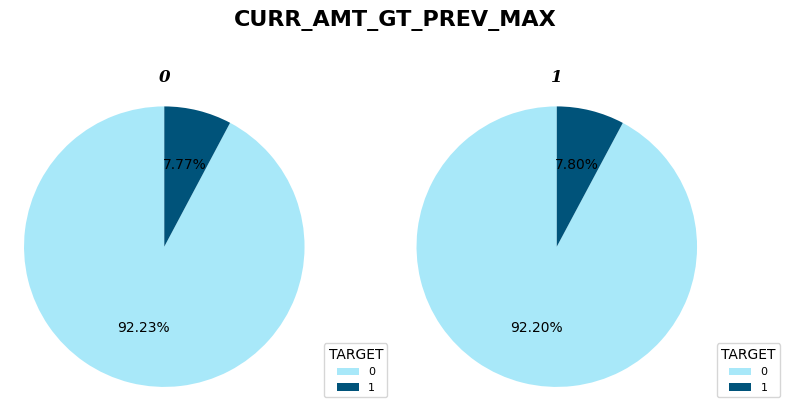

In [143]:
for col in ['CURR_AMT_GT_PREV_MAX']:
    plot_bivariate_pie(merged_data_clean, [col], "TARGET")

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


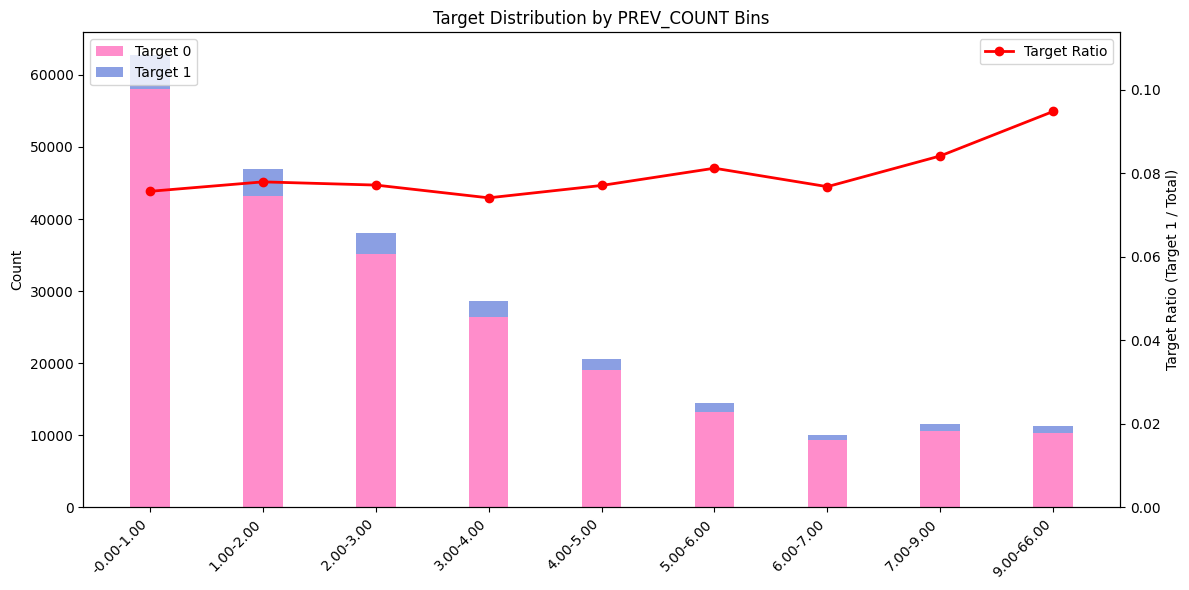

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


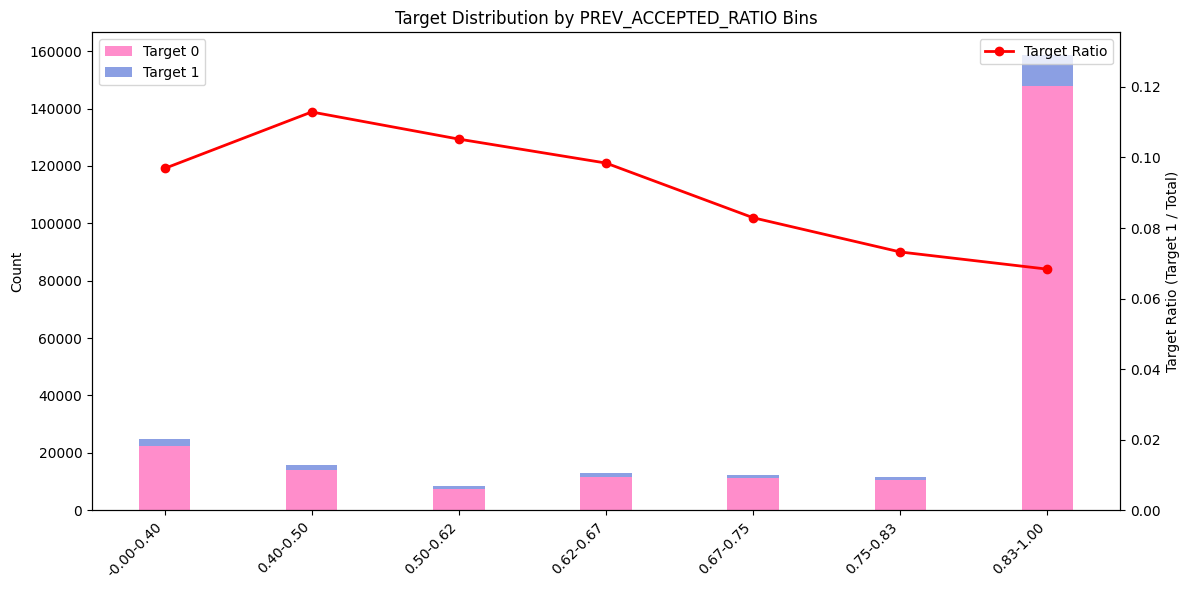

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


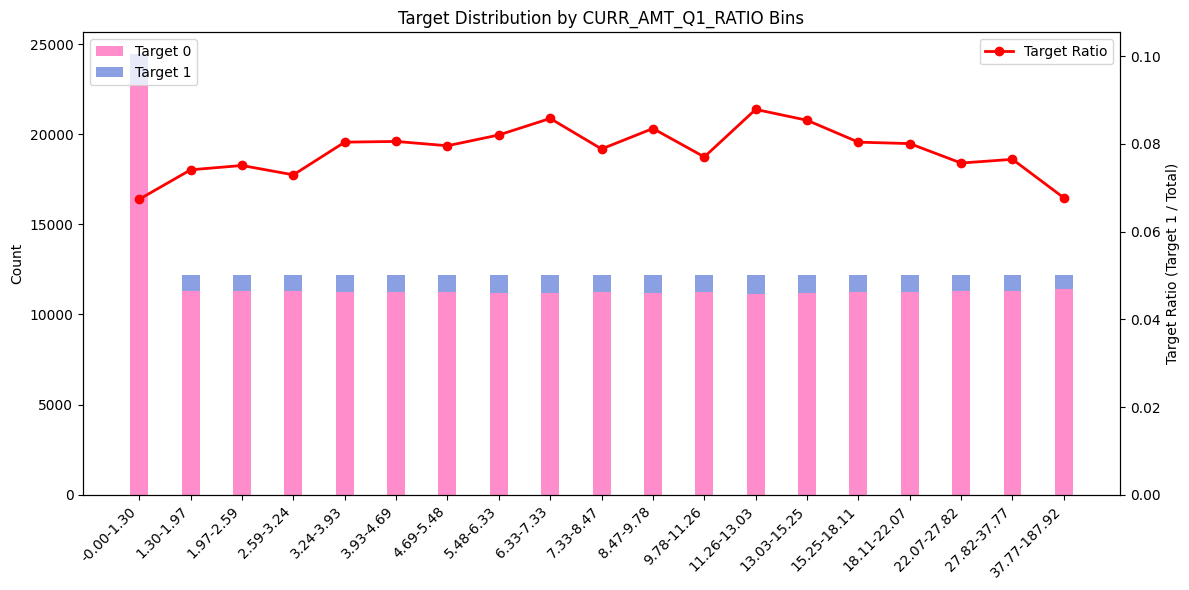

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


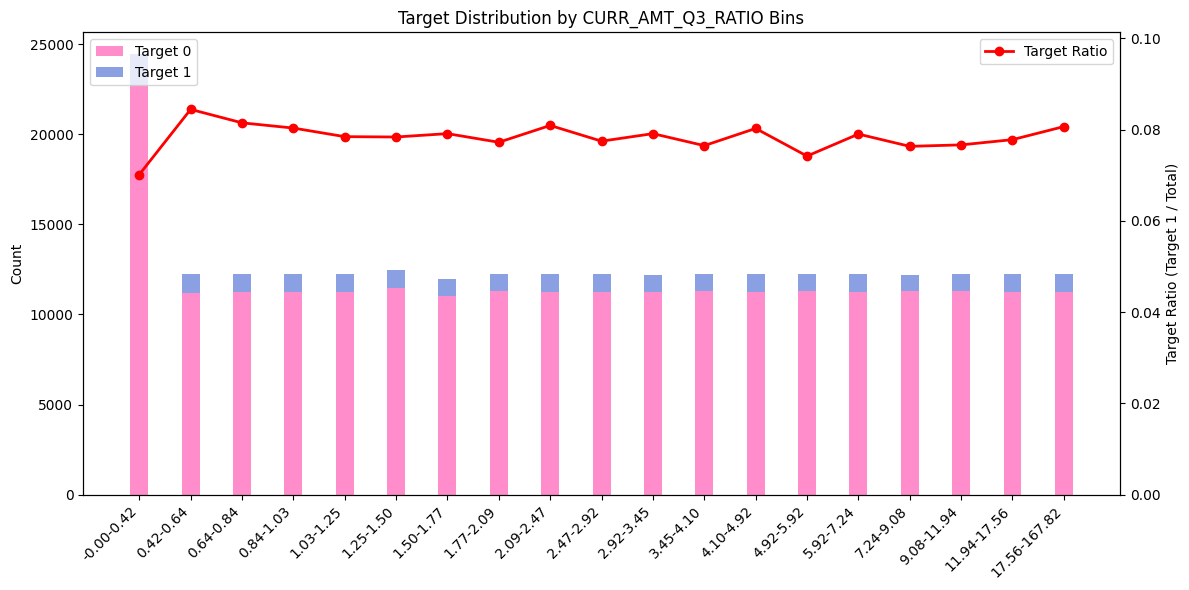

/tmp/ipykernel_10405/4138094674.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('bin').agg({


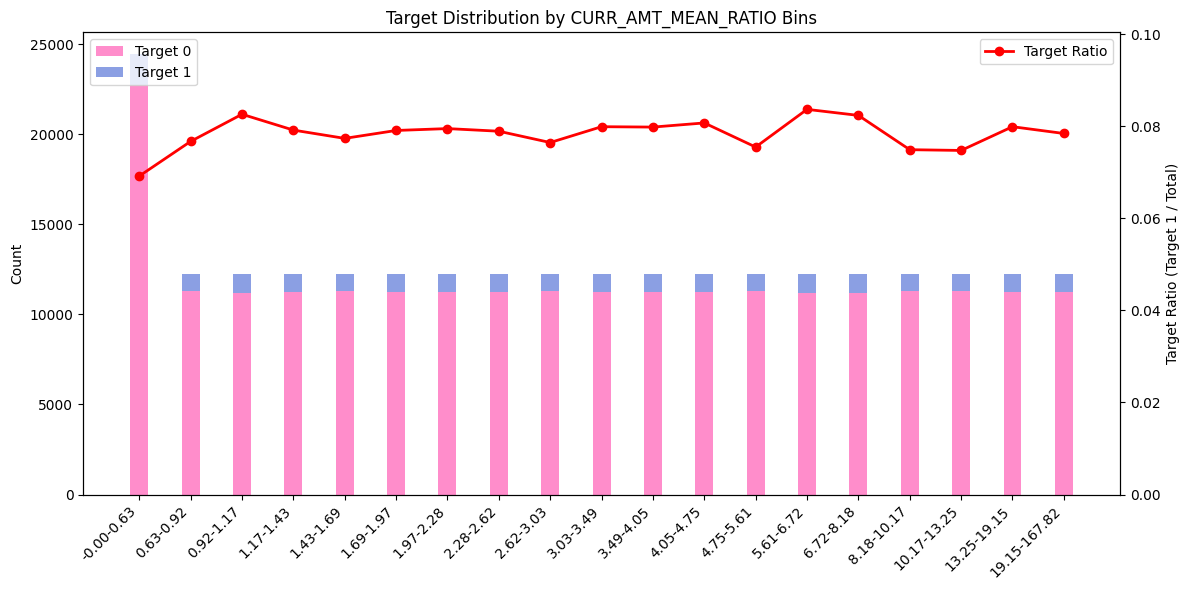

In [145]:
for col in ['PREV_COUNT', 'PREV_ACCEPTED_RATIO', 'CURR_AMT_Q1_RATIO', 'CURR_AMT_Q3_RATIO', 'CURR_AMT_MEAN_RATIO']:
    bin_stats = analyze_target_ratio_by_bins(merged_data_clean, col, target_column='TARGET', bins=20, float_point=2)